## Devlog

#### 20/06/23  
Quise usar la funcion hmm.GaussianHMM. Sin embargo, hay un issue con el startprob_prior:
>ValueError                                Traceback (most recent call last)  
>ValueError: startprob_ must sum to 1 (got nan)

Esta issue esta trackeada acá ("Looks like there is some issue...")
https://stackoverflow.com/questions/18796658/scikit-learn-gaussian-hmm-valueerror-startprob-must-sum-to-1-0
pero pide modificar el paquete hmm.base para hacer un quickfix de un -1.0 que quedó en el código. Voy a buscar de solucionar esto con el paquete estándar.   
Por lo tanto, no voy a usar el parámetro startprob_prior.

## Startup

Hidden Markov Models With Python (Gold example)  
https://medium.com/@natsunoyuki/hidden-markov-models-with-python-c026f778dfa7  
## 
   
  
Bloomberg: A PRACTICAL MODEL FOR PREDICTION OF INTRADAY VOLATILITY  
https://assets.bbhub.io/professional/sites/10/intraday_volatility-3.pdf?bbgsum-page=DG-WS-PROF-BLOG-POST-121973&tactic-page=429888

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
from hmmlearn import hmm

import os
import pickle

In [2]:
import yfinance as yf
yf.pdr_override()

In [3]:
np.random.seed(42)

In [4]:
dataroute=os.path.join("..",  "data")
resultsroute=os.path.join("..",  "results")

## Data Retrieval

In [5]:
tickerlist=["^MERV", 
            "GGAL", "GGAL.BA", 
            "YPF", "YPFD.BA",
            "EDN", "EDN.BA",
            "BMA", "BMA.BA"] 
# sumar tamb BBAR/BBAR? TEO/TECO2?

In [6]:
factordict={"GGAL": 10, "YPF":1, "EDN":20, "BMA":10, "BBAR":3, "TEO":5}

In [7]:
stocks=tickerlist.copy()
stocks.remove("^MERV")
stocklist=[]

for i in range(0, len(stocks), 2):
    stocklist.append((stocks[i], stocks[i+1]))
del stocks
stocklist

[('GGAL', 'GGAL.BA'), ('YPF', 'YPFD.BA'), ('EDN', 'EDN.BA'), ('BMA', 'BMA.BA')]

In [8]:
ohlclist=["Open", "High", "Low", "Close"]

In [9]:
objectlist=[]

for ticker in tickerlist:
    objectlist.append(yf.Ticker(ticker))    

In [10]:
# get historical market data
data={}
start='2013-01-01'
end="2023-06-01"

In [11]:
name=f'dataset_{start}_{end}_{str(tickerlist)}.pickle'
filename=os.path.join(dataroute, name)

In [12]:
if not os.path.exists(filename):
    for ticker in objectlist:
        # descargo data en un diccionario[ticker]
        data[ticker.ticker] = ticker.history(start=start, end=end)
        # guardo en un pickle
    with open(filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
else:
    with open(filename, 'rb') as handle:
        data=pickle.load(handle)

## Data quality deletion

In [13]:
data_quality_dates=["2022-07-14"]

In [14]:
for ticker in tickerlist:
    data[ticker]=data[ticker].loc[~data[ticker].index.isin(pd.to_datetime(data_quality_dates))]

## Implicit USD calculation

In [15]:
def _reindex_refill_dfs(df1, df2):
    """
    The function returns two dataframes with an index as the union of the two.
    The dataframes are then forward filled.
    """
    index3=df1.index.union(df2.index)
    # reindex both con index3
    df3=df1.reindex(index3)
    df4=df2.reindex(index3)
    # fillna con previous value
    df3.fillna(method="ffill")
    df4.fillna(method="ffill")
    return df3, df4

In [16]:
def calculate_usd(usd_df, ars_df, conversion_factor):
    """
    The function returns a dataframe with an index the size of the union between the two.
    Missing values in dates (stemming from, for example, holidays in one country) are
    forward filled to create the last  
    """
    usd_df_r, ars_df_r = _reindex_refill_dfs(usd_df, ars_df)
    implicit_usd = ars_df_r.divide(usd_df_r)*conversion_factor
    return implicit_usd

In [17]:
usdlist=[]
for stocktuplo in stocklist:
    us, ba = stocktuplo
    usdlist.append(f"USD_{us}")
    data[f"USD_{us}"]=calculate_usd(data[us][ohlclist], data[ba][ohlclist], factordict[us])
    data[f"USD_{us}"]["Average"]=data[f"USD_{us}"].mean(axis=1)

In [18]:
data["USD"]=pd.DataFrame(columns=ohlclist)

for i in ohlclist:
    df=pd.concat([data[col][i] for col in usdlist], axis=1)
    data["USD"][i]=df.mean(axis=1)
    
data["USD"]["Average"]=data["USD"].mean(axis=1)

In [19]:
for key in data.keys():
    data[key].fillna(method="ffill", inplace=True)
    # revisar esto

<Axes: xlabel='Date'>

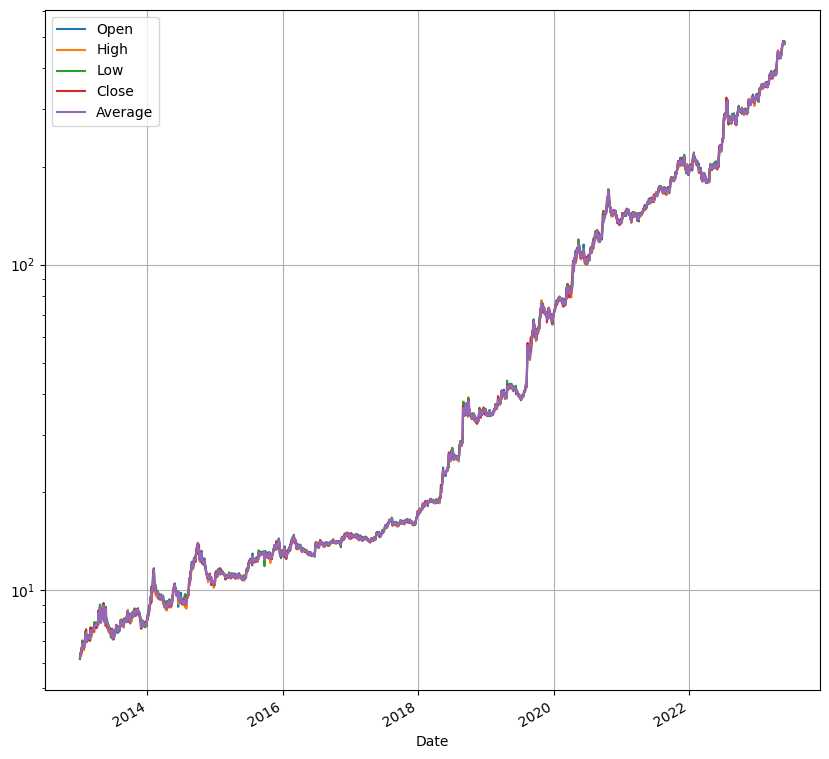

In [20]:
data["USD"][[*ohlclist, "Average"]].plot(figsize=(10,10), logy=True, grid=True)

## USD Denominated Index

In [21]:
data["USD_^MERV"]=pd.DataFrame(columns=ohlclist)

for col in ohlclist:
    data["USD_^MERV"][col] = data["^MERV"][col]/data["USD"]["Average"]

In [22]:
data["USD_^MERV"].fillna(method="ffill", inplace=True)

## Intraday Volatility

Vamos a usar para medir intraday volatility el estimador de Garman and Klass (1980):

$$V_{ohlc}=0.5*[log(H)-log(L)]^2+(2*log(2)-1)*[log(C)-log(O)]^2$$ 
Donde H es el precio mas alto del día, L el bajo, C el cierre y O su apertura

Garman, M. B. and M. J. Klass (1980). On the estimation of security price volatilities from historical data. Journal of Business 53, 67–78.

In [23]:
def gk_vol(o, h, l, c):
    "Returns Garman Klass (1980) intraday volatility estimator"
    return 0.5*(np.log(h)-np.log(l))**2+(2*np.log(2)-1)*(np.log(c)-np.log(o))**2

## Returns Calculation

In [24]:
for ticker in data.keys():
    view=data[ticker]
    view["rets"] = view["Close"]/view["Close"].shift()-1
    view["log_rets"] = np.log(view["Close"]/view["Close"].shift())
    view["norm_range"] = (view["High"]-view["High"])/view["Open"]
    # chequear si esto tiene asidero
    # alternativa (view["High"]-view["High"])/view["Close"]
    view["gk_vol"] = gk_vol(o=view["Open"], h=view["High"], l=view["Low"], c=view["Close"])
    # delete first observation to eliminate nans
    data[ticker]=data[ticker][1:].copy()

## Descriptive Statistics

In [25]:
# TBD

## HMM Training

In [26]:
models={}
comps=[2,3,4]
datacols=["log_rets","gk_vol"]

for key in data.keys():
    print(key)
    for comp in comps:
        print(comp)
        modelname=f"{key}_{comp}_model"
        predictionname=f"{key}_{comp}_prediction"
        
        X = data[key][datacols].values.reshape(-1, len(datacols))
        # bivariate
        # log returns and intraday volatility        
        models[modelname]=hmm.GaussianHMM(n_components = comp, #no voy a usar startprob_prior por devlog 20-06-23
                                          covariance_type = "diag", 
                                          n_iter = 50,
                                          random_state = 42)
        models[modelname].fit(X)
        models[predictionname]=models[modelname].predict(X)

^MERV
2


Model is not converging.  Current: 18846.005278247954 is not greater than 18847.134444221098. Delta is -1.1291659731432446
Model is not converging.  Current: 18142.20139769384 is not greater than 18142.85021337392. Delta is -0.6488156800805882
Model is not converging.  Current: 18905.499058655805 is not greater than 18910.228067216696. Delta is -4.729008560891089


3
4
GGAL
2


Model is not converging.  Current: 18038.2624343628 is not greater than 18038.278369587973. Delta is -0.015935225172142964


3


Model is not converging.  Current: 18073.008746550106 is not greater than 18076.651123470318. Delta is -3.642376920211973


4
GGAL.BA
2
3
4
YPF
2


Model is not converging.  Current: 18304.593473233163 is not greater than 18308.56560900438. Delta is -3.9721357712187455
Model is not converging.  Current: 17756.75997738401 is not greater than 17757.203913438225. Delta is -0.443936054216465
Model is not converging.  Current: 18369.996877026984 is not greater than 18371.30239834195. Delta is -1.3055213149673364
Model is not converging.  Current: 17798.73799169456 is not greater than 17800.802271672113. Delta is -2.06427997755236


3
4
YPFD.BA
2
3


Model is not converging.  Current: 17830.629473372283 is not greater than 17832.10104083943. Delta is -1.4715674671460874


4
EDN
2
3


Model is not converging.  Current: 17080.684098763533 is not greater than 17081.789151608806. Delta is -1.1050528452724393


4


Model is not converging.  Current: 17077.993638007993 is not greater than 17078.23188687198. Delta is -0.2382488639887015
Model is not converging.  Current: 17066.381572371152 is not greater than 17070.799774758496. Delta is -4.4182023873436265


EDN.BA
2
3
4


Model is not converging.  Current: 17085.17881044322 is not greater than 17088.685822045376. Delta is -3.507011602156126
Model is not converging.  Current: 17947.094485930793 is not greater than 17949.89450591947. Delta is -2.800019988677377


BMA
2
3


Model is not converging.  Current: 18008.552831003428 is not greater than 18015.43153979727. Delta is -6.878708793843543
Model is not converging.  Current: 17313.299635746713 is not greater than 17317.363432490998. Delta is -4.063796744285355


4
BMA.BA
2
3
4


Model is not converging.  Current: 21247.674640540492 is not greater than 21249.126418425007. Delta is -1.4517778845147404
Model is not converging.  Current: 20429.677487024546 is not greater than 20429.7433032247. Delta is -0.06581620015276712


USD_GGAL
2
3
4


Model is not converging.  Current: 21252.80502130624 is not greater than 21252.974330425954. Delta is -0.1693091197121248


USD_YPF
2
3


Model is not converging.  Current: 19728.314739317448 is not greater than 19729.96415354752. Delta is -1.6494142300725798


4
USD_EDN
2
3


Model is not converging.  Current: 19728.048243246838 is not greater than 19732.180406605672. Delta is -4.132163358834077
Model is not converging.  Current: 21090.250653565647 is not greater than 21091.268319301555. Delta is -1.01766573590794
Model is not converging.  Current: 20256.94768613181 is not greater than 20257.635957869203. Delta is -0.6882717373919149


4
USD_BMA
2
3
4


Model is not converging.  Current: 21093.16346480629 is not greater than 21093.90066998354. Delta is -0.7372051772508712


USD
2
3


Model is not converging.  Current: 21535.65635853495 is not greater than 21535.89830316664. Delta is -0.24194463168896618
Model is not converging.  Current: 19946.186981522354 is not greater than 19948.99284249492. Delta is -2.805860972566734


4
USD_^MERV
2
3


Model is not converging.  Current: 20007.553148425937 is not greater than 20007.581922967158. Delta is -0.028774541220627725


4


In [27]:
# Predict the hidden states corresponding to observed X.
for key in data.keys():
    for comp in comps:
        print(">"*30, key)
        model=models[f"{key}_{comp}_model"]
        prediction=models[f"{key}_{comp}_prediction"]
        print("unique states: ", pd.unique(prediction))
        print("\nStart probabilities:")
        print(model.startprob_)
        print("\nTransition matrix:")
        print(model.transmat_)
        print("\nGaussian distribution means:")
        print(model.means_)
        print("\nGaussian distribution covariances:")
        print(model.covars_)
        print()

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ^MERV
unique states:  [0 1]

Start probabilities:
[9.99999992e-01 7.77089851e-09]

Transition matrix:
[[0.99190044 0.00809956]
 [0.64107689 0.35892311]]

Gaussian distribution means:
[[ 0.0023665   0.00062083]
 [-0.03635524  0.0146091 ]]

Gaussian distribution covariances:
[[[4.65243073e-04 0.00000000e+00]
  [0.00000000e+00 4.63173289e-06]]

 [[1.44224149e-02 0.00000000e+00]
  [0.00000000e+00 1.50614206e-03]]]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ^MERV
unique states:  [1 0 2]

Start probabilities:
[2.64082753e-02 9.73591725e-01 1.62699196e-11]

Transition matrix:
[[1.36233321e-03 9.98614722e-01 2.29446306e-05]
 [9.77992322e-01 1.06337631e-02 1.13739147e-02]
 [2.70638123e-01 2.45724508e-01 4.83637369e-01]]

Gaussian distribution means:
[[ 0.00147874  0.0006487 ]
 [ 0.00320576  0.00061345]
 [-0.03997792  0.01558215]]

Gaussian distribution covariances:
[[[5.03860880e-04 0.00000000e+00]
  [0.00000000e+00 8.81549832e-06]]

 [[4.56882297e-04 0.00000000e+00]
  [0.00

unique states:  [2 0]

Start probabilities:
[1.48301583e-07 5.07215062e-36 9.99999852e-01 6.11562592e-35]

Transition matrix:
[[3.31523472e-01 4.93155480e-17 6.67822564e-01 6.53964467e-04]
 [6.59647612e-04 4.40636678e-10 6.42782248e-04 9.98697570e-01]
 [7.24237607e-03 1.26509321e-10 9.92757624e-01 4.44086349e-14]
 [9.99999998e-01 1.66091225e-17 1.45570764e-09 5.28756578e-10]]

Gaussian distribution means:
[[0.02304511 0.00385074]
 [0.06716823 0.00784163]
 [0.00145876 0.00031289]
 [0.1060298  0.00780257]]

Gaussian distribution covariances:
[[[5.19448279e-03 0.00000000e+00]
  [0.00000000e+00 3.61868707e-04]]

 [[1.00000010e+03 0.00000000e+00]
  [0.00000000e+00 1.00000000e+03]]

 [[2.78631639e-04 0.00000000e+00]
  [0.00000000e+00 4.04397135e-06]]

 [[5.36177635e-01 0.00000000e+00]
  [0.00000000e+00 5.31454614e-01]]]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> USD
unique states:  [0 1]

Start probabilities:
[1.00000000e+00 2.01835201e-18]

Transition matrix:
[[0.99186814 0.00813186]
 [0.44520767 0.55

In [28]:
def plot_close_rets_vol(data, key, comp):
    model=models[f"{key}_{comp}_model"]
    prediction=models[f"{key}_{comp}_prediction"]
    states=set(prediction)

    plt.figure(figsize = (20, 20))

    for subplot, var in zip(range(1,4), ["Close", "log_rets", "gk_vol"]):    
        plt.subplot(3,1,subplot)
        for i in set(prediction):
            state = (prediction == i)
            x = data[key].index[state]
            y = data[key][var].iloc[state]
            plt.plot(x, y, '.')
        plt.legend(states, fontsize=16)
        plt.grid(True)
        plt.xlabel("datetime", fontsize=16)
        plt.ylabel(var, fontsize=16)
        plt.tight_layout()

    plt.savefig(os.path.join(resultsroute, "graphs", 
                             f"{comp}_states", 
                             f"{key}_model_{comp}.png"))

C:\Users\Alfred\AppData\Local\Temp\ipykernel_16856\2572118105.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (20, 20))


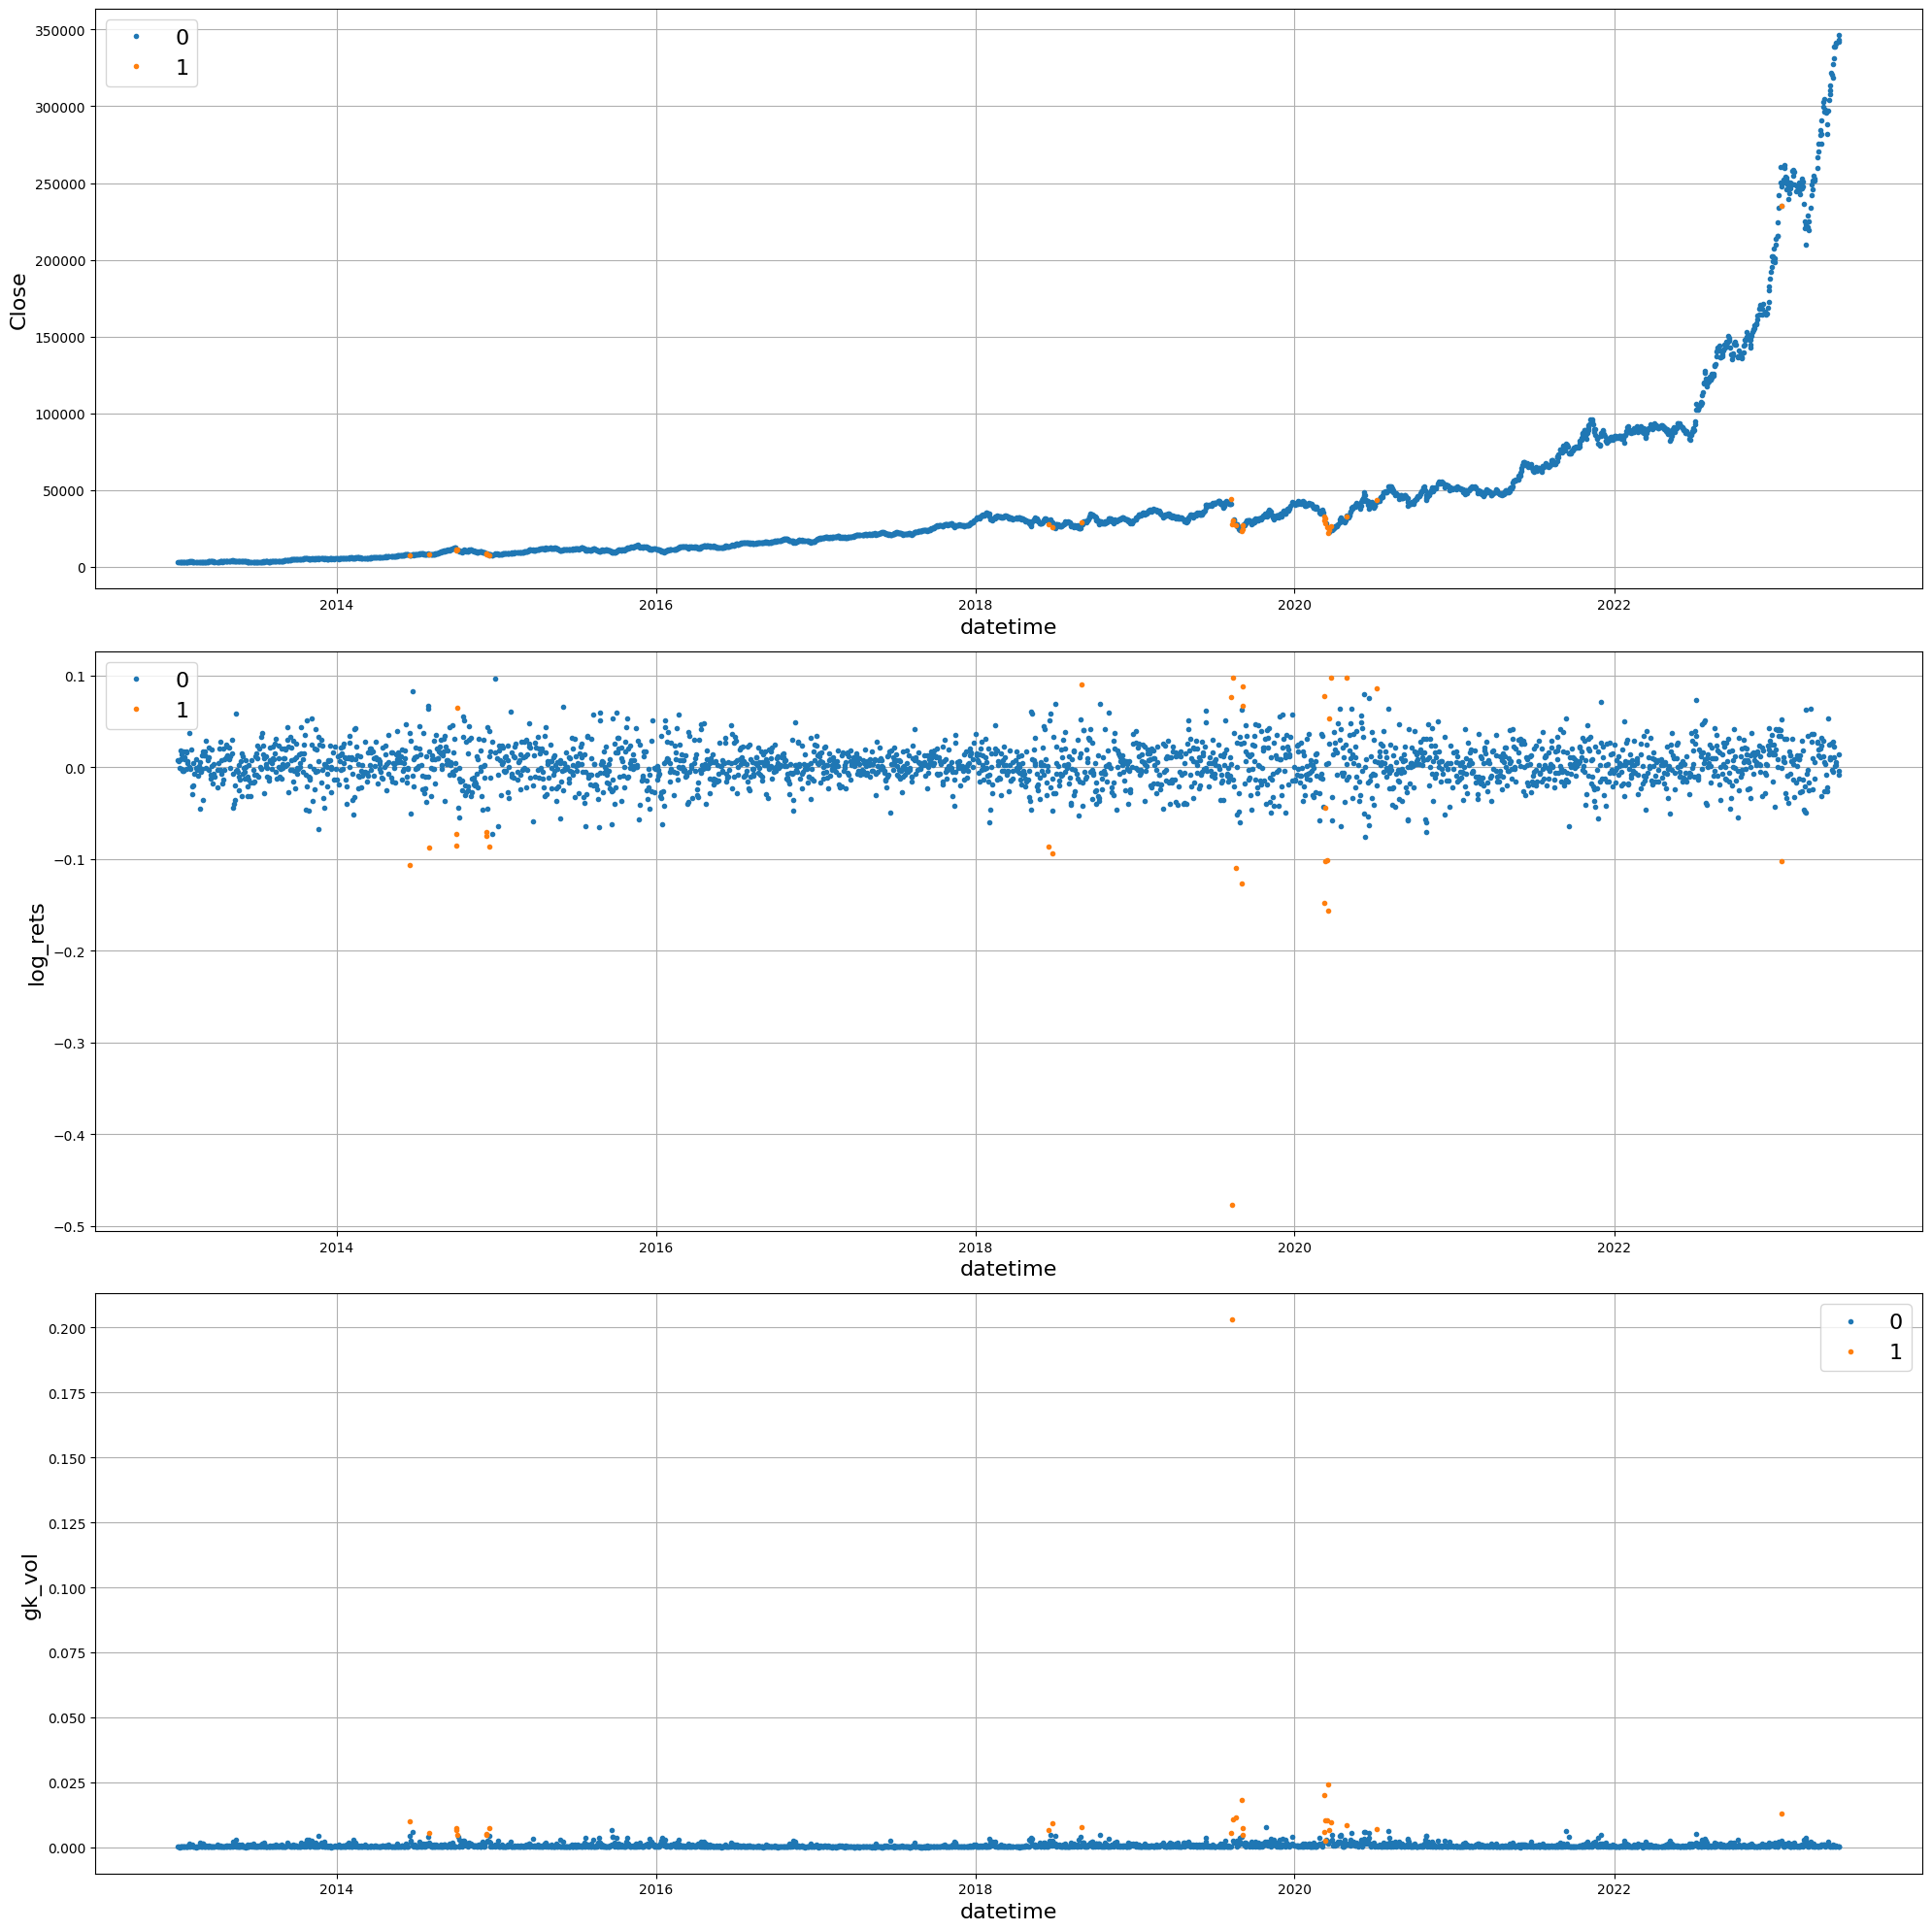

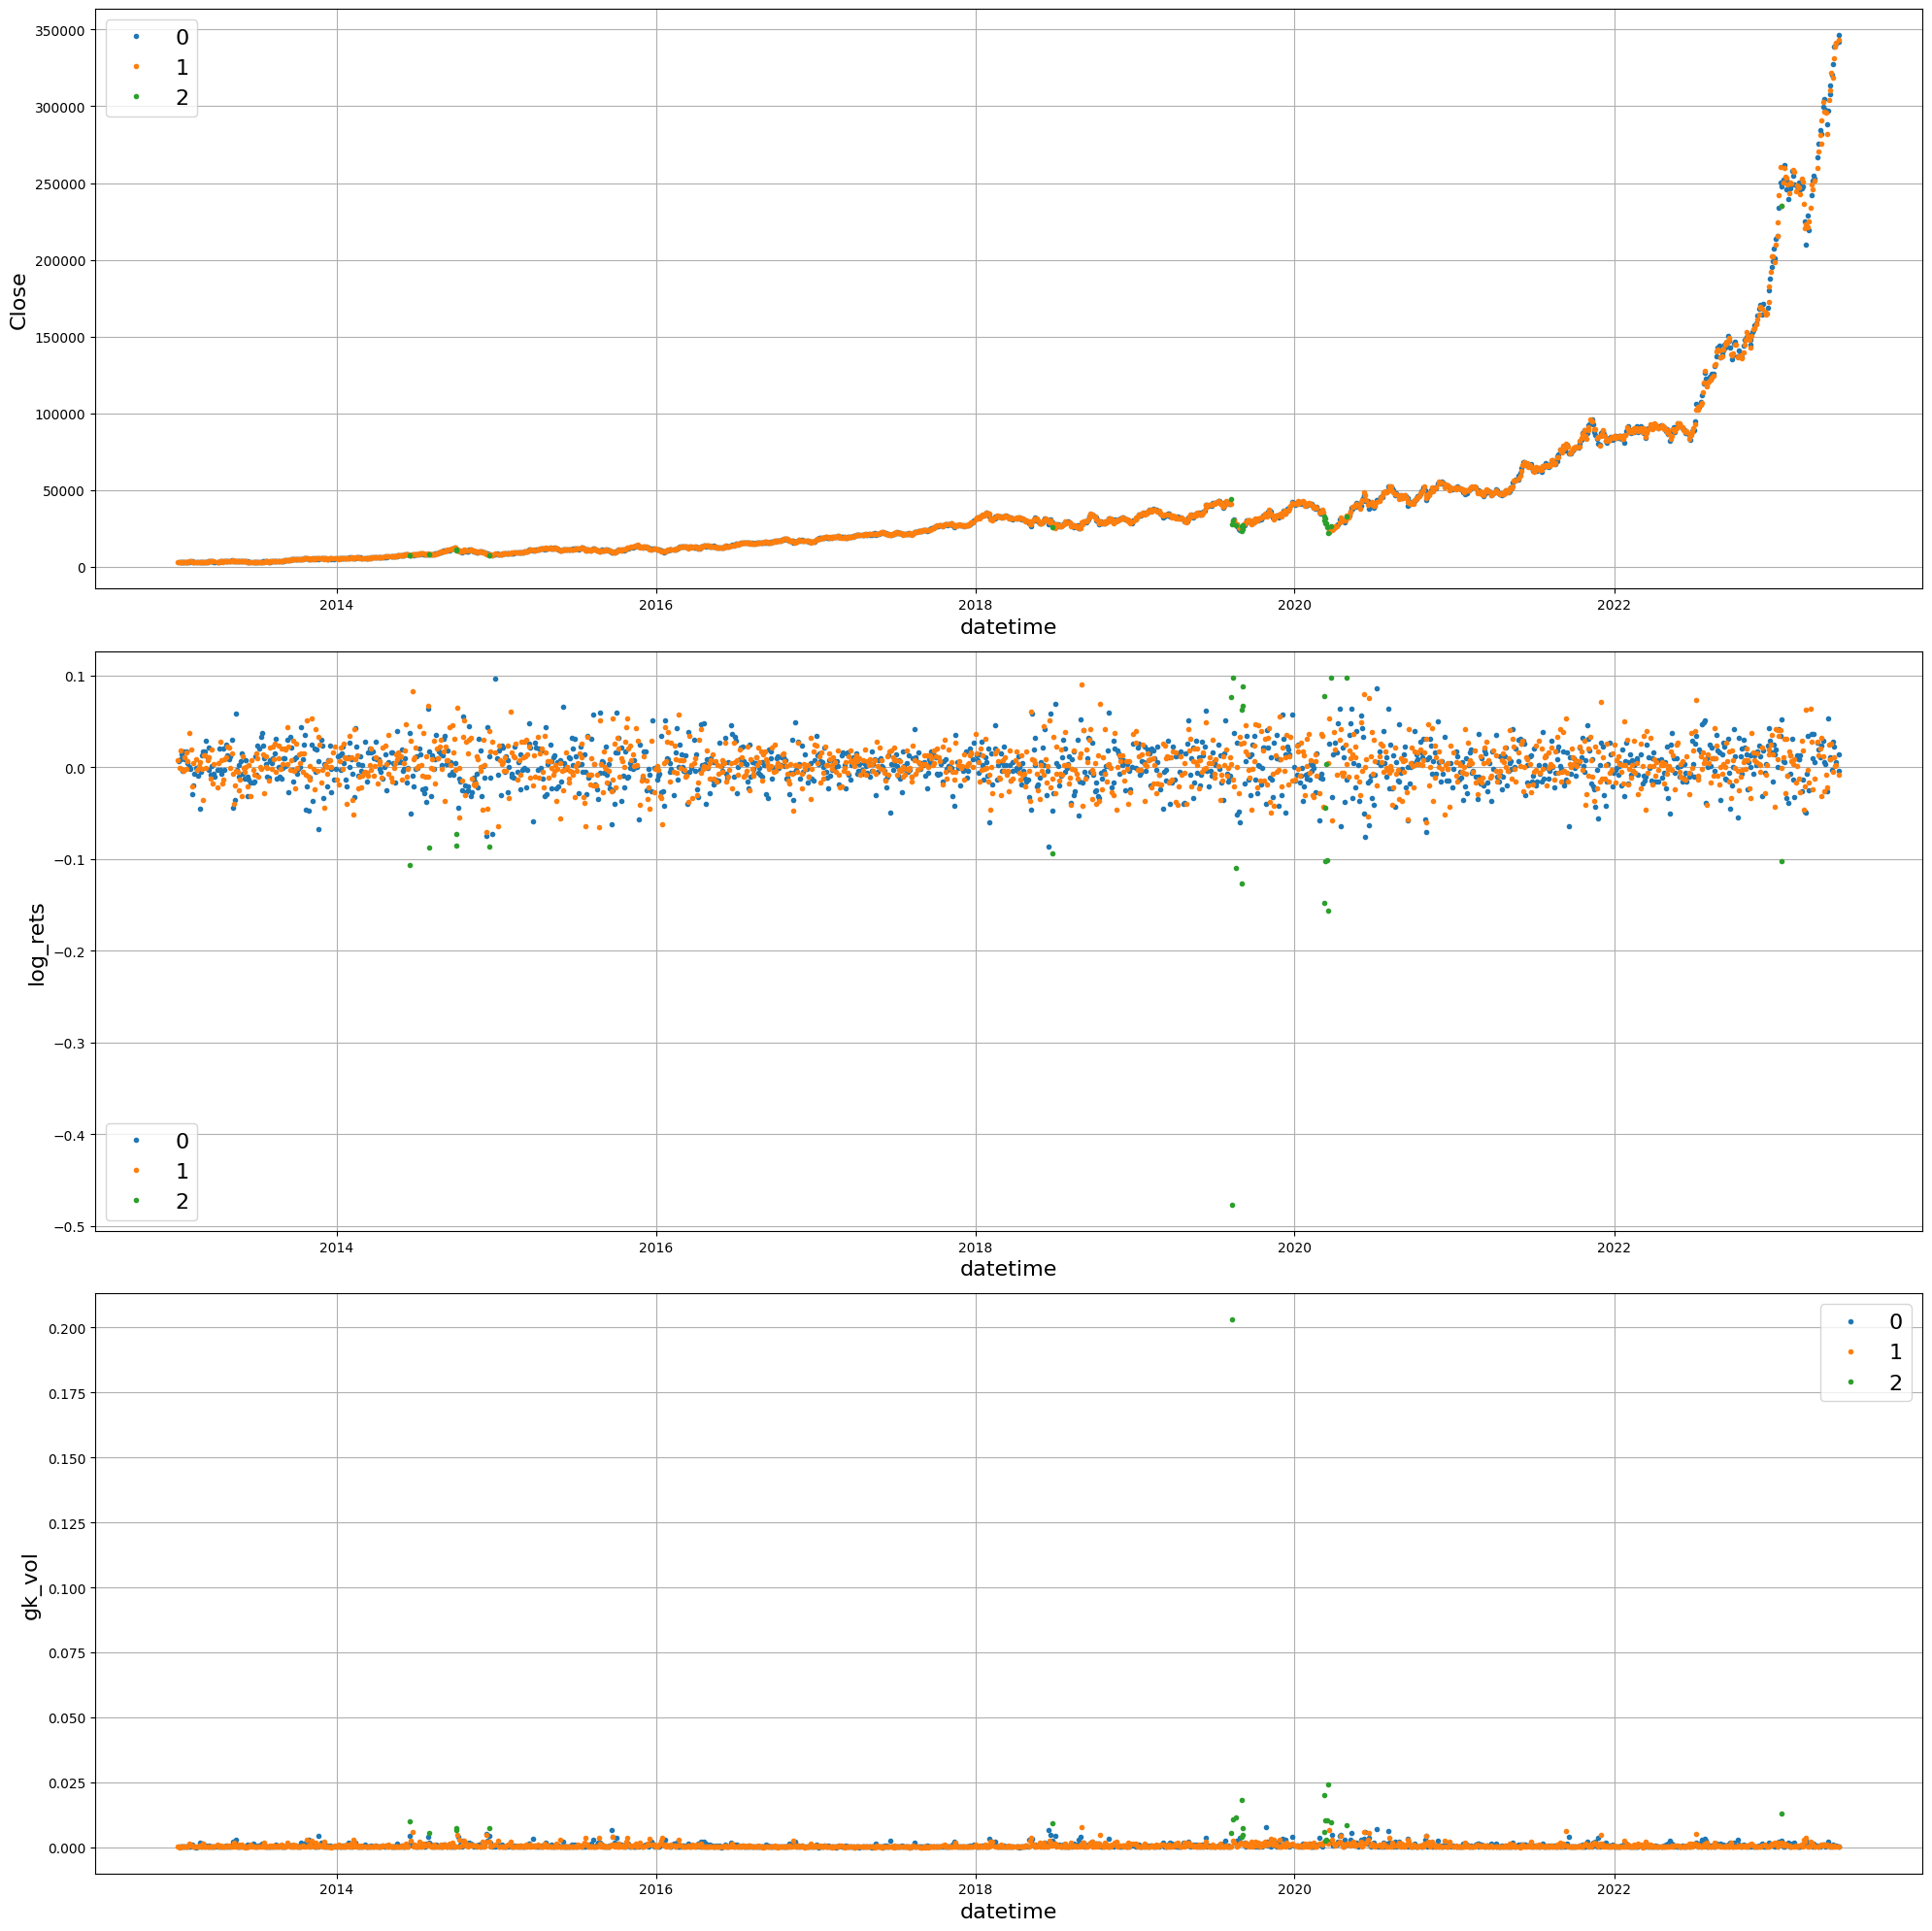

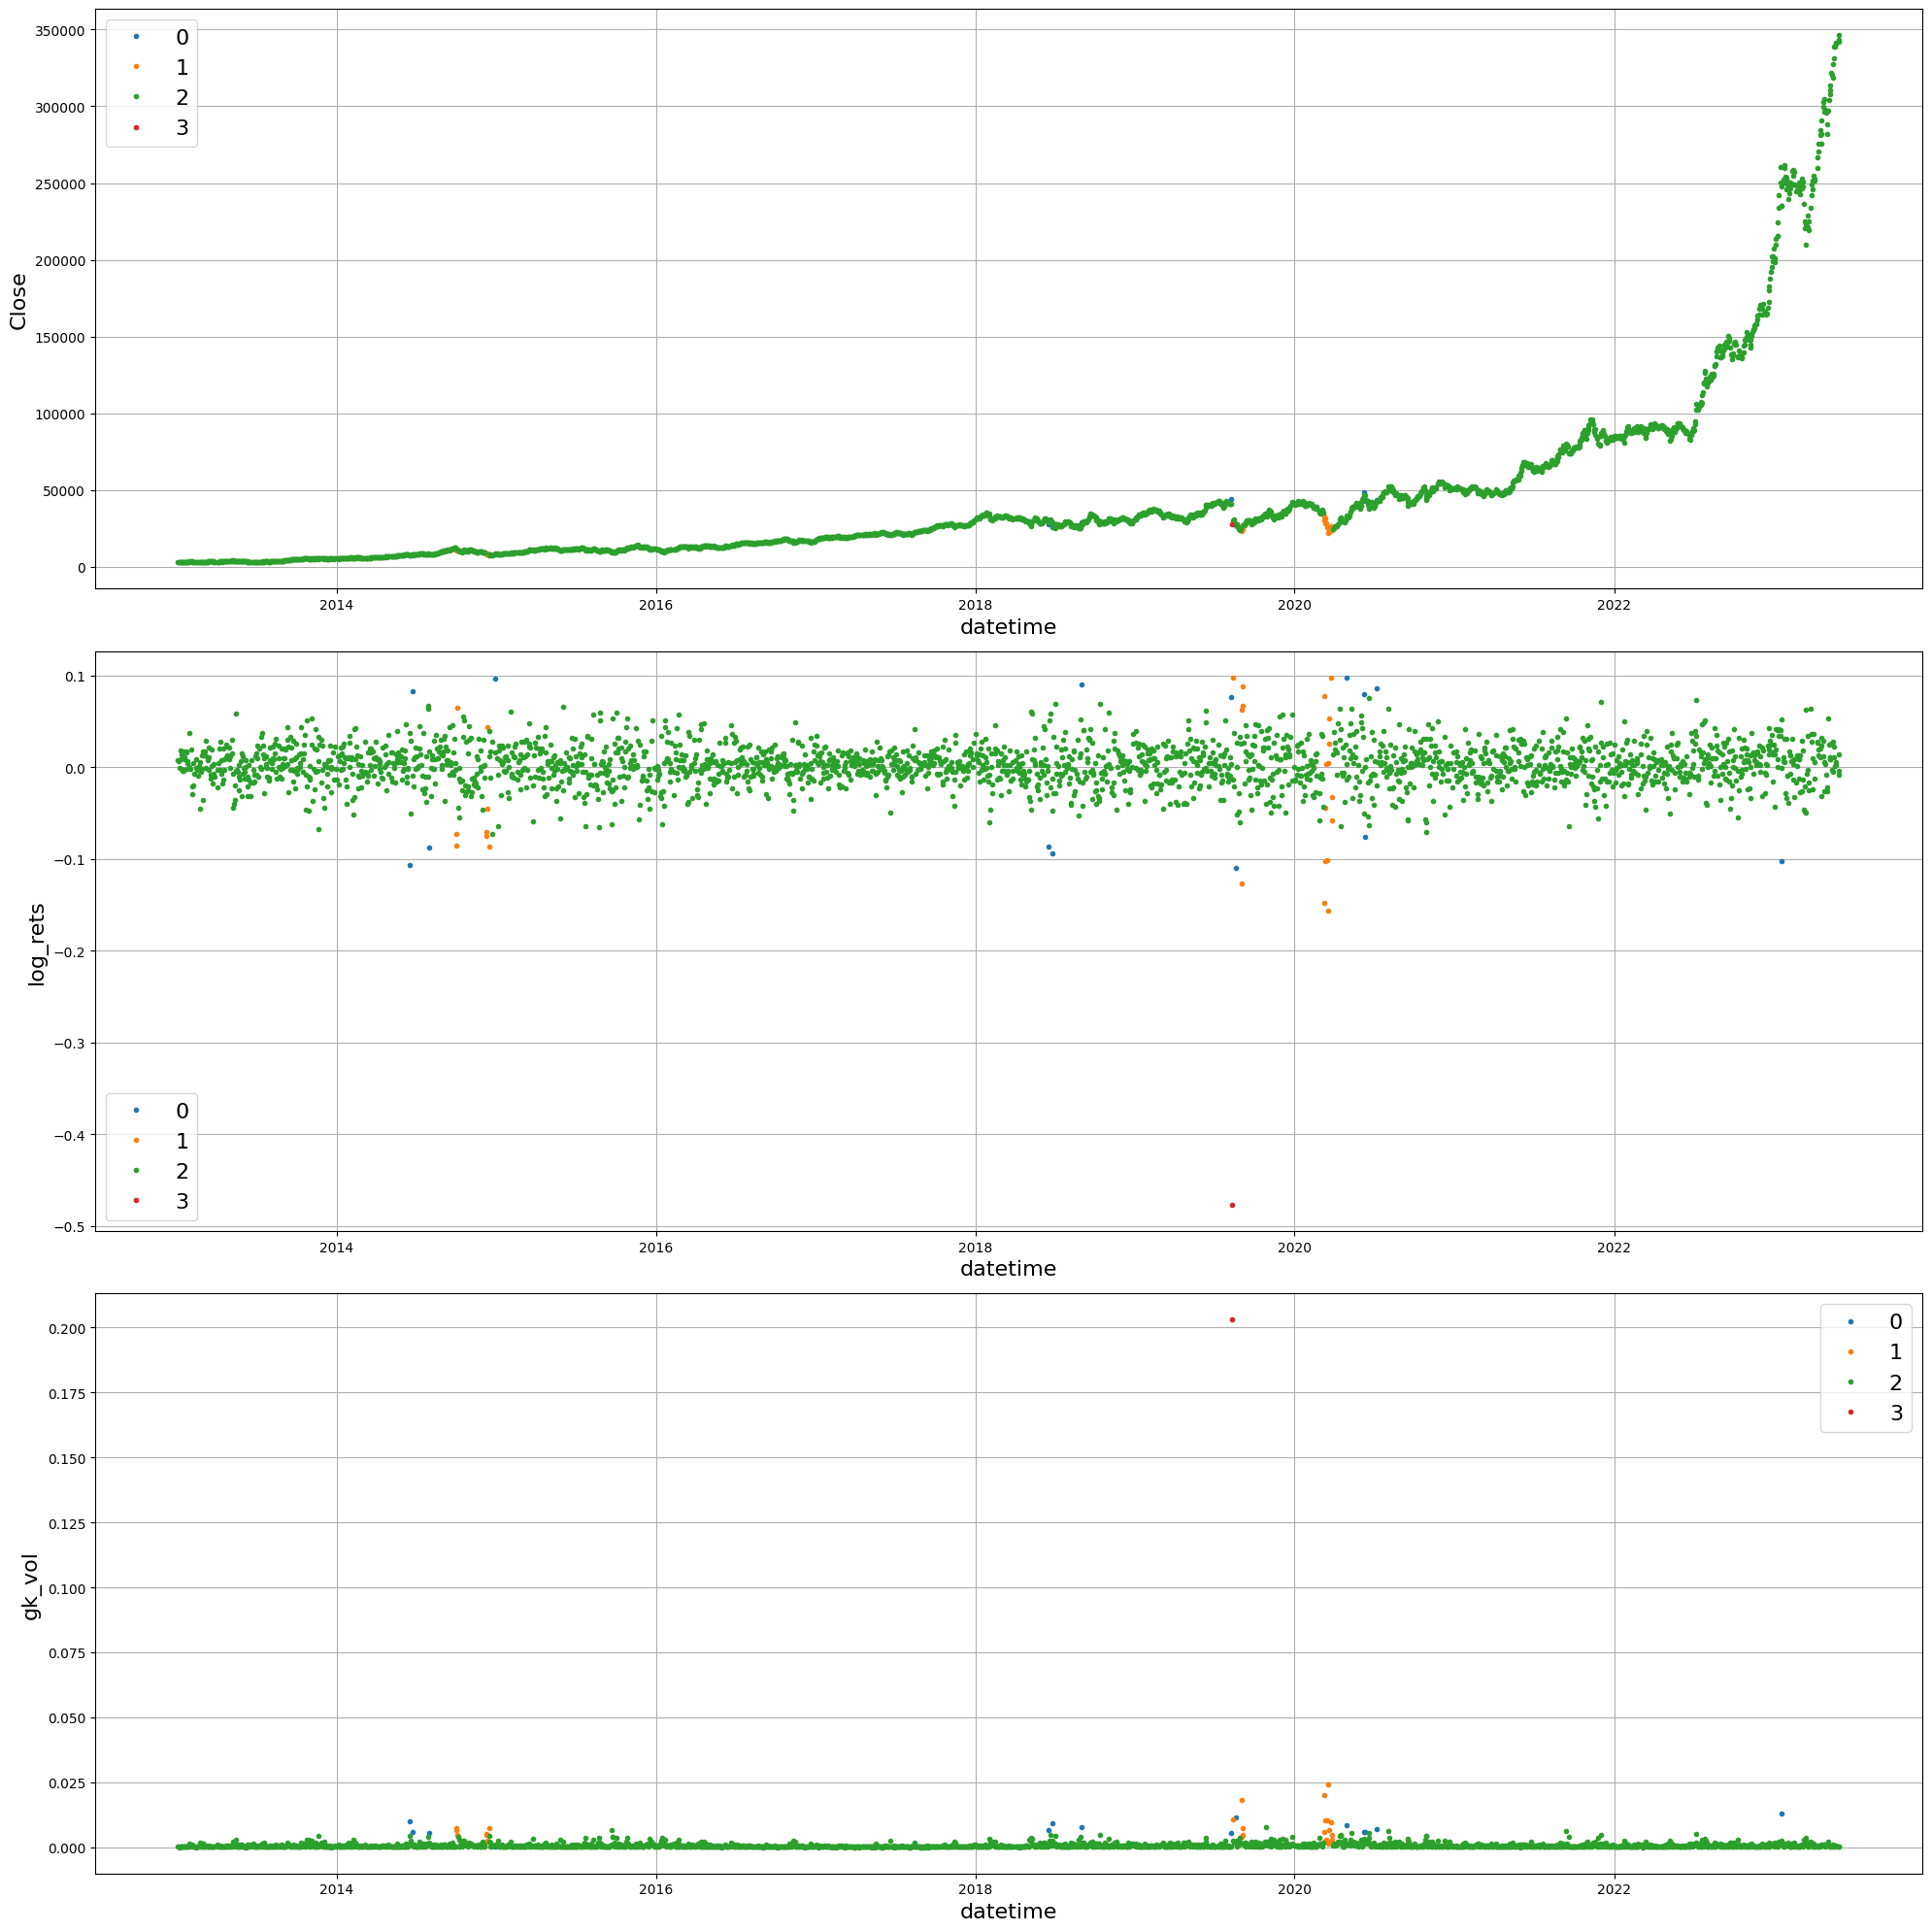

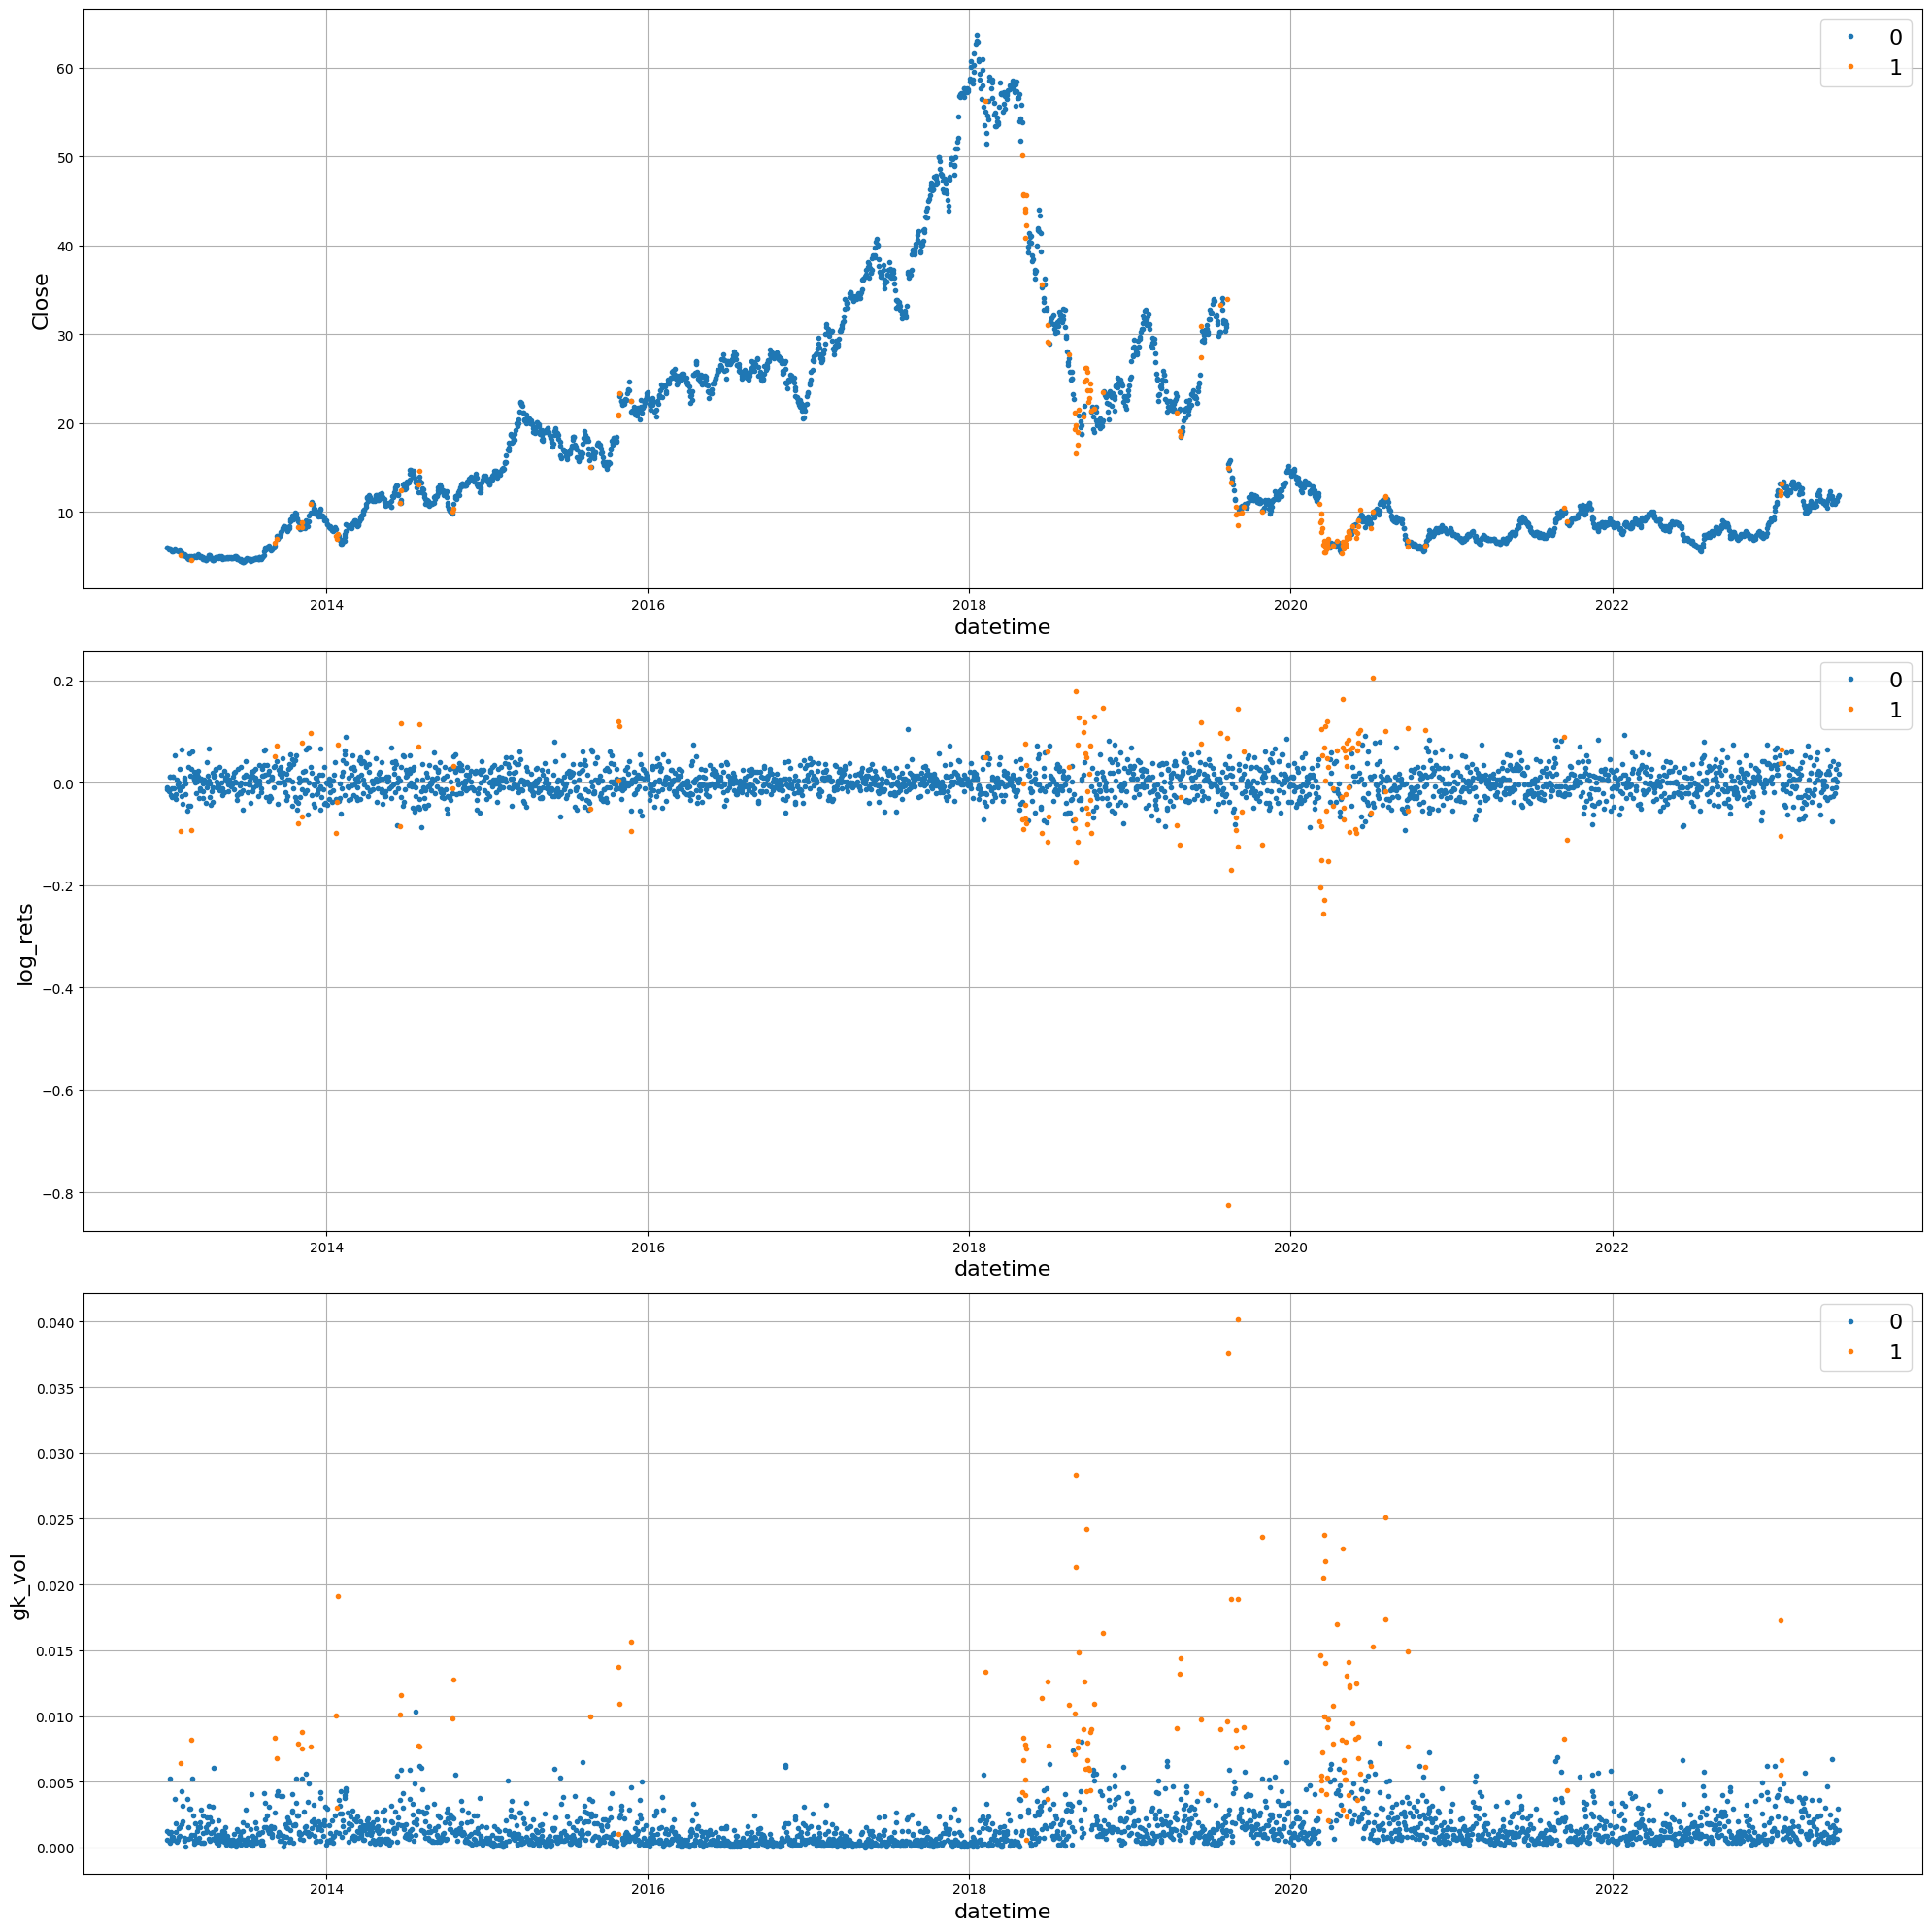

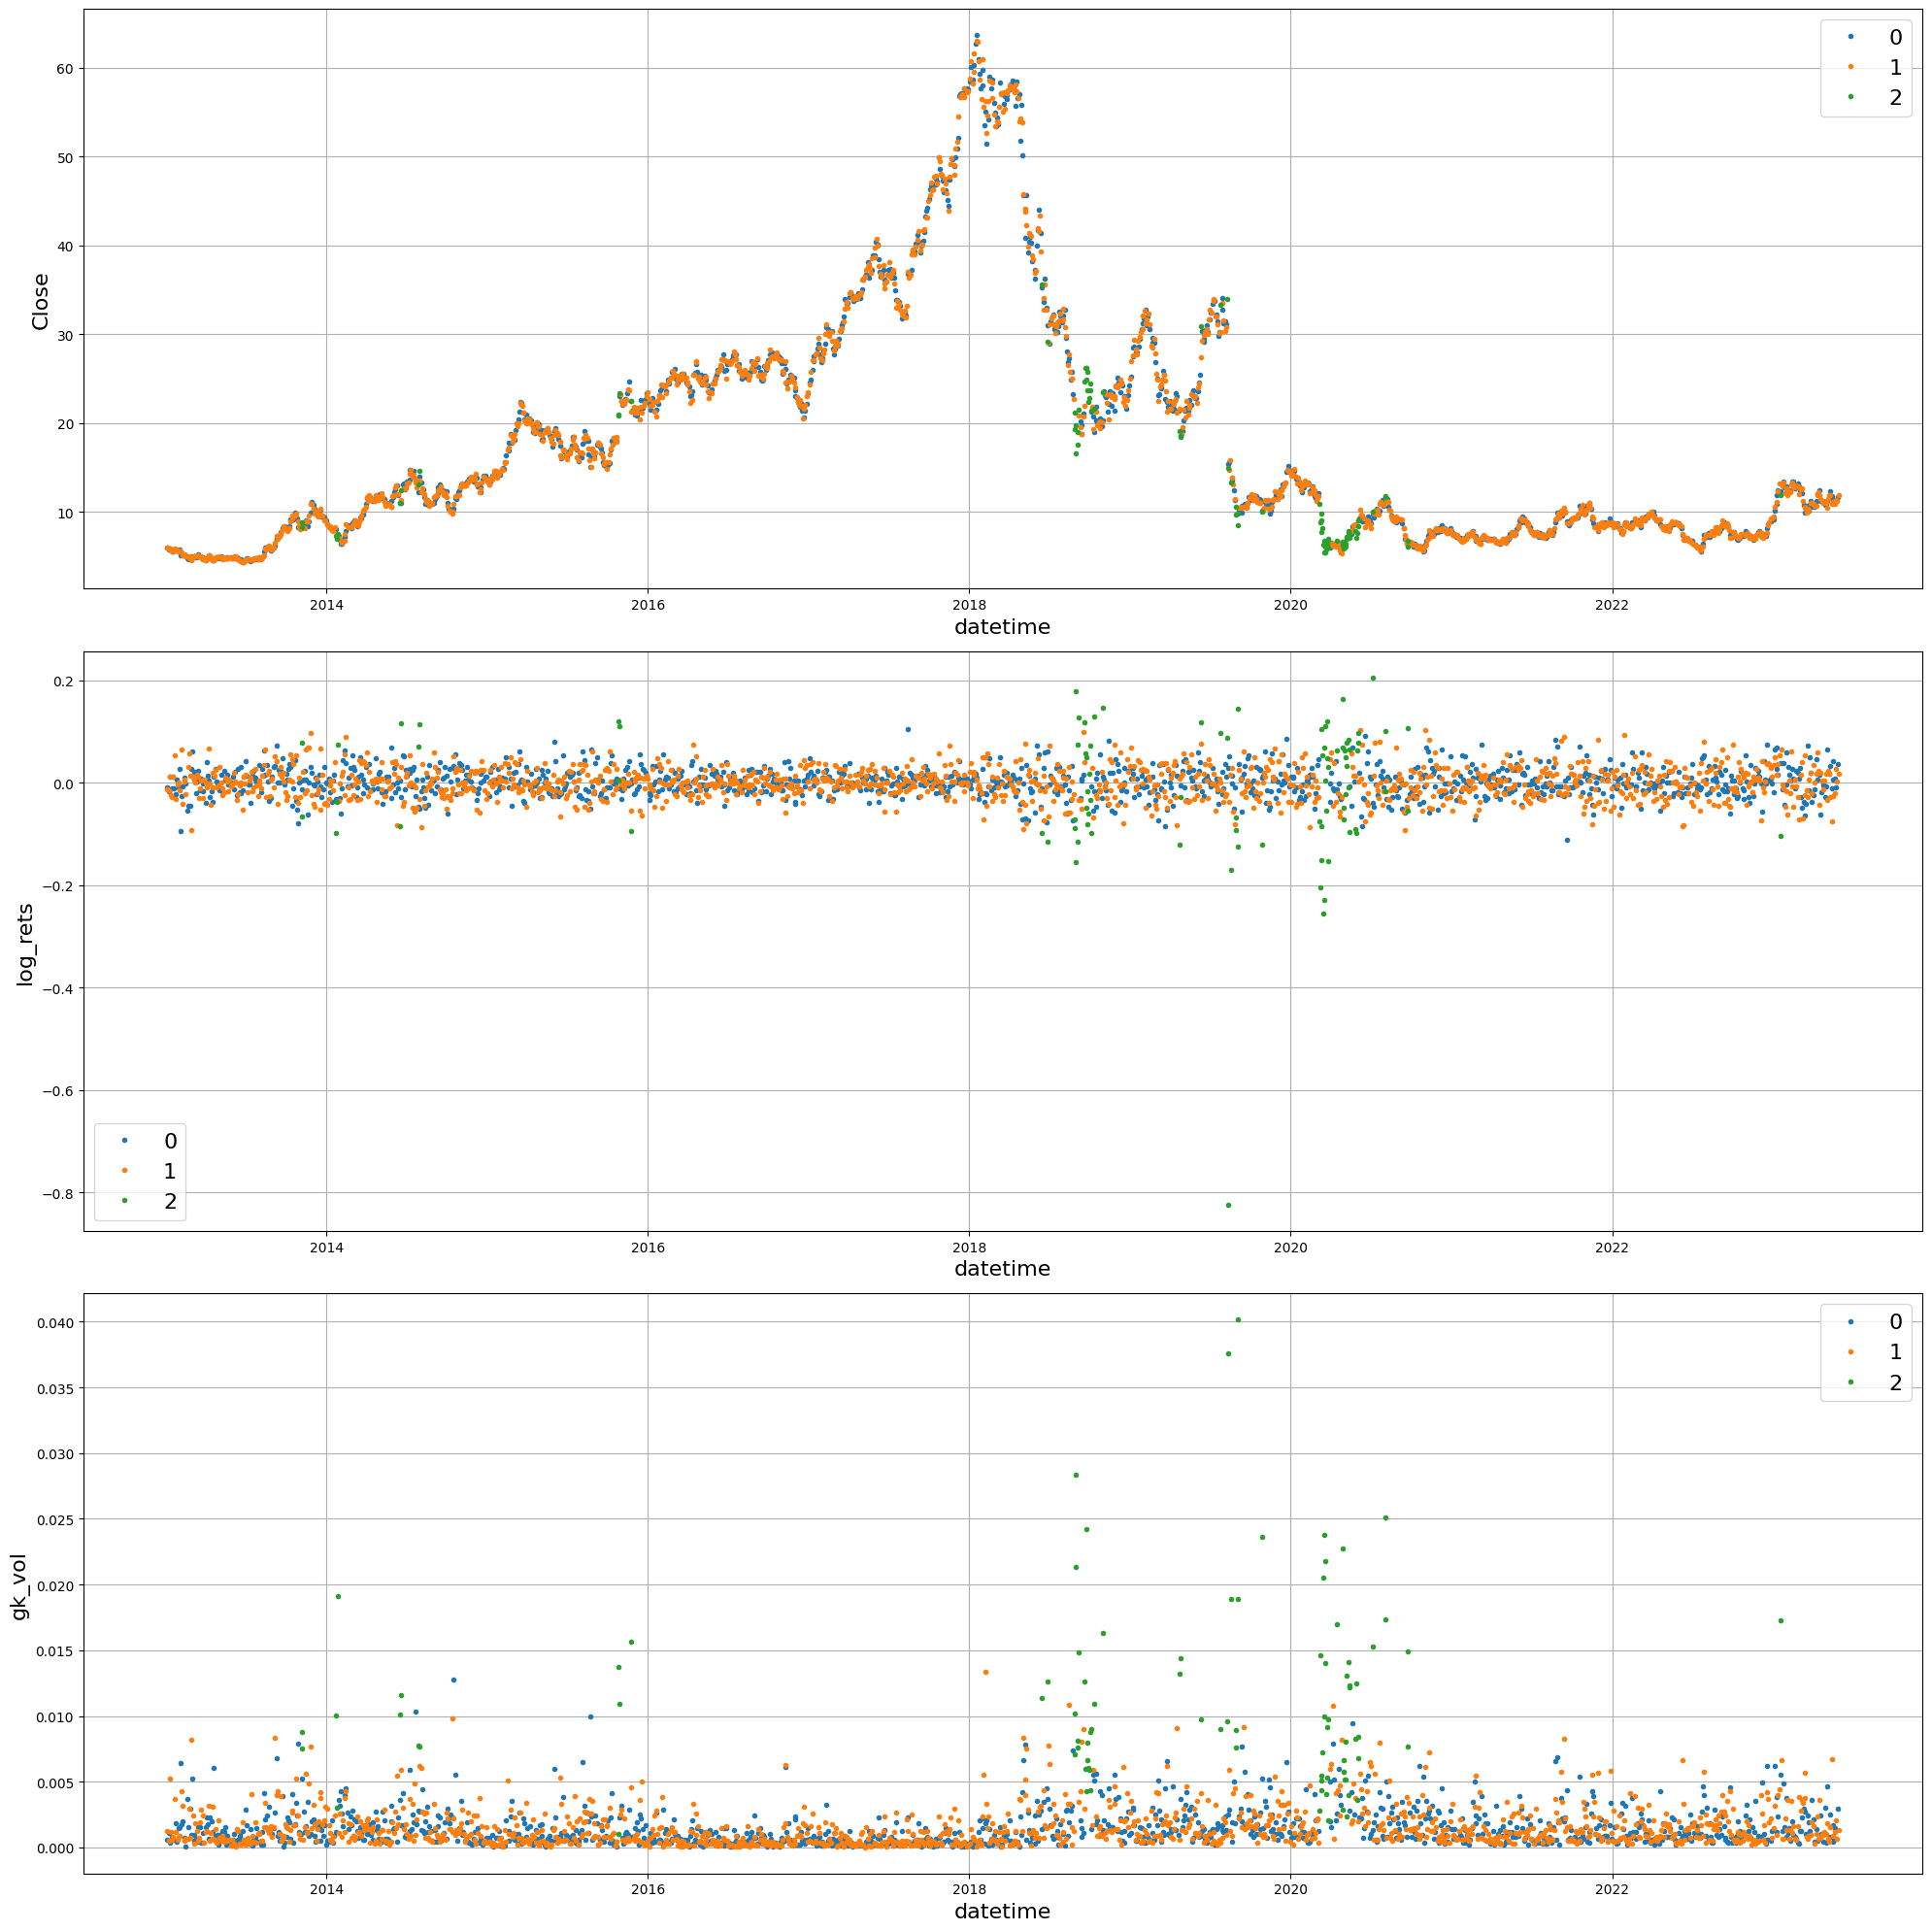

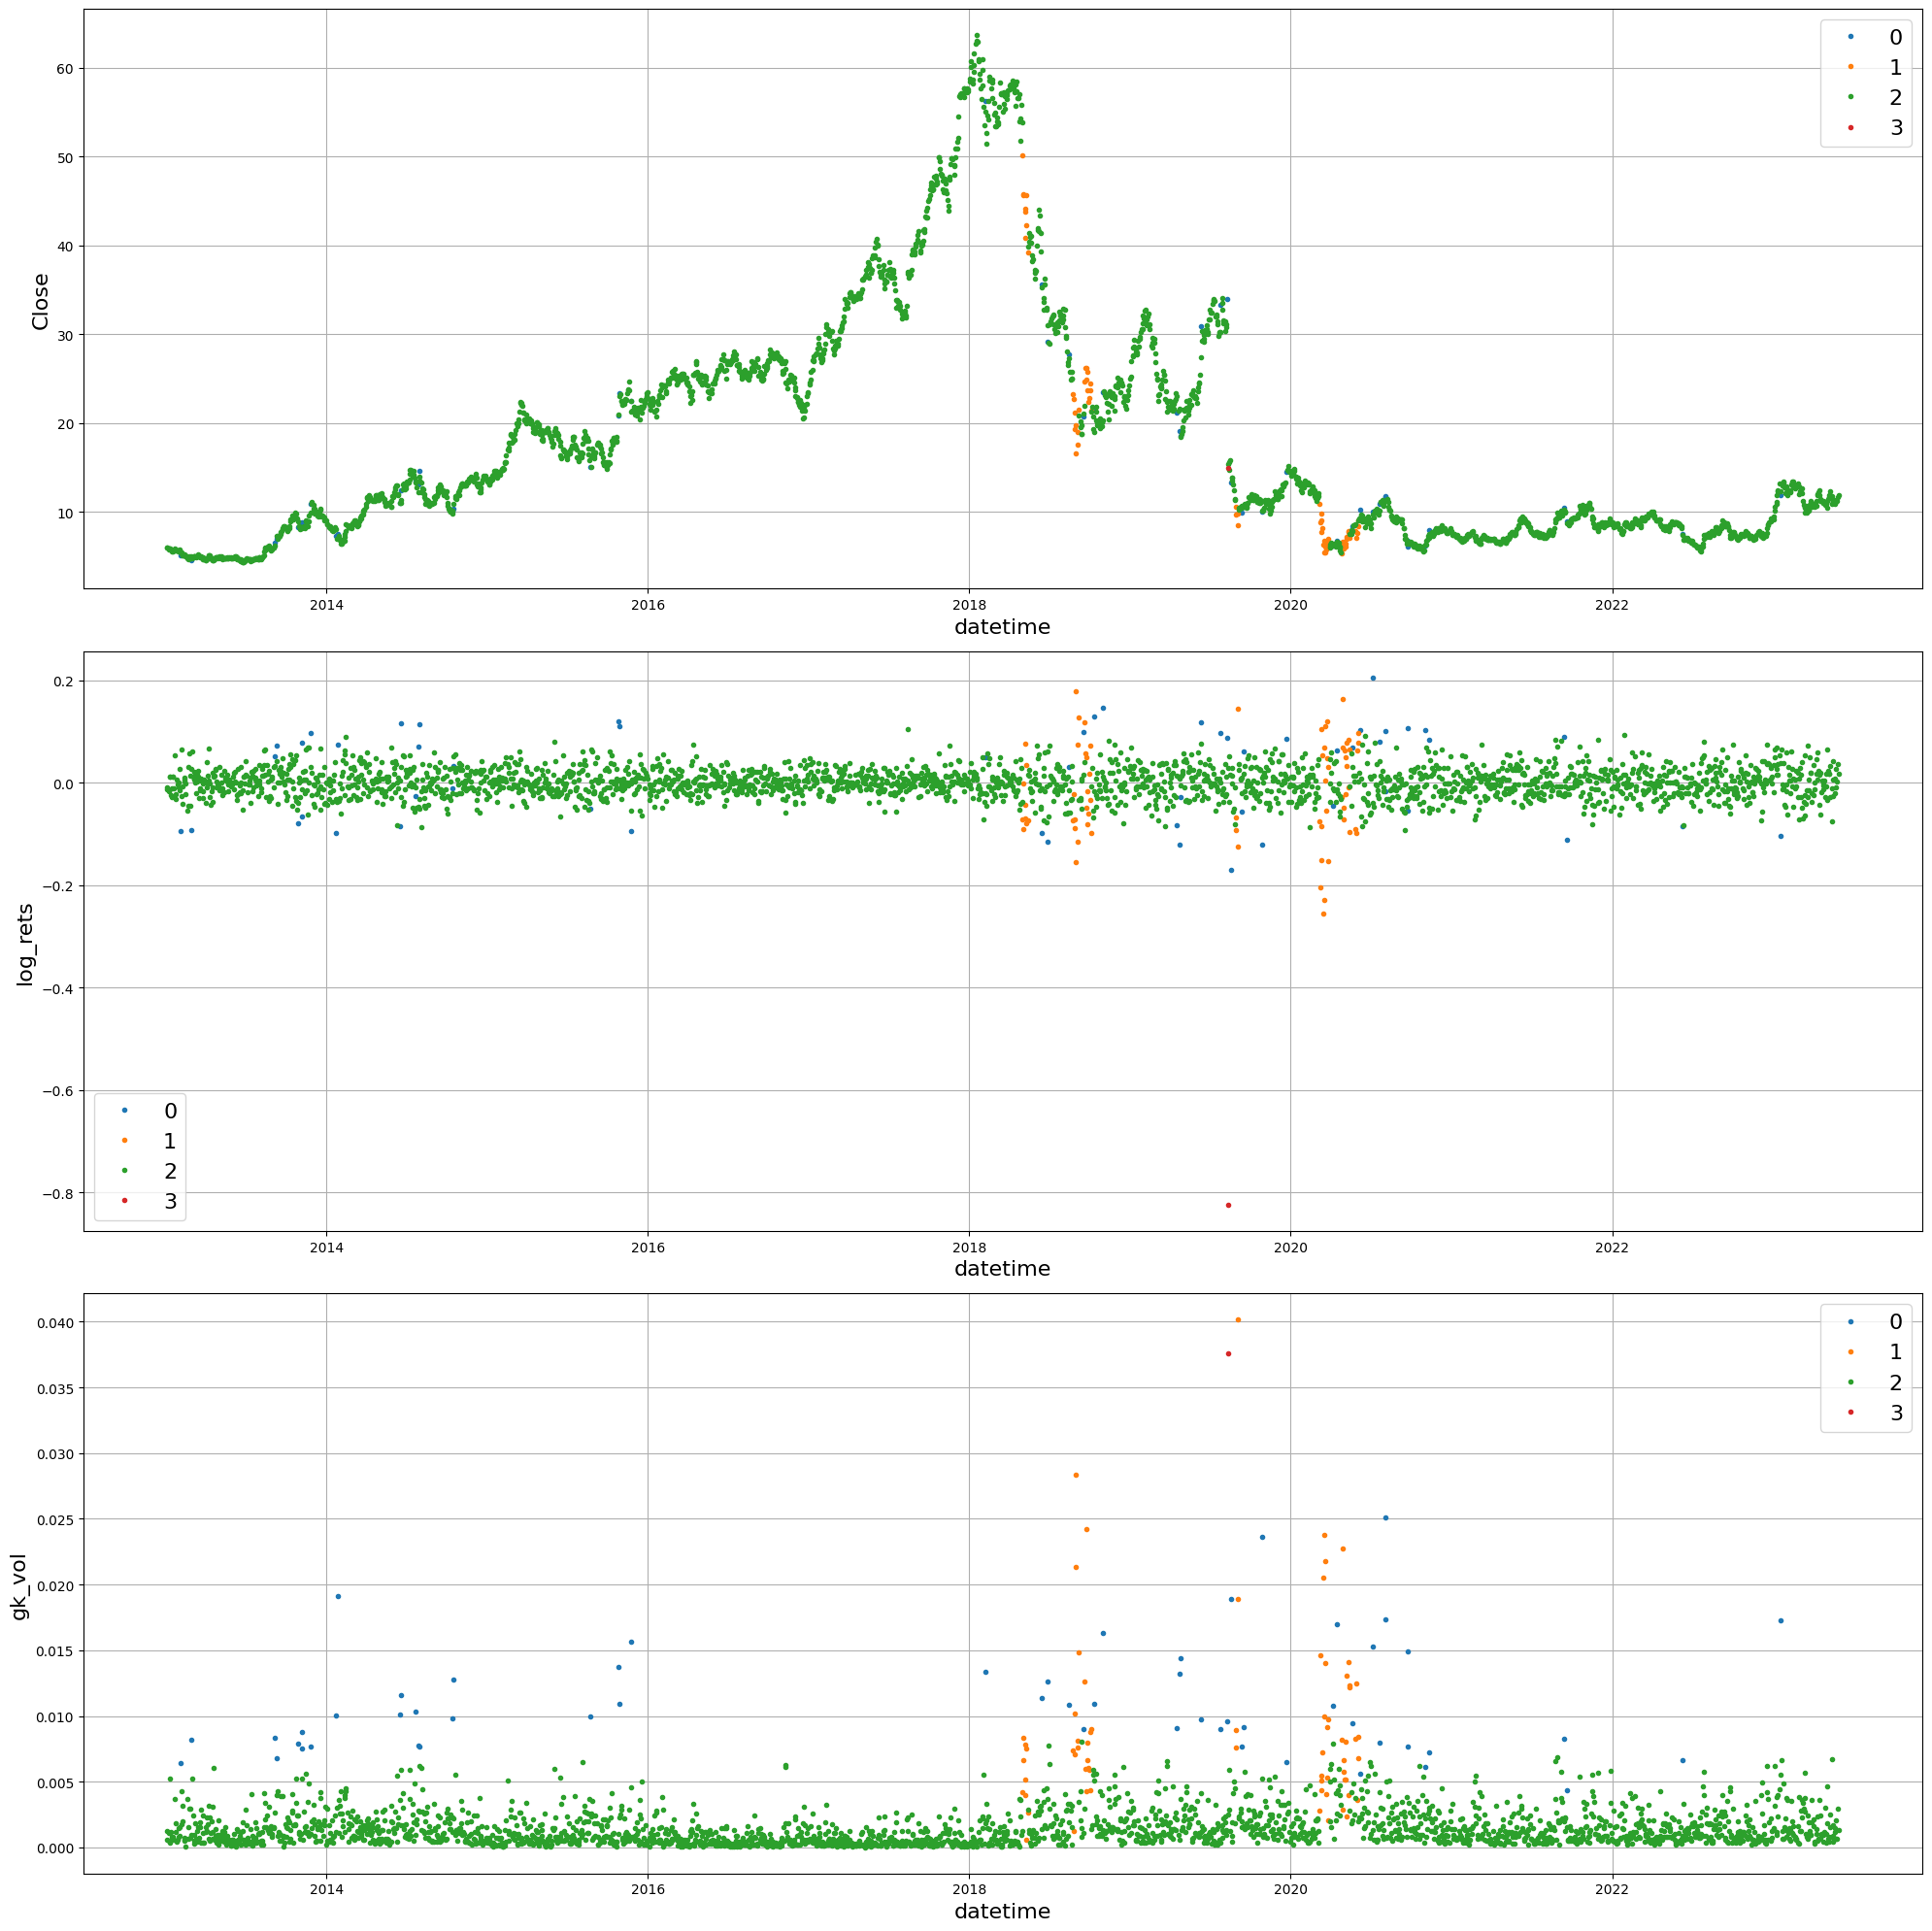

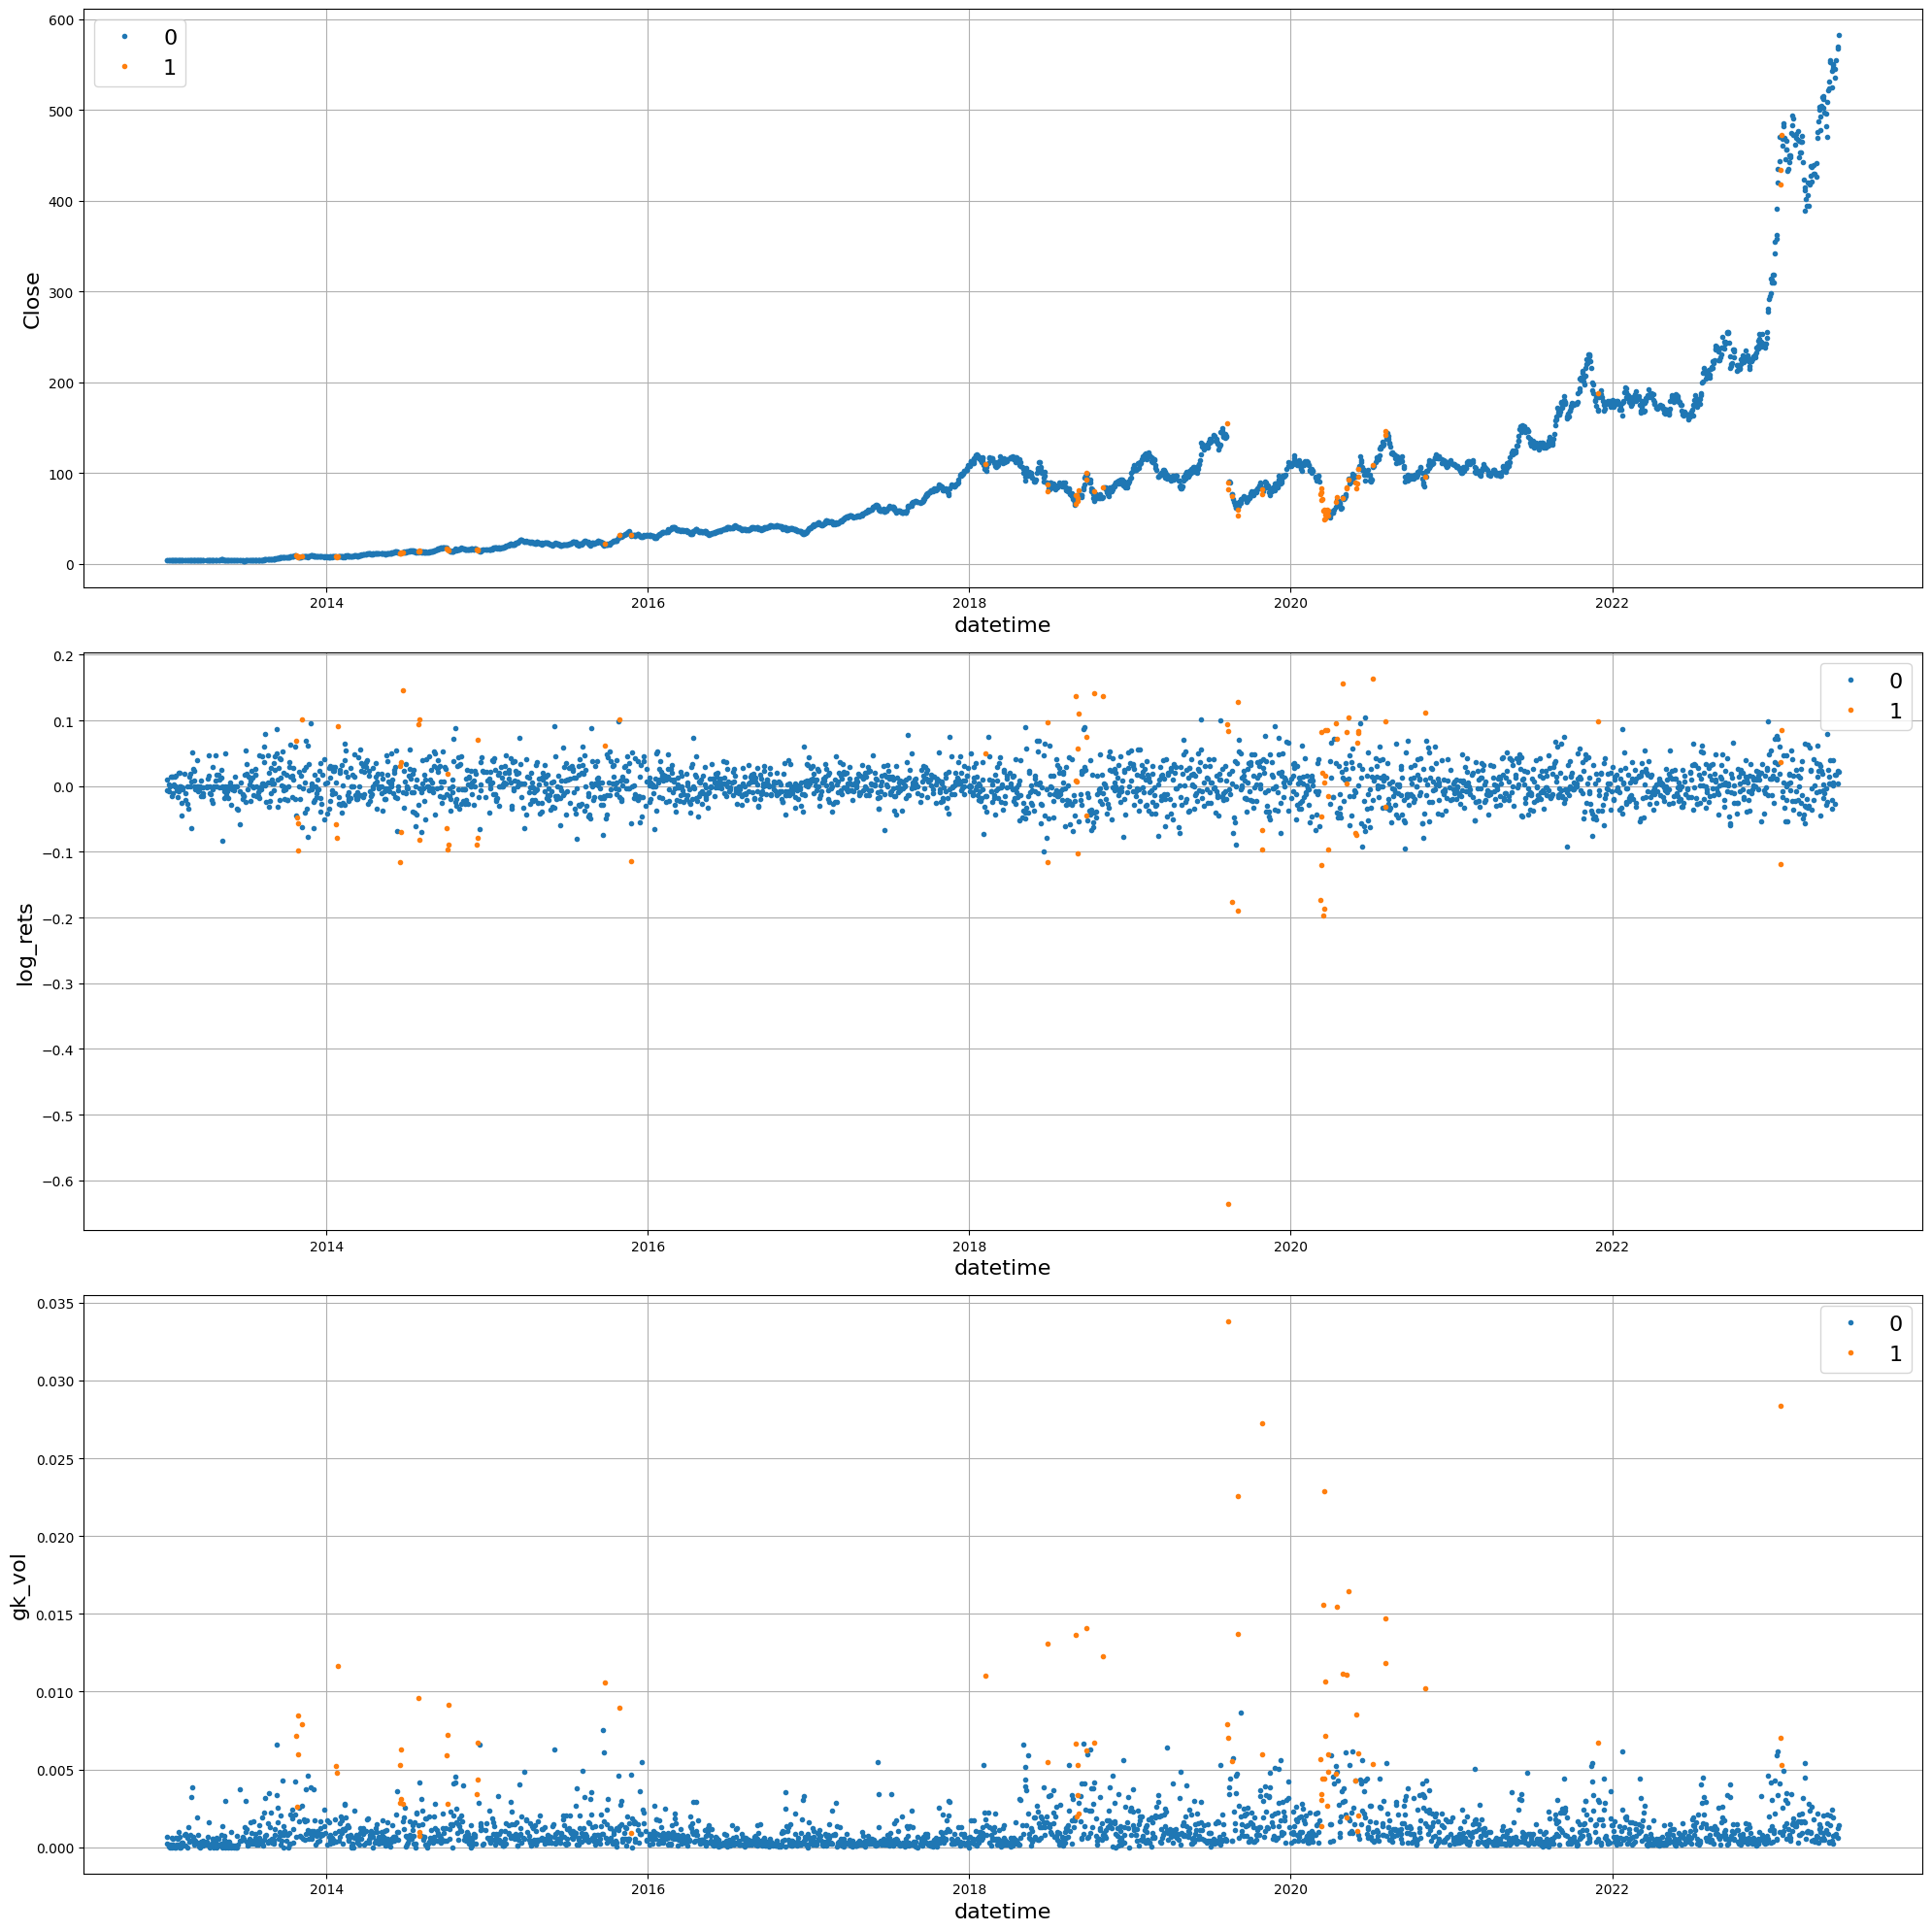

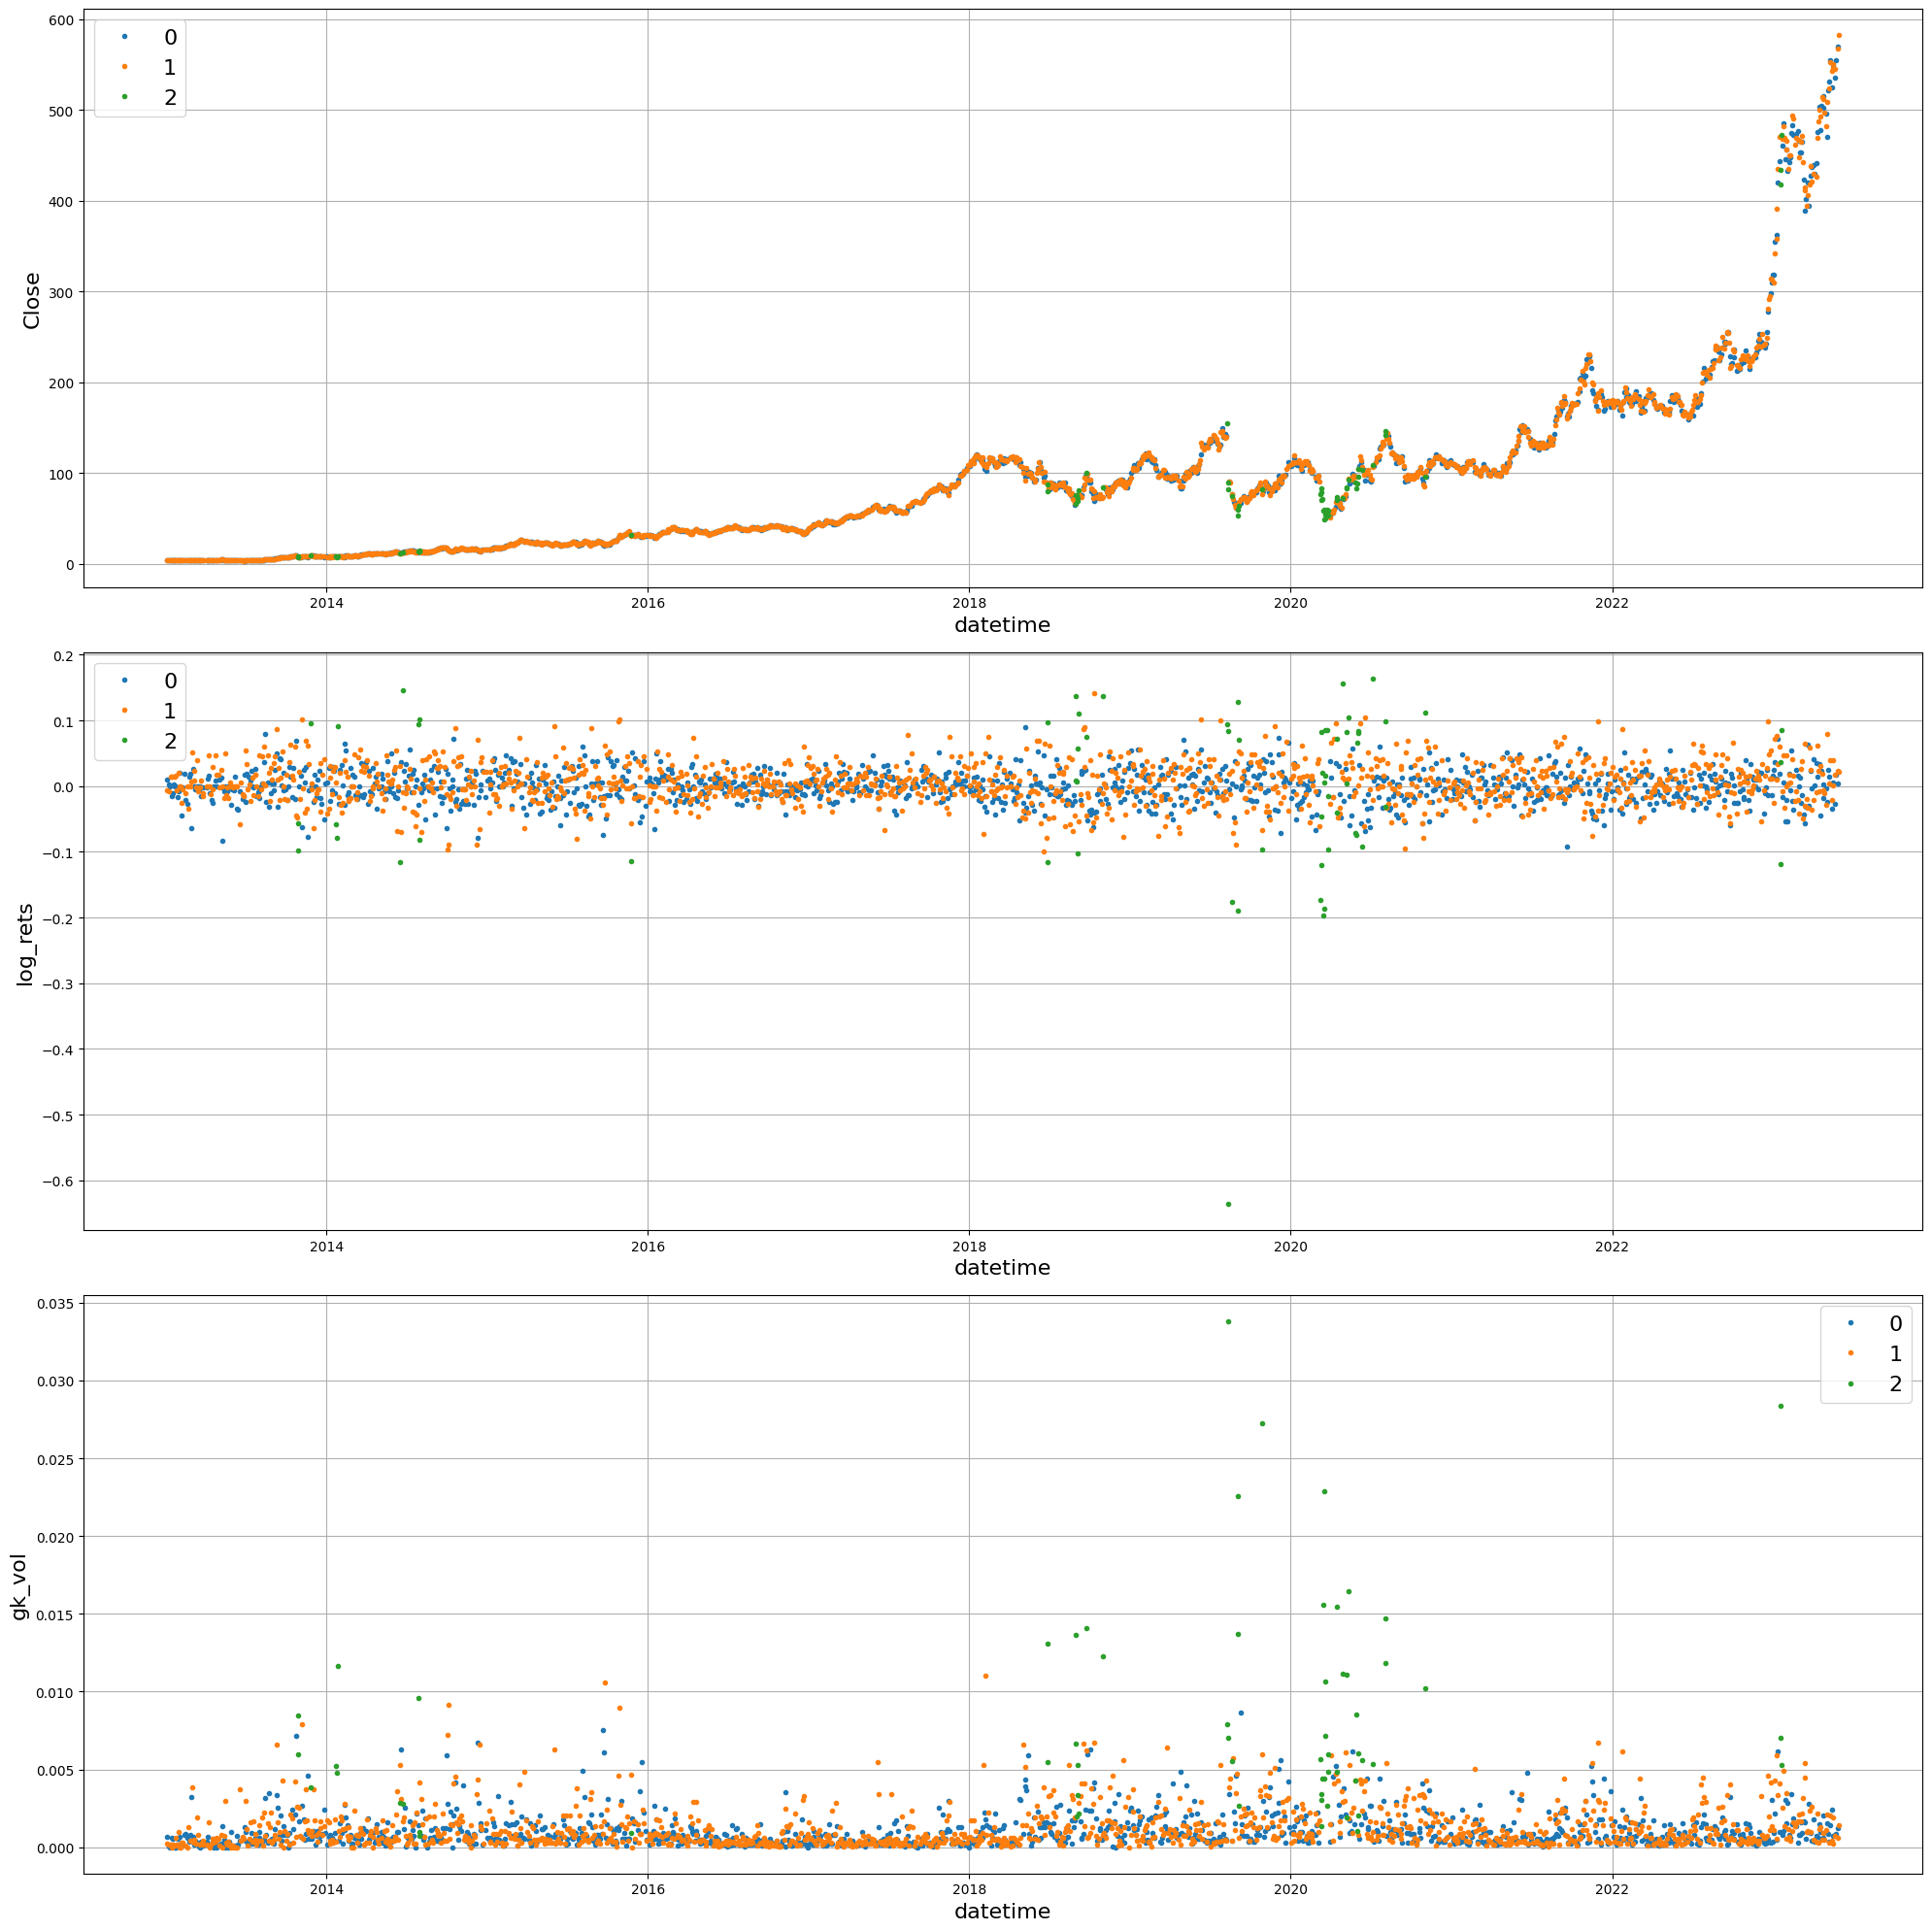

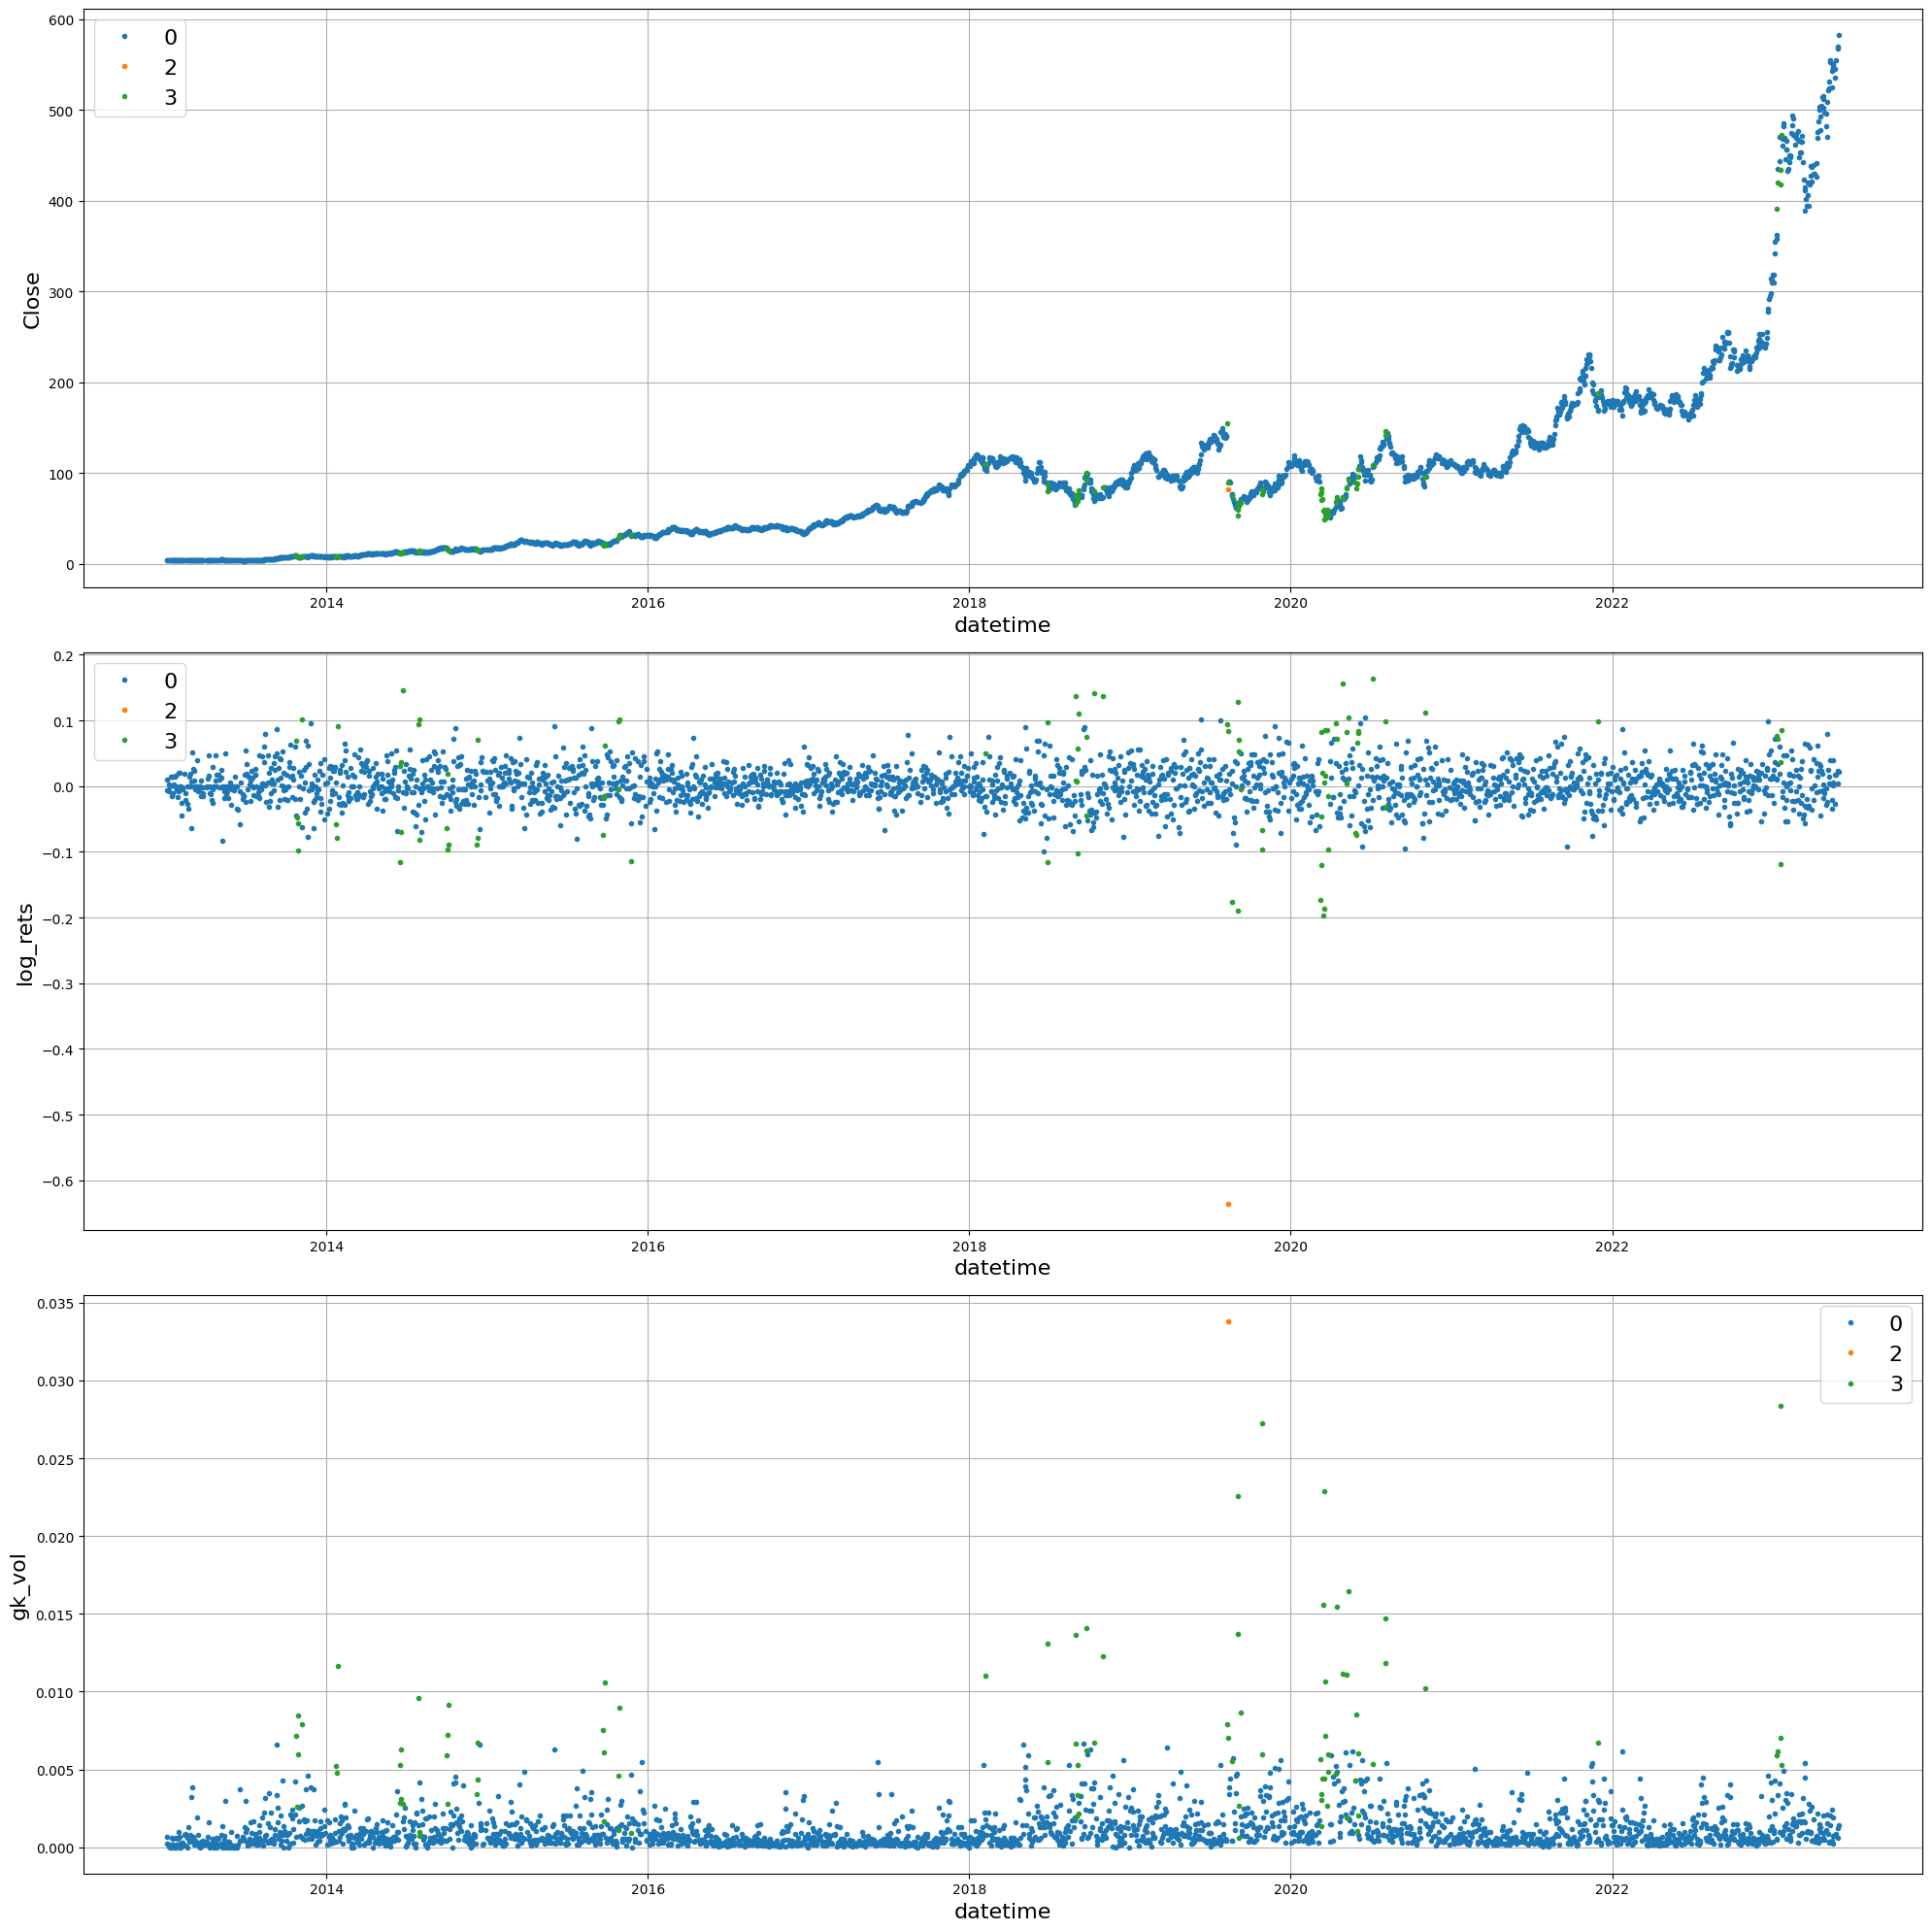

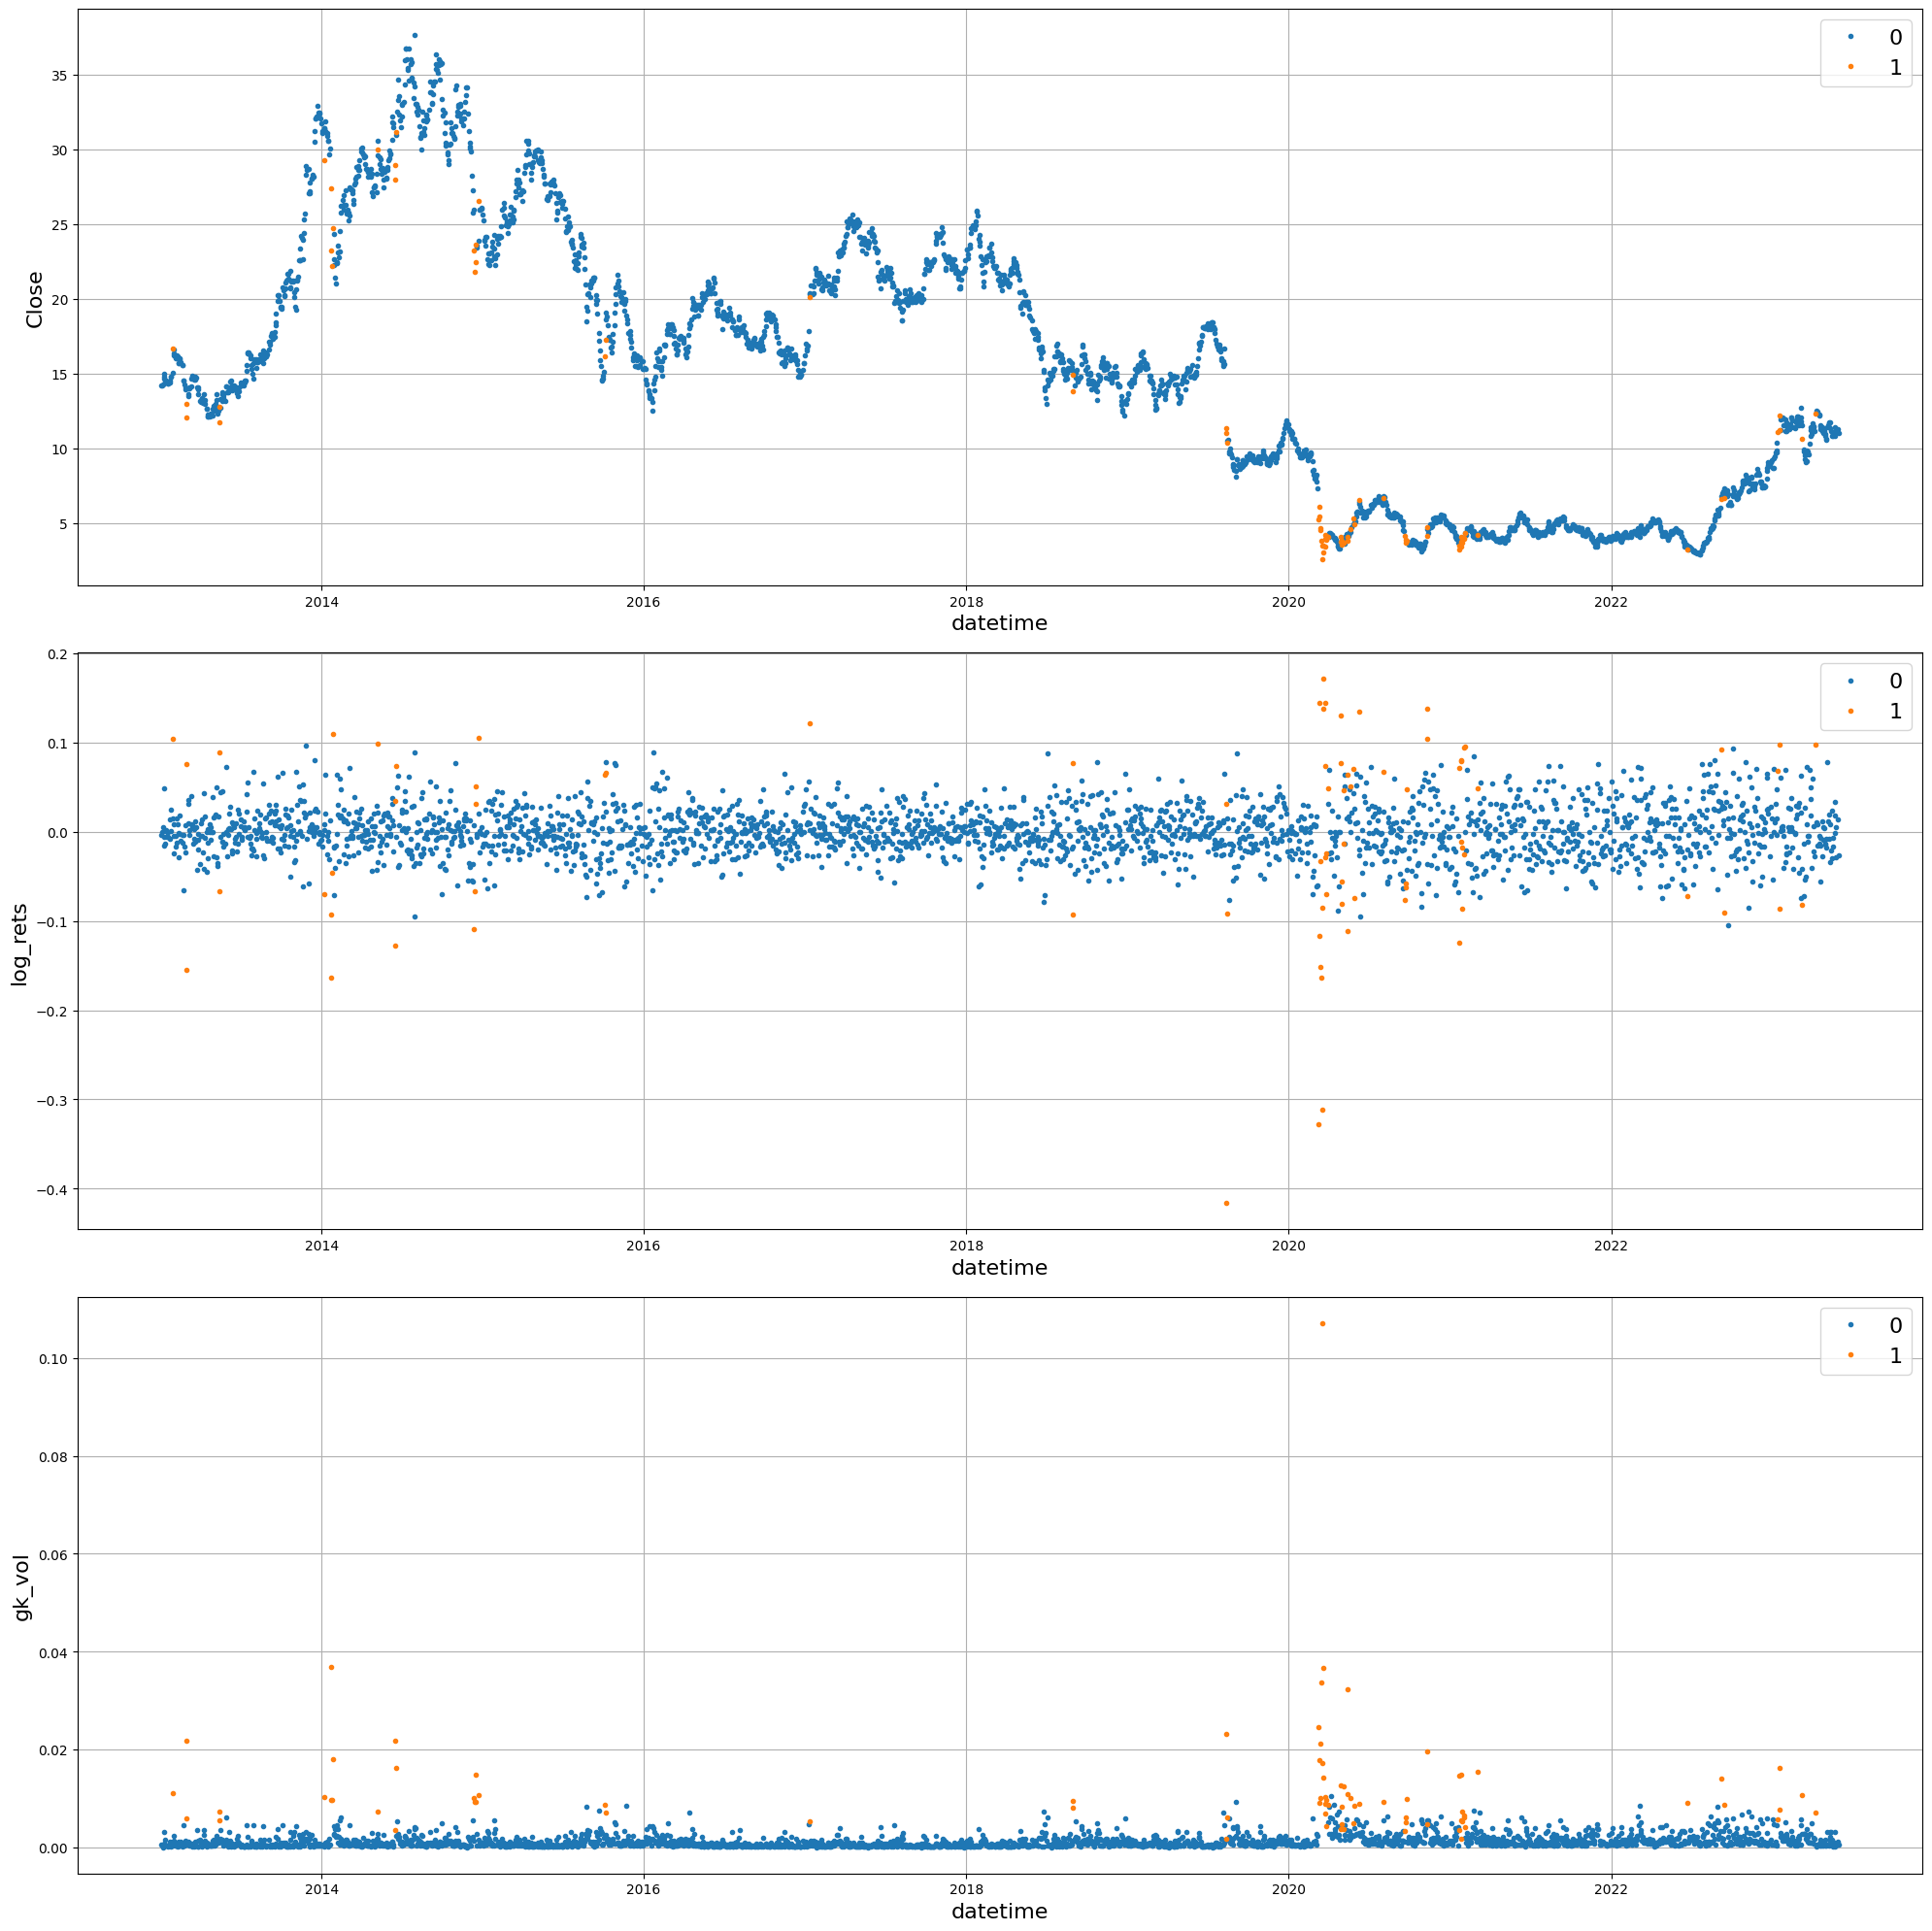

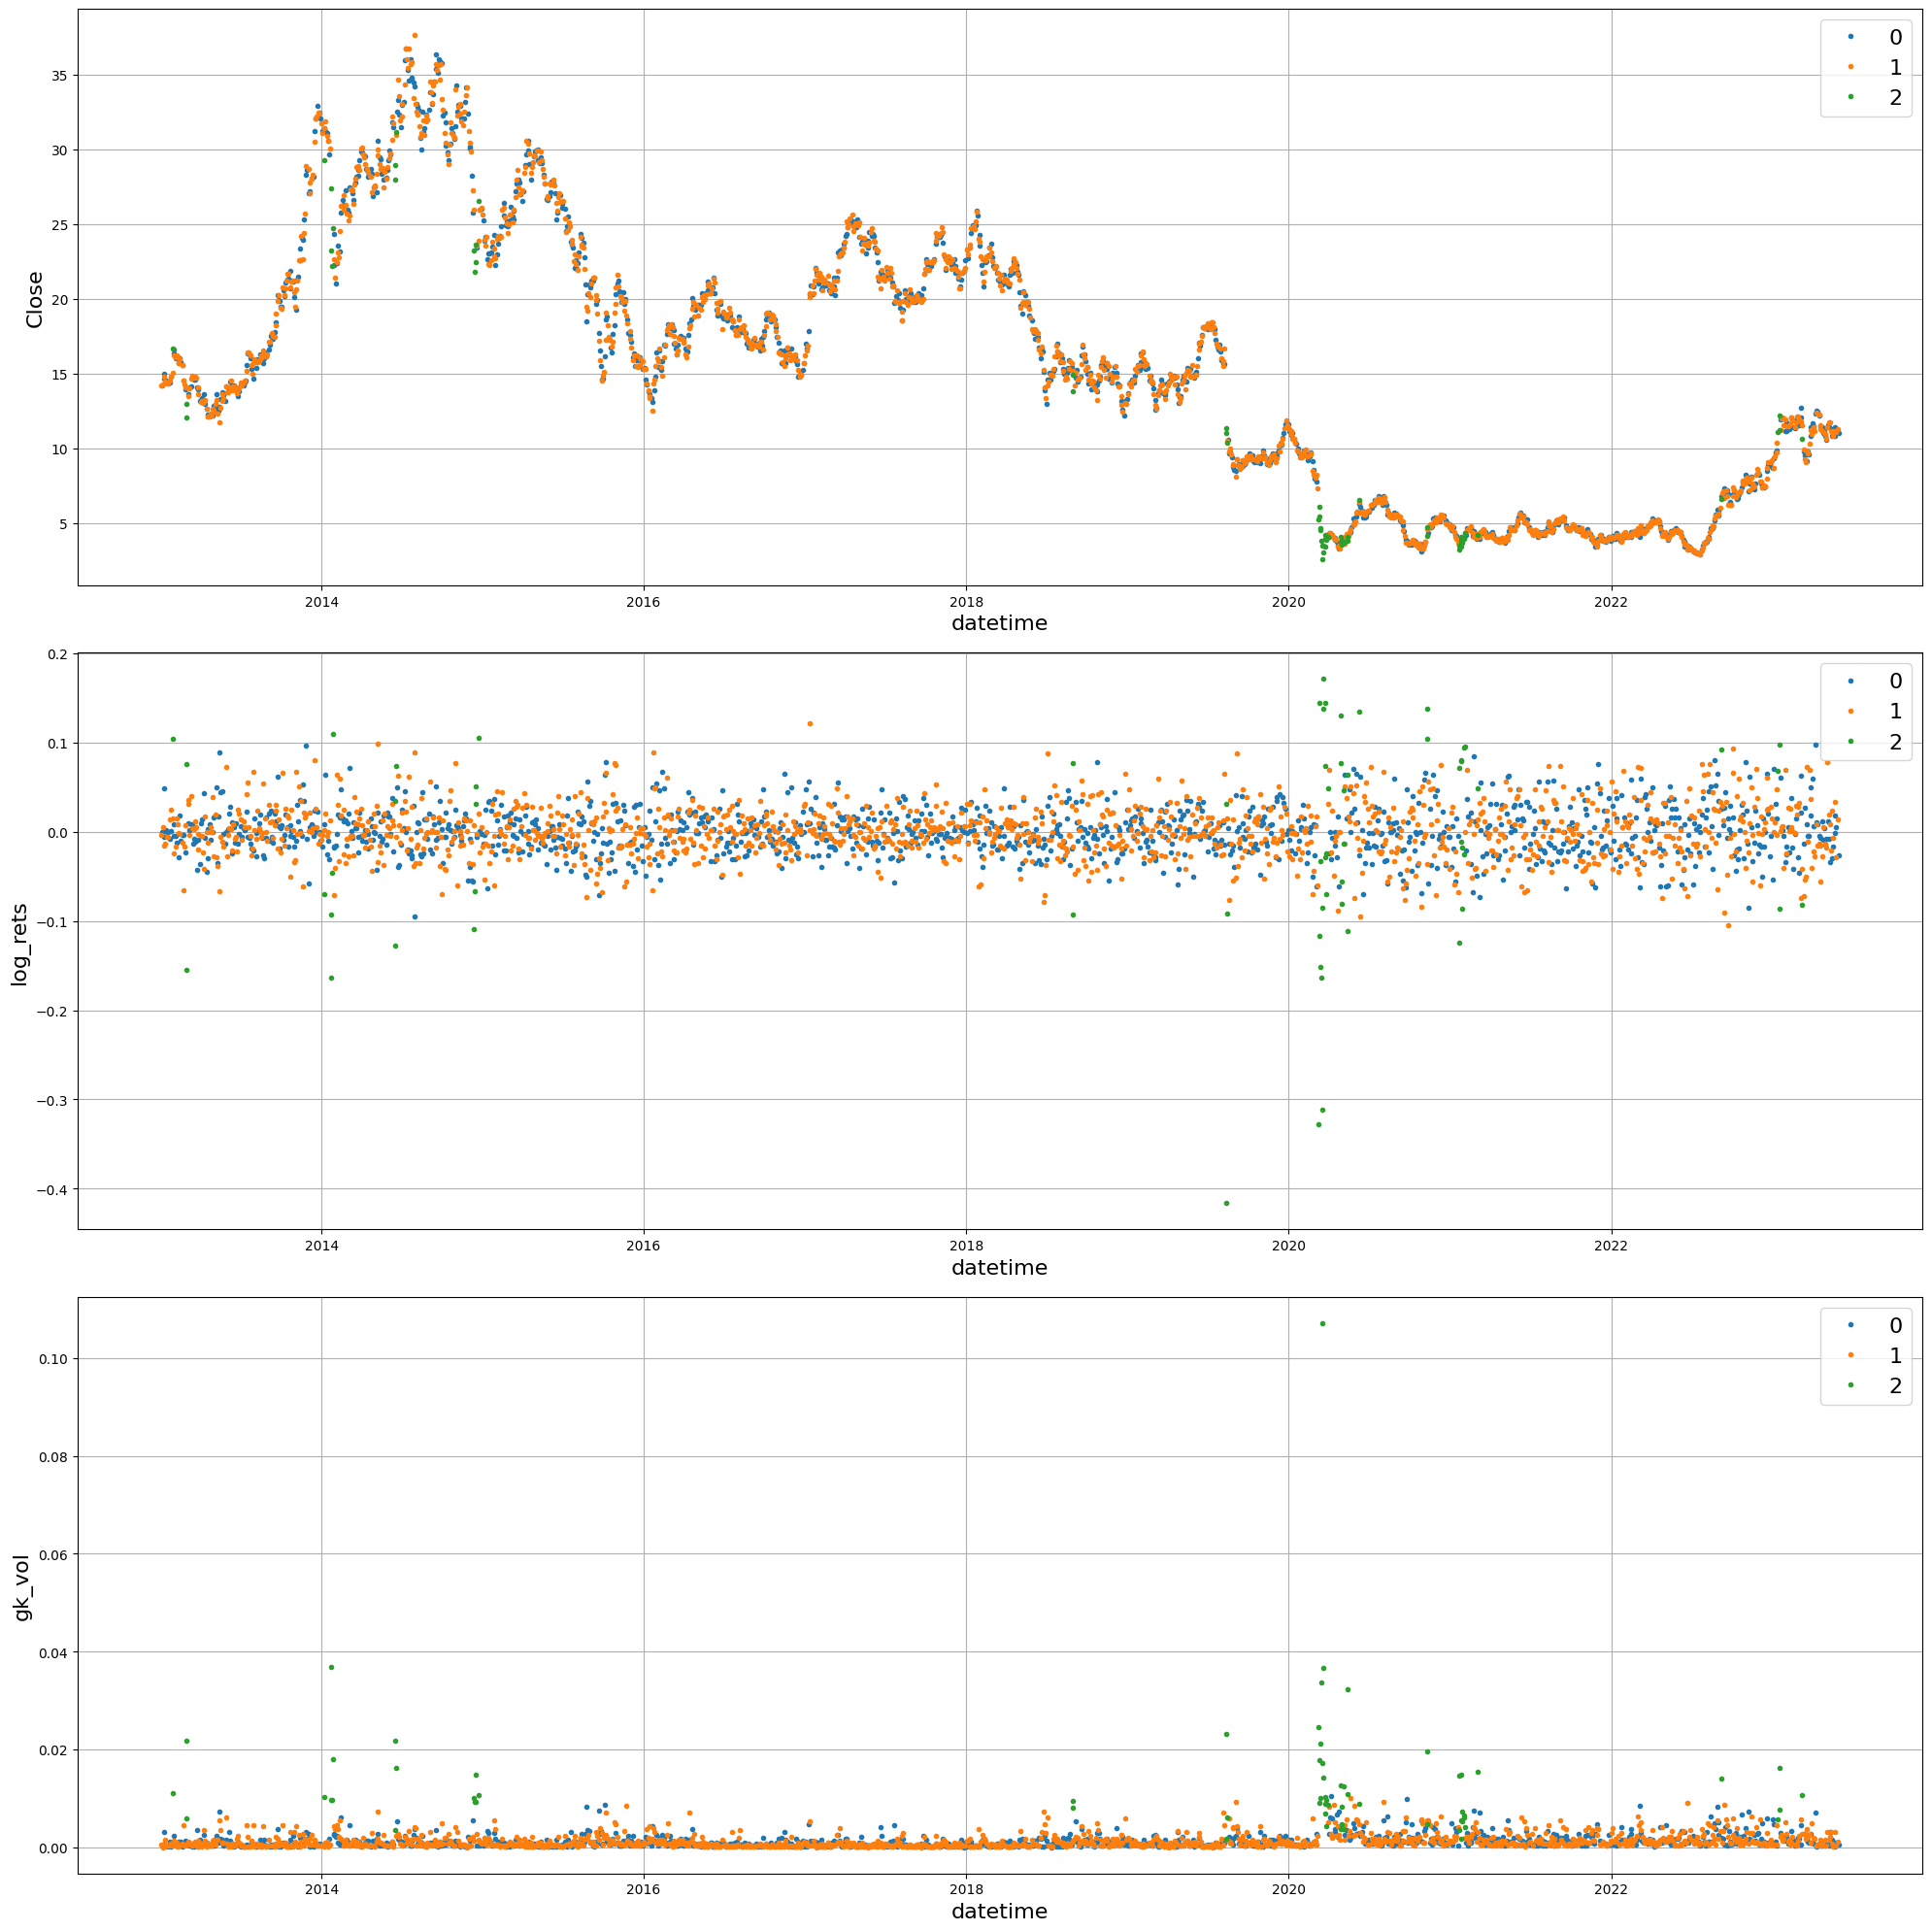

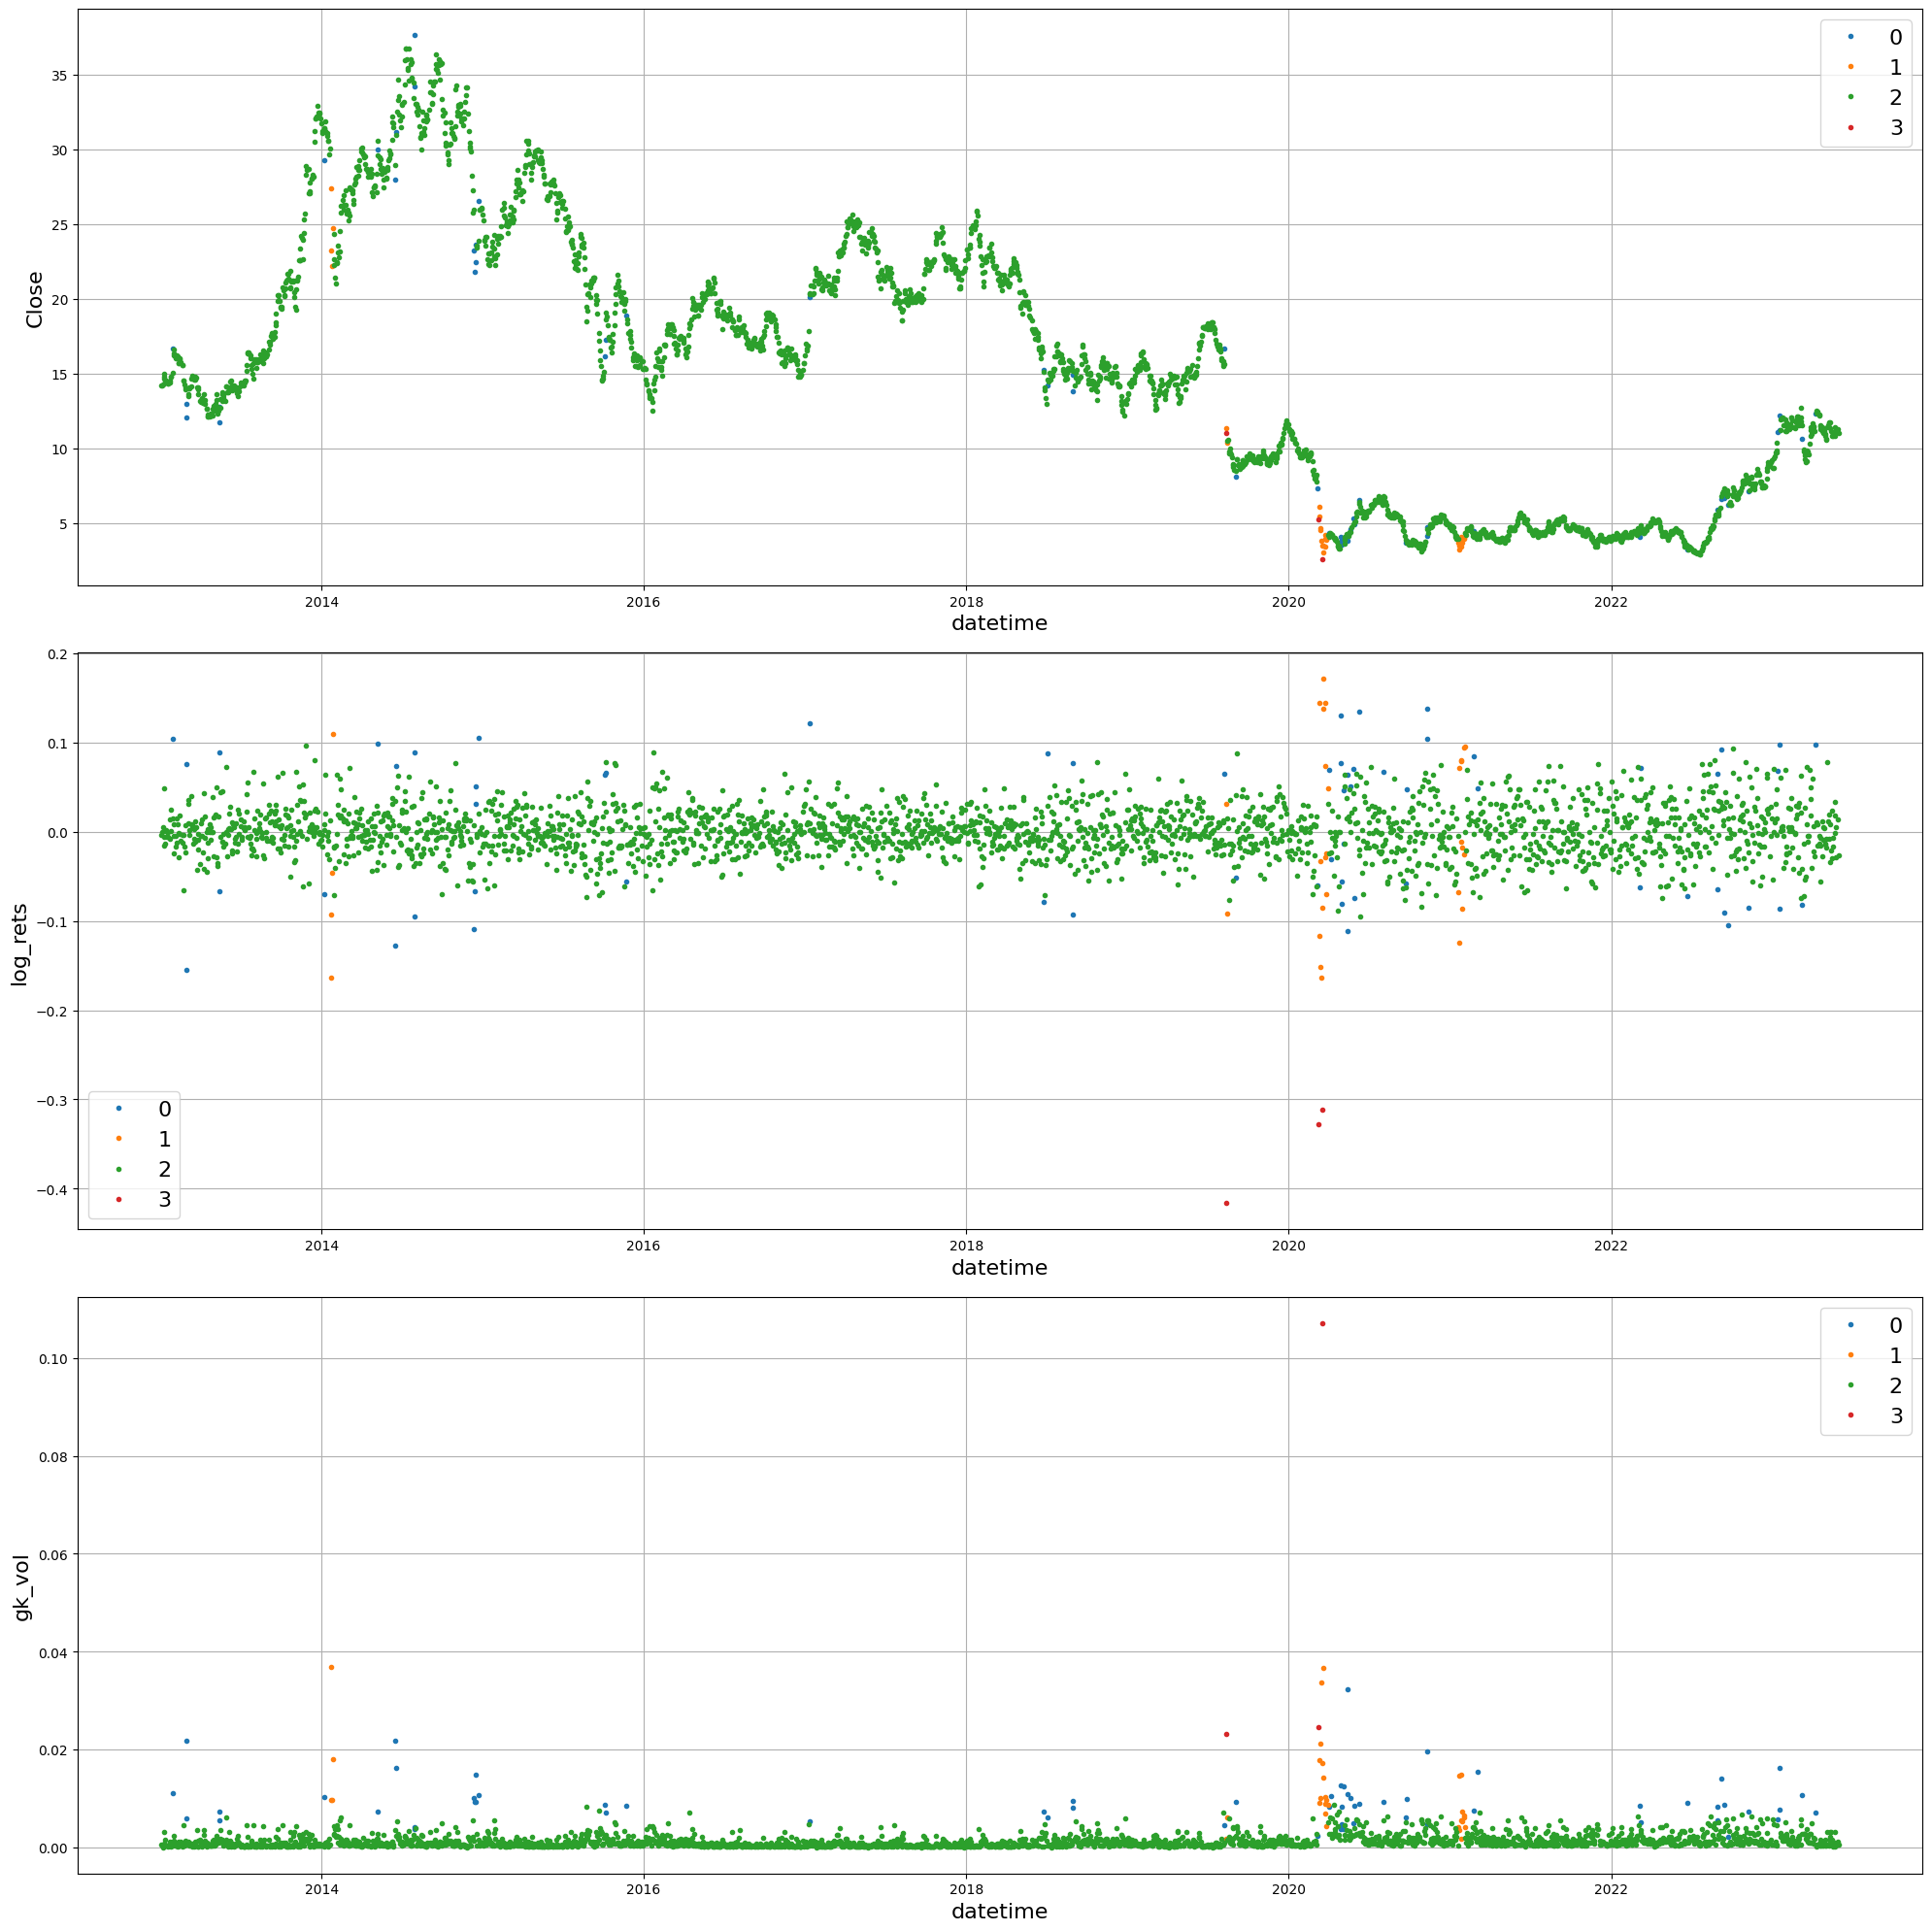

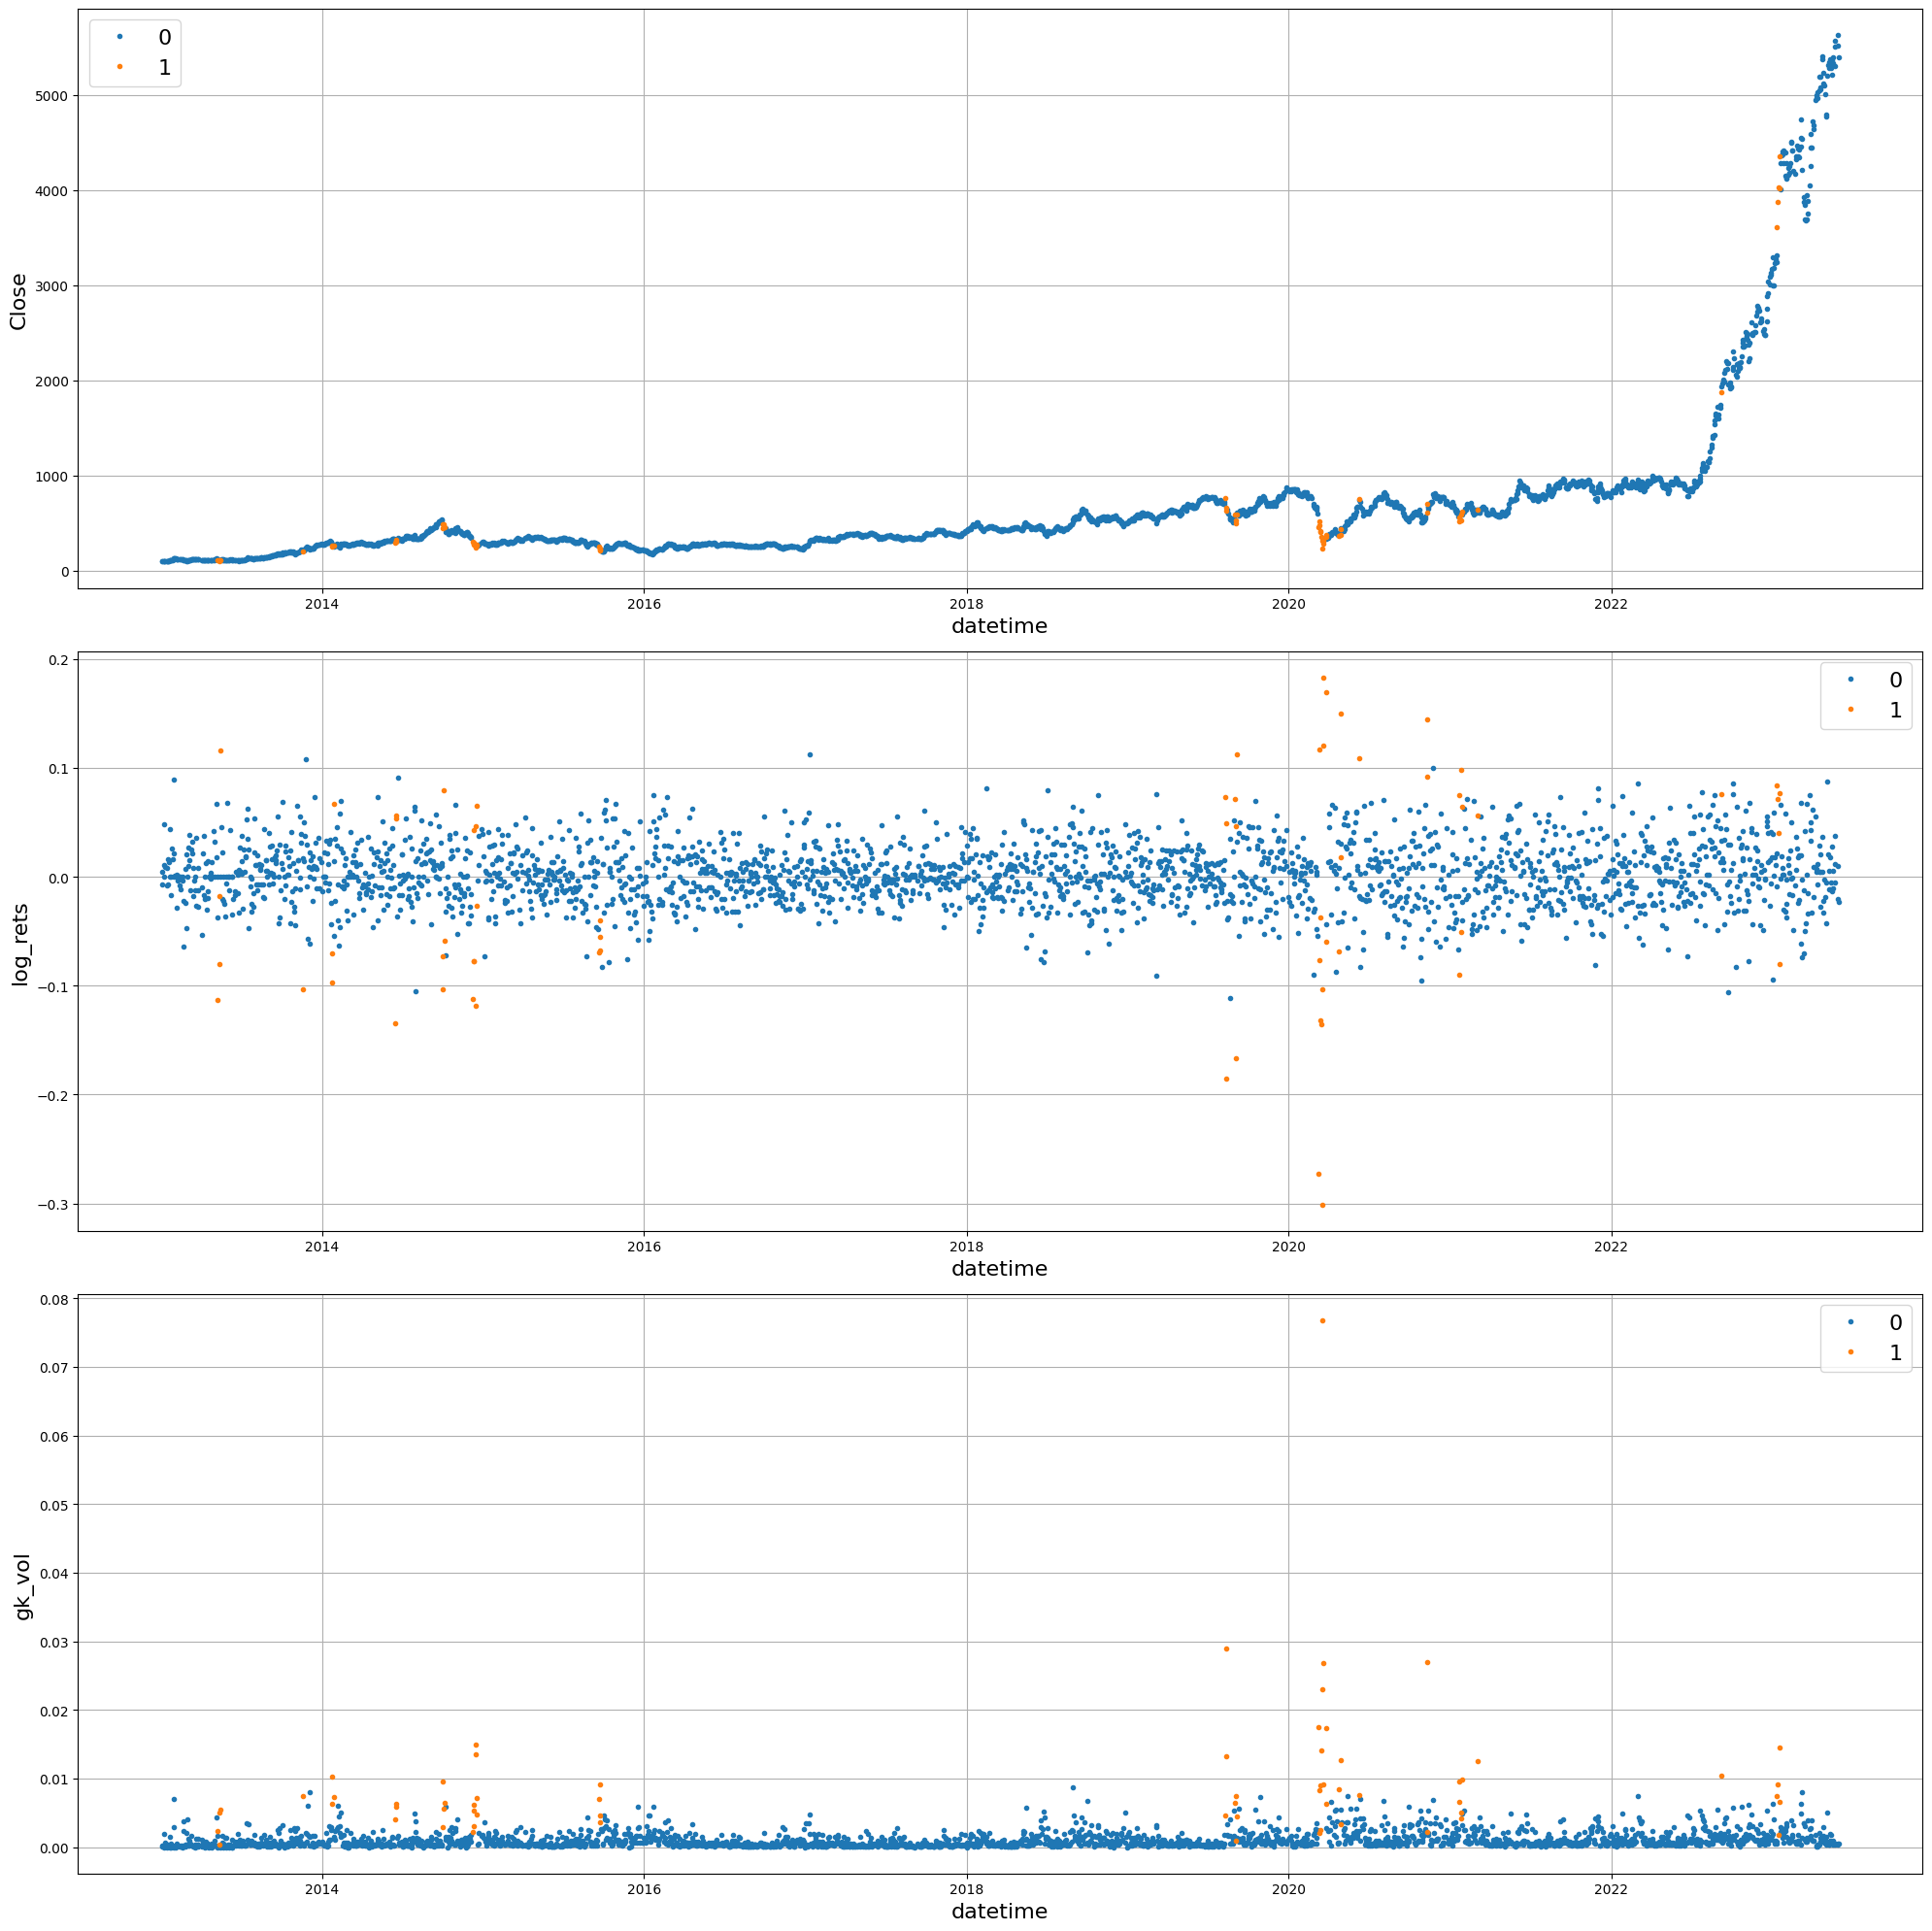

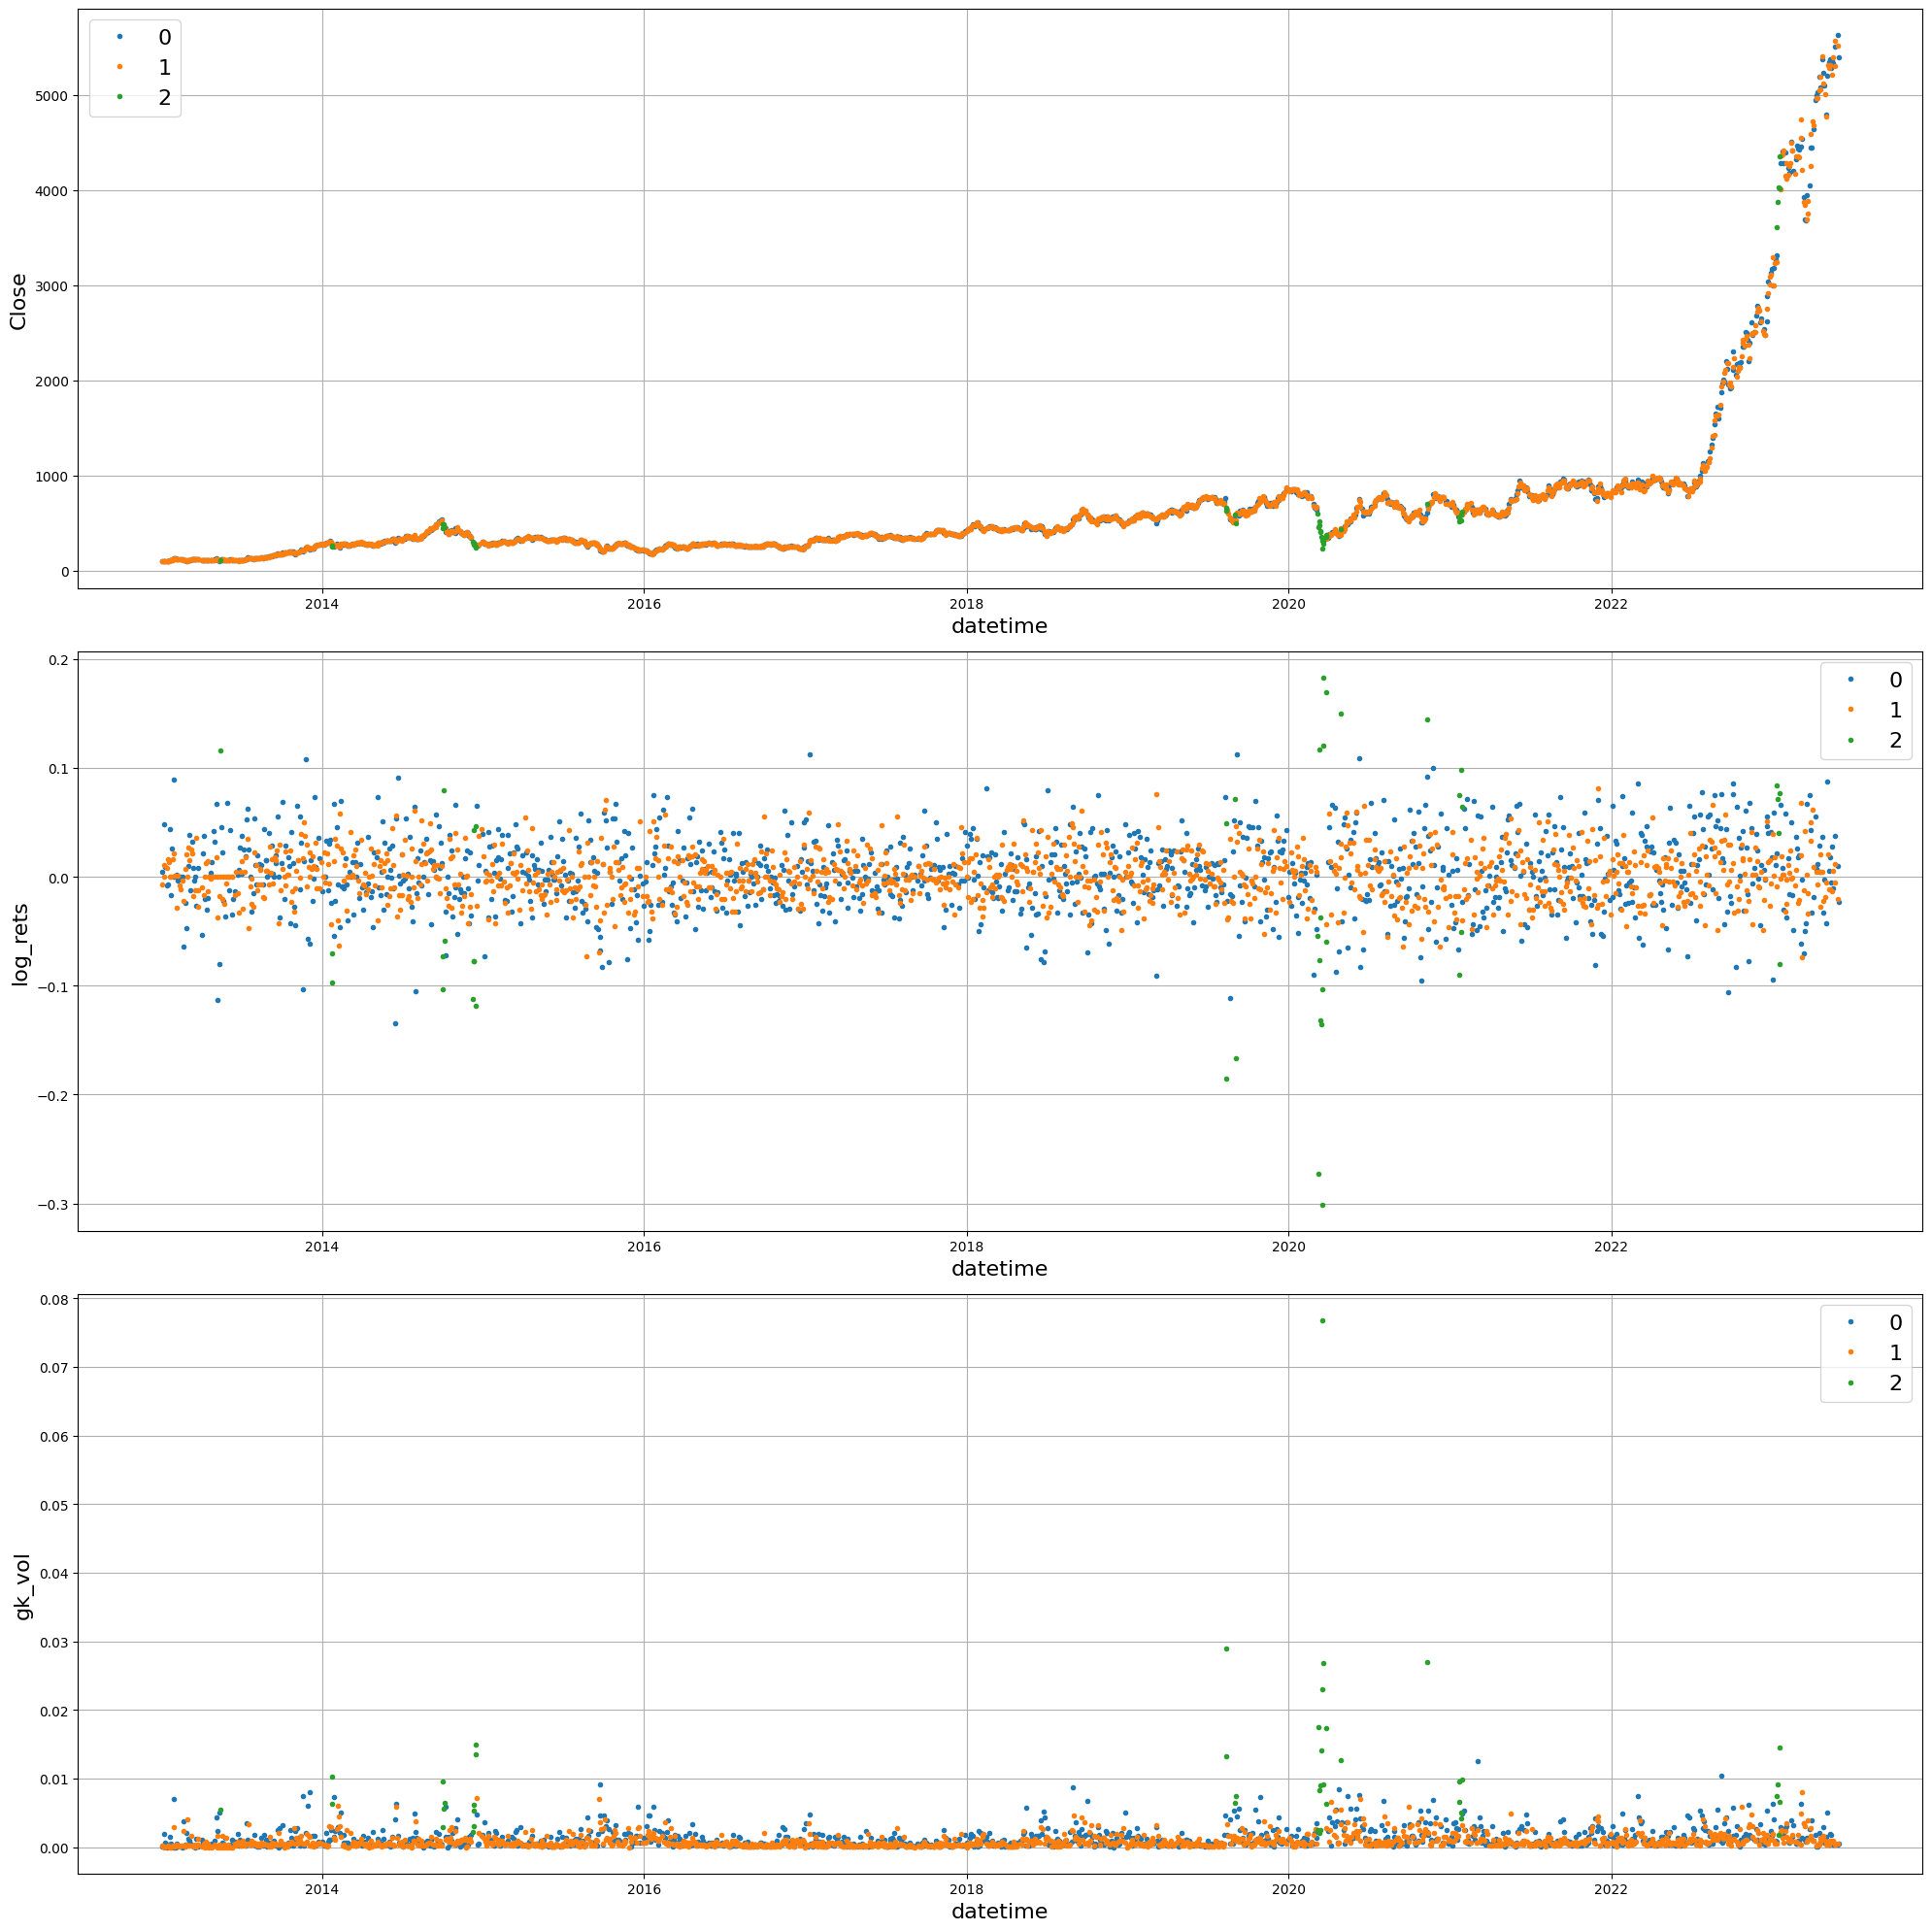

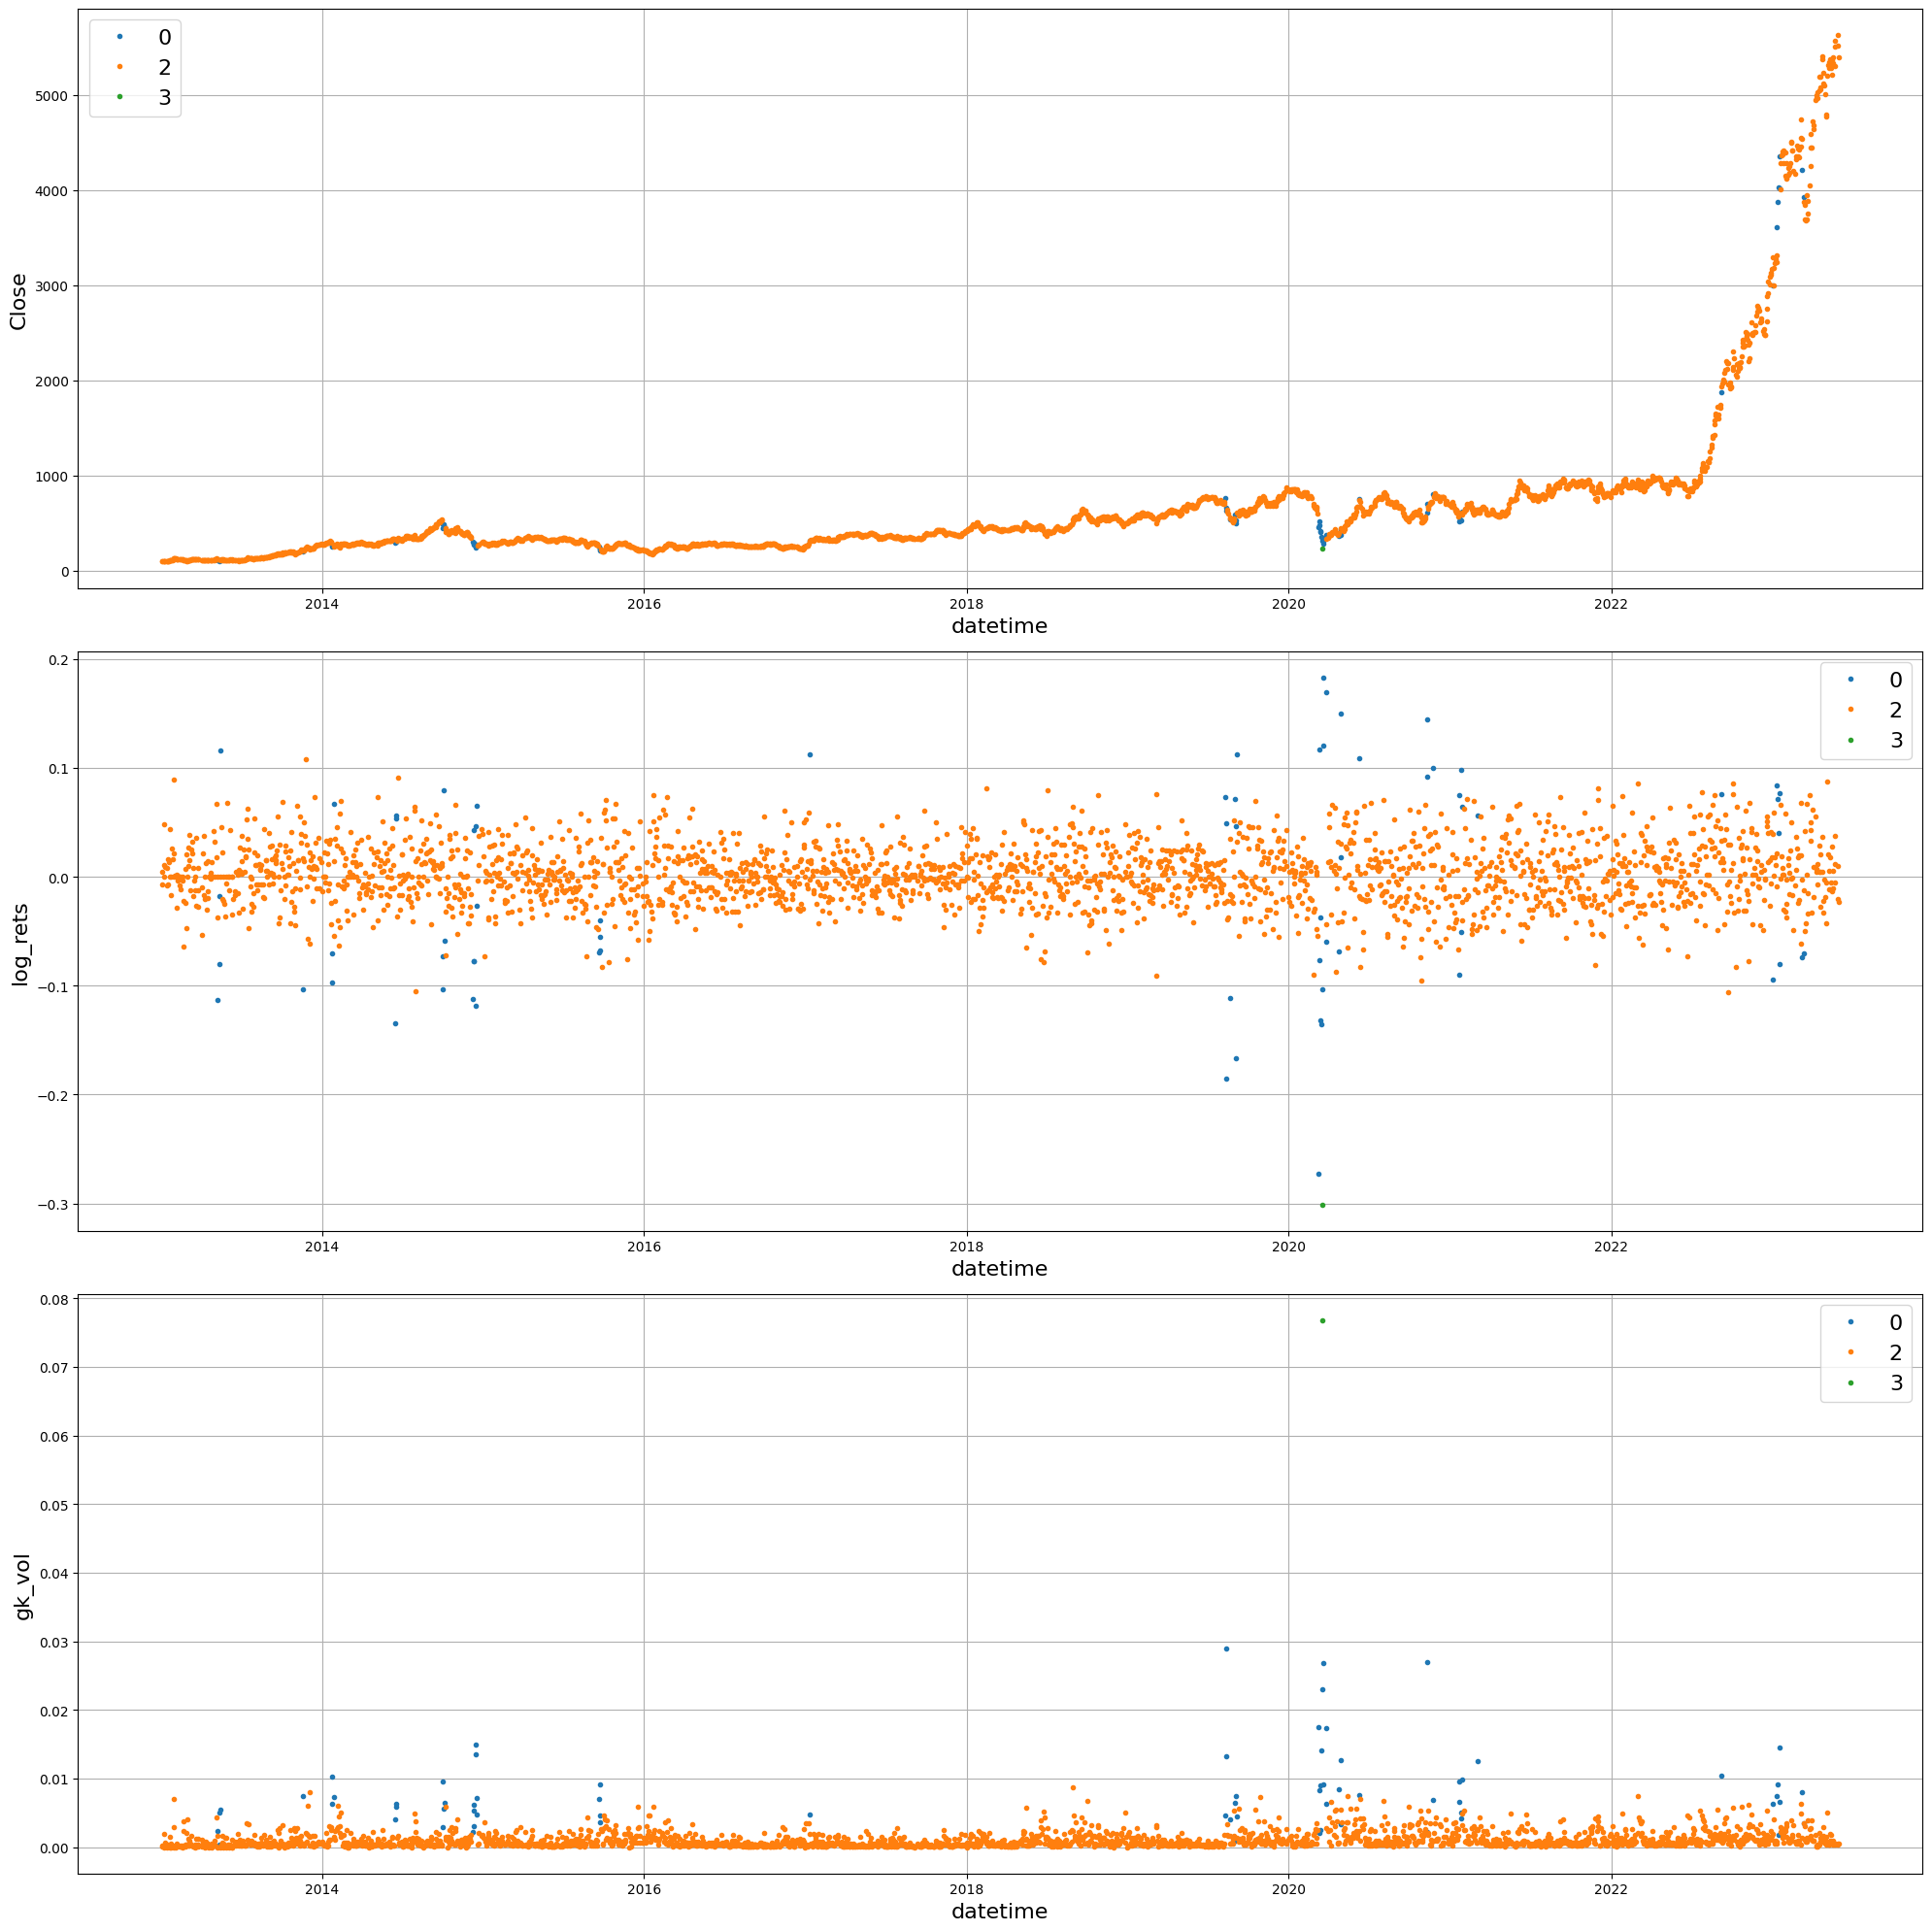

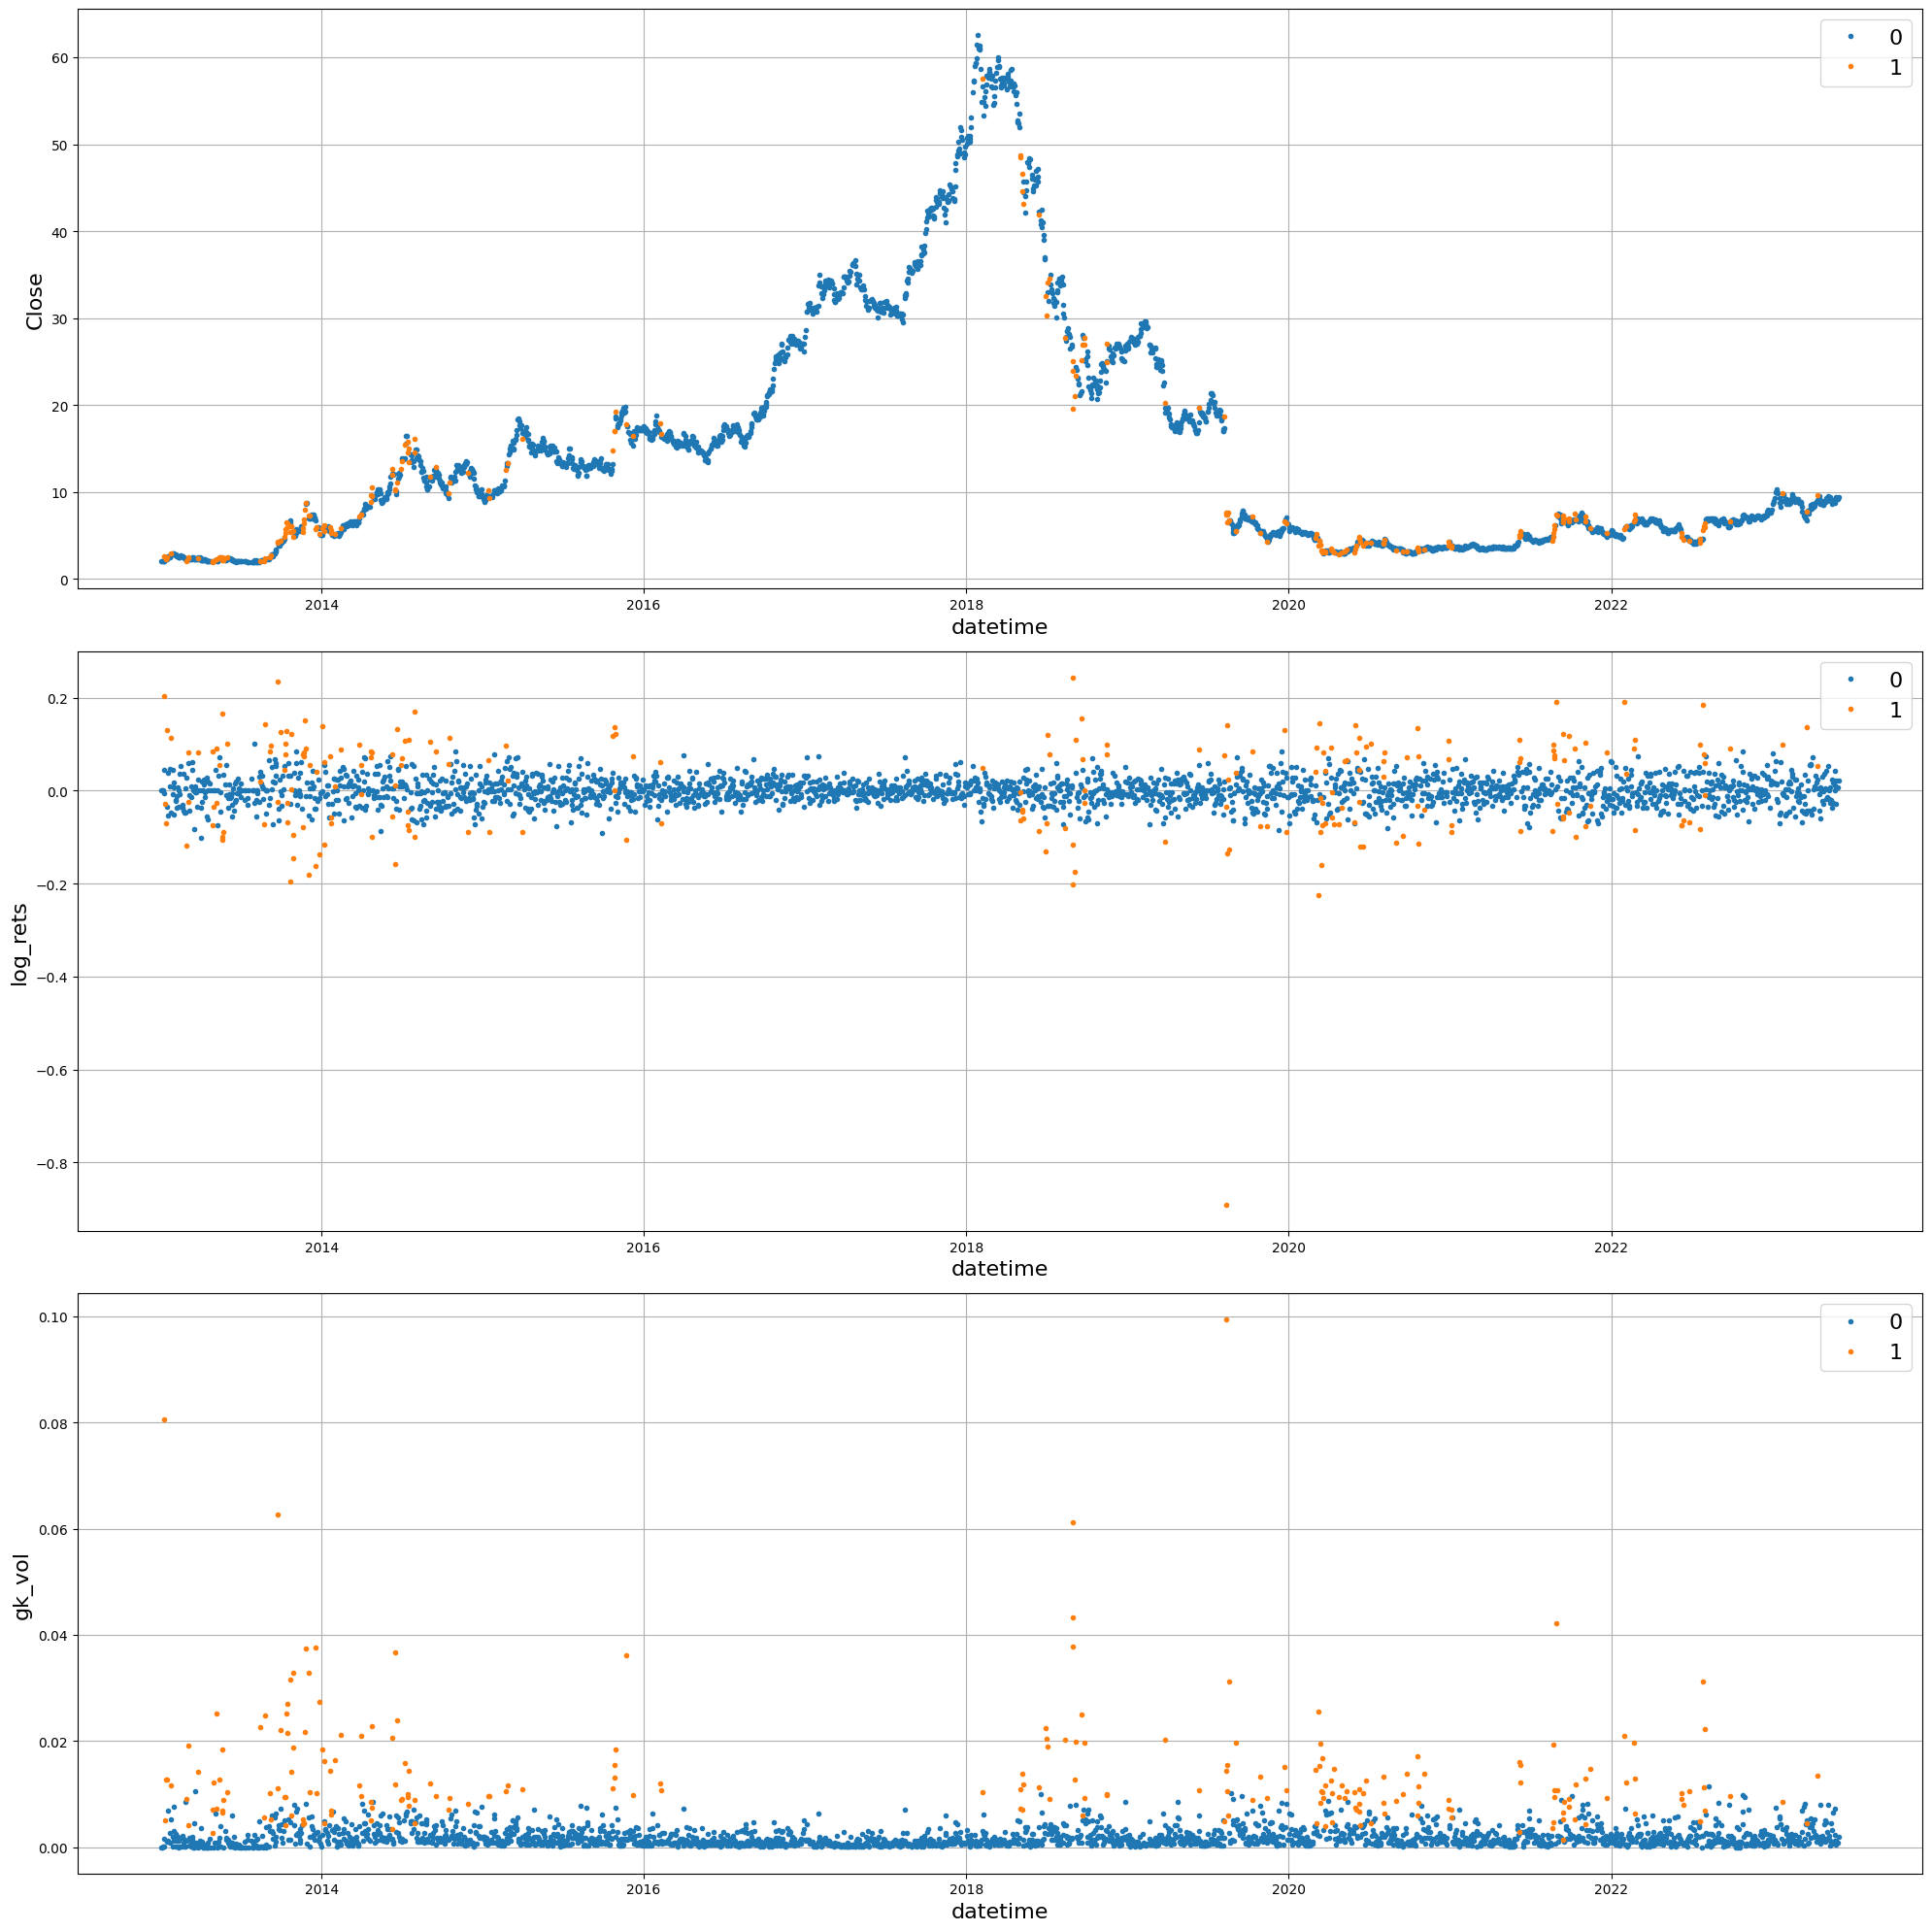

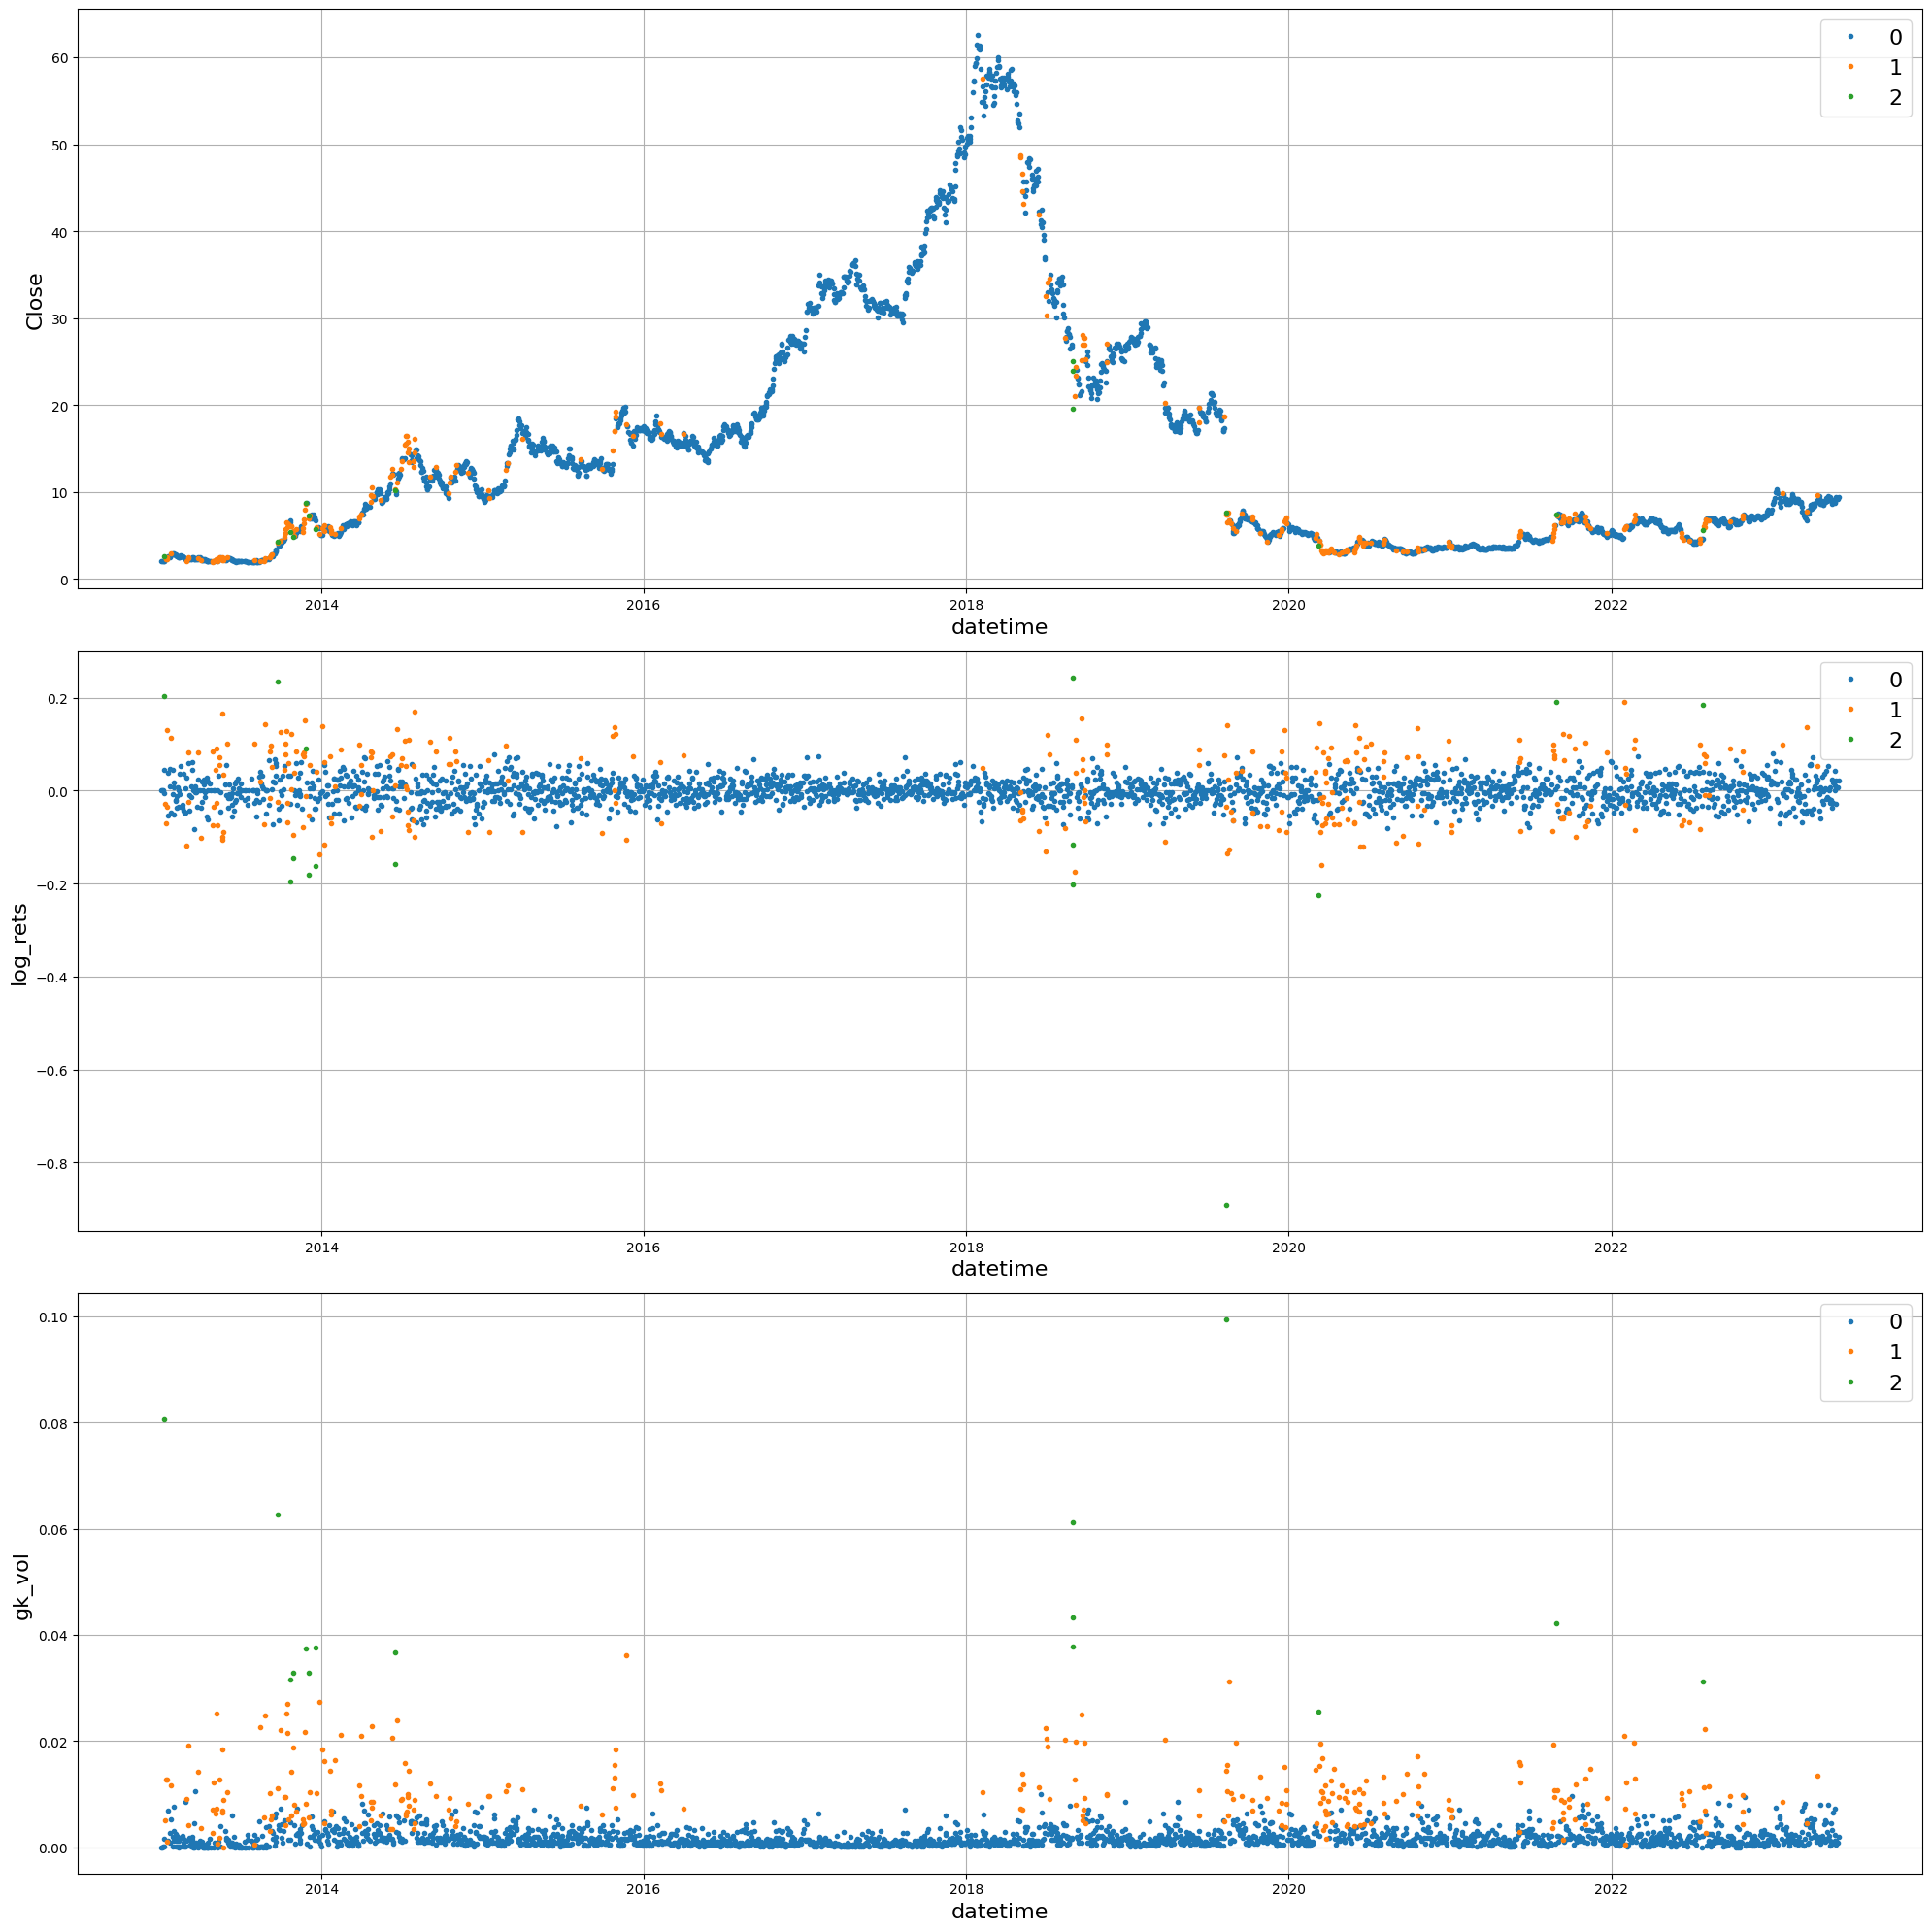

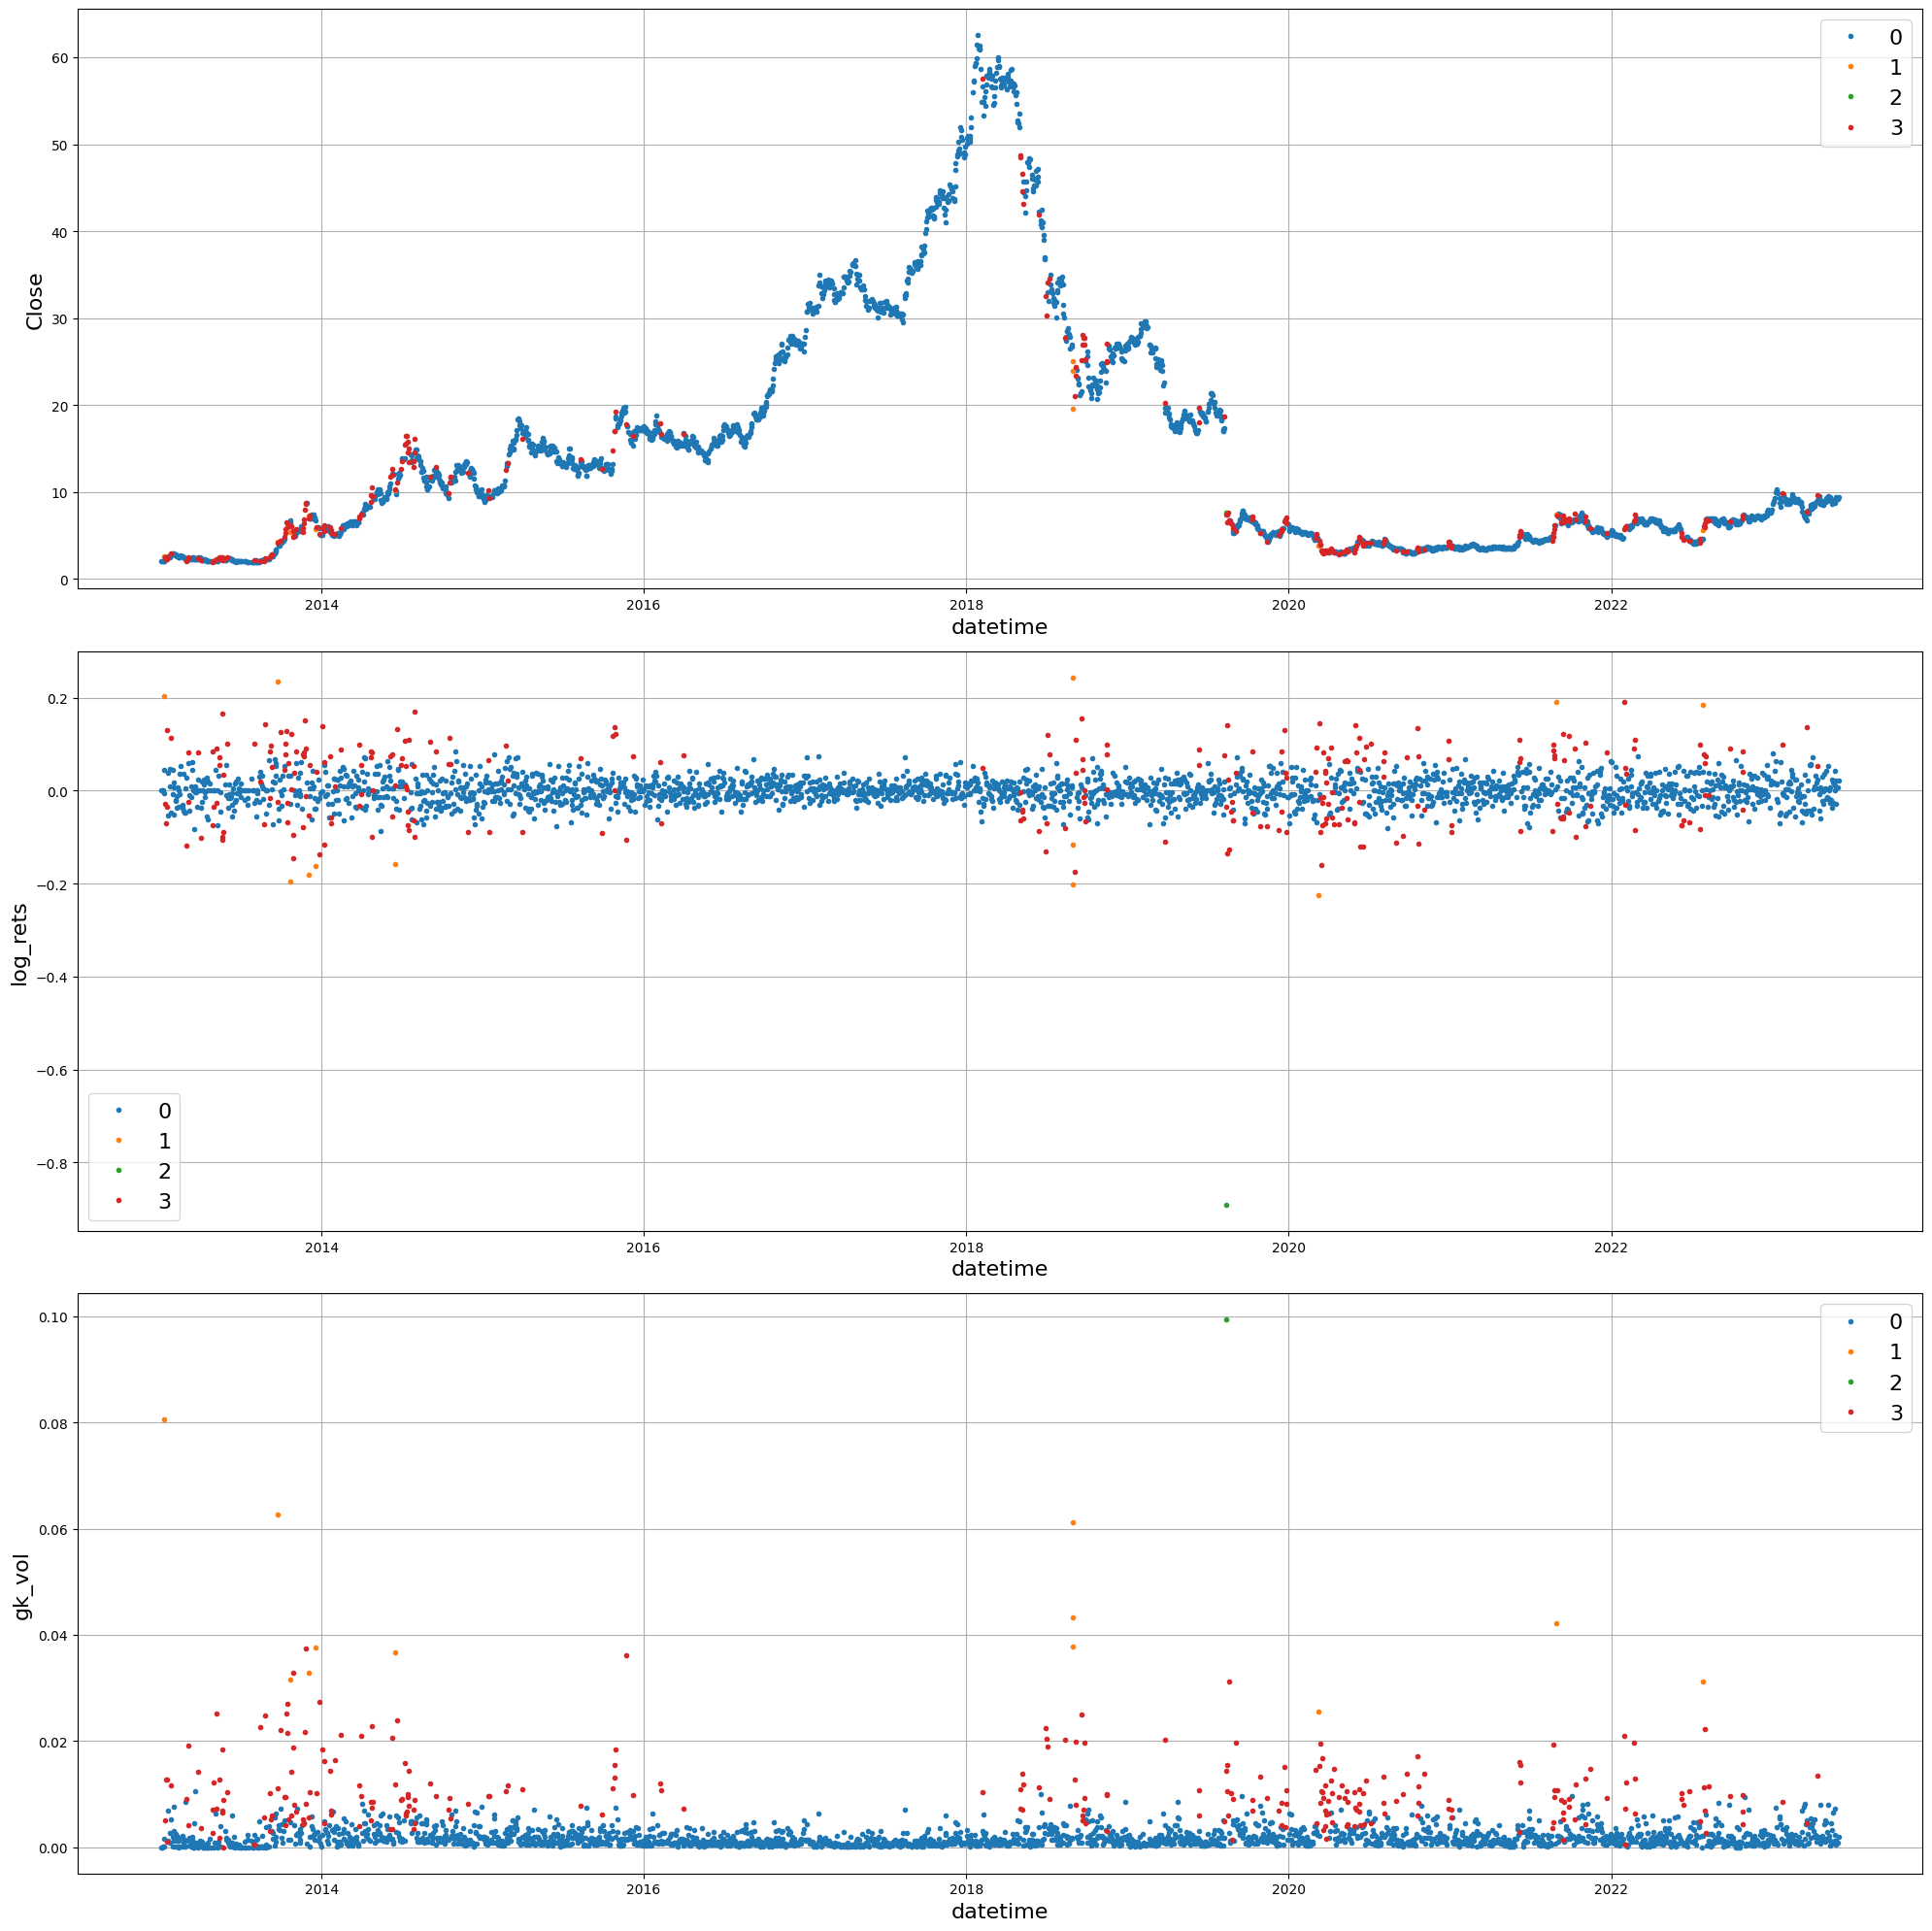

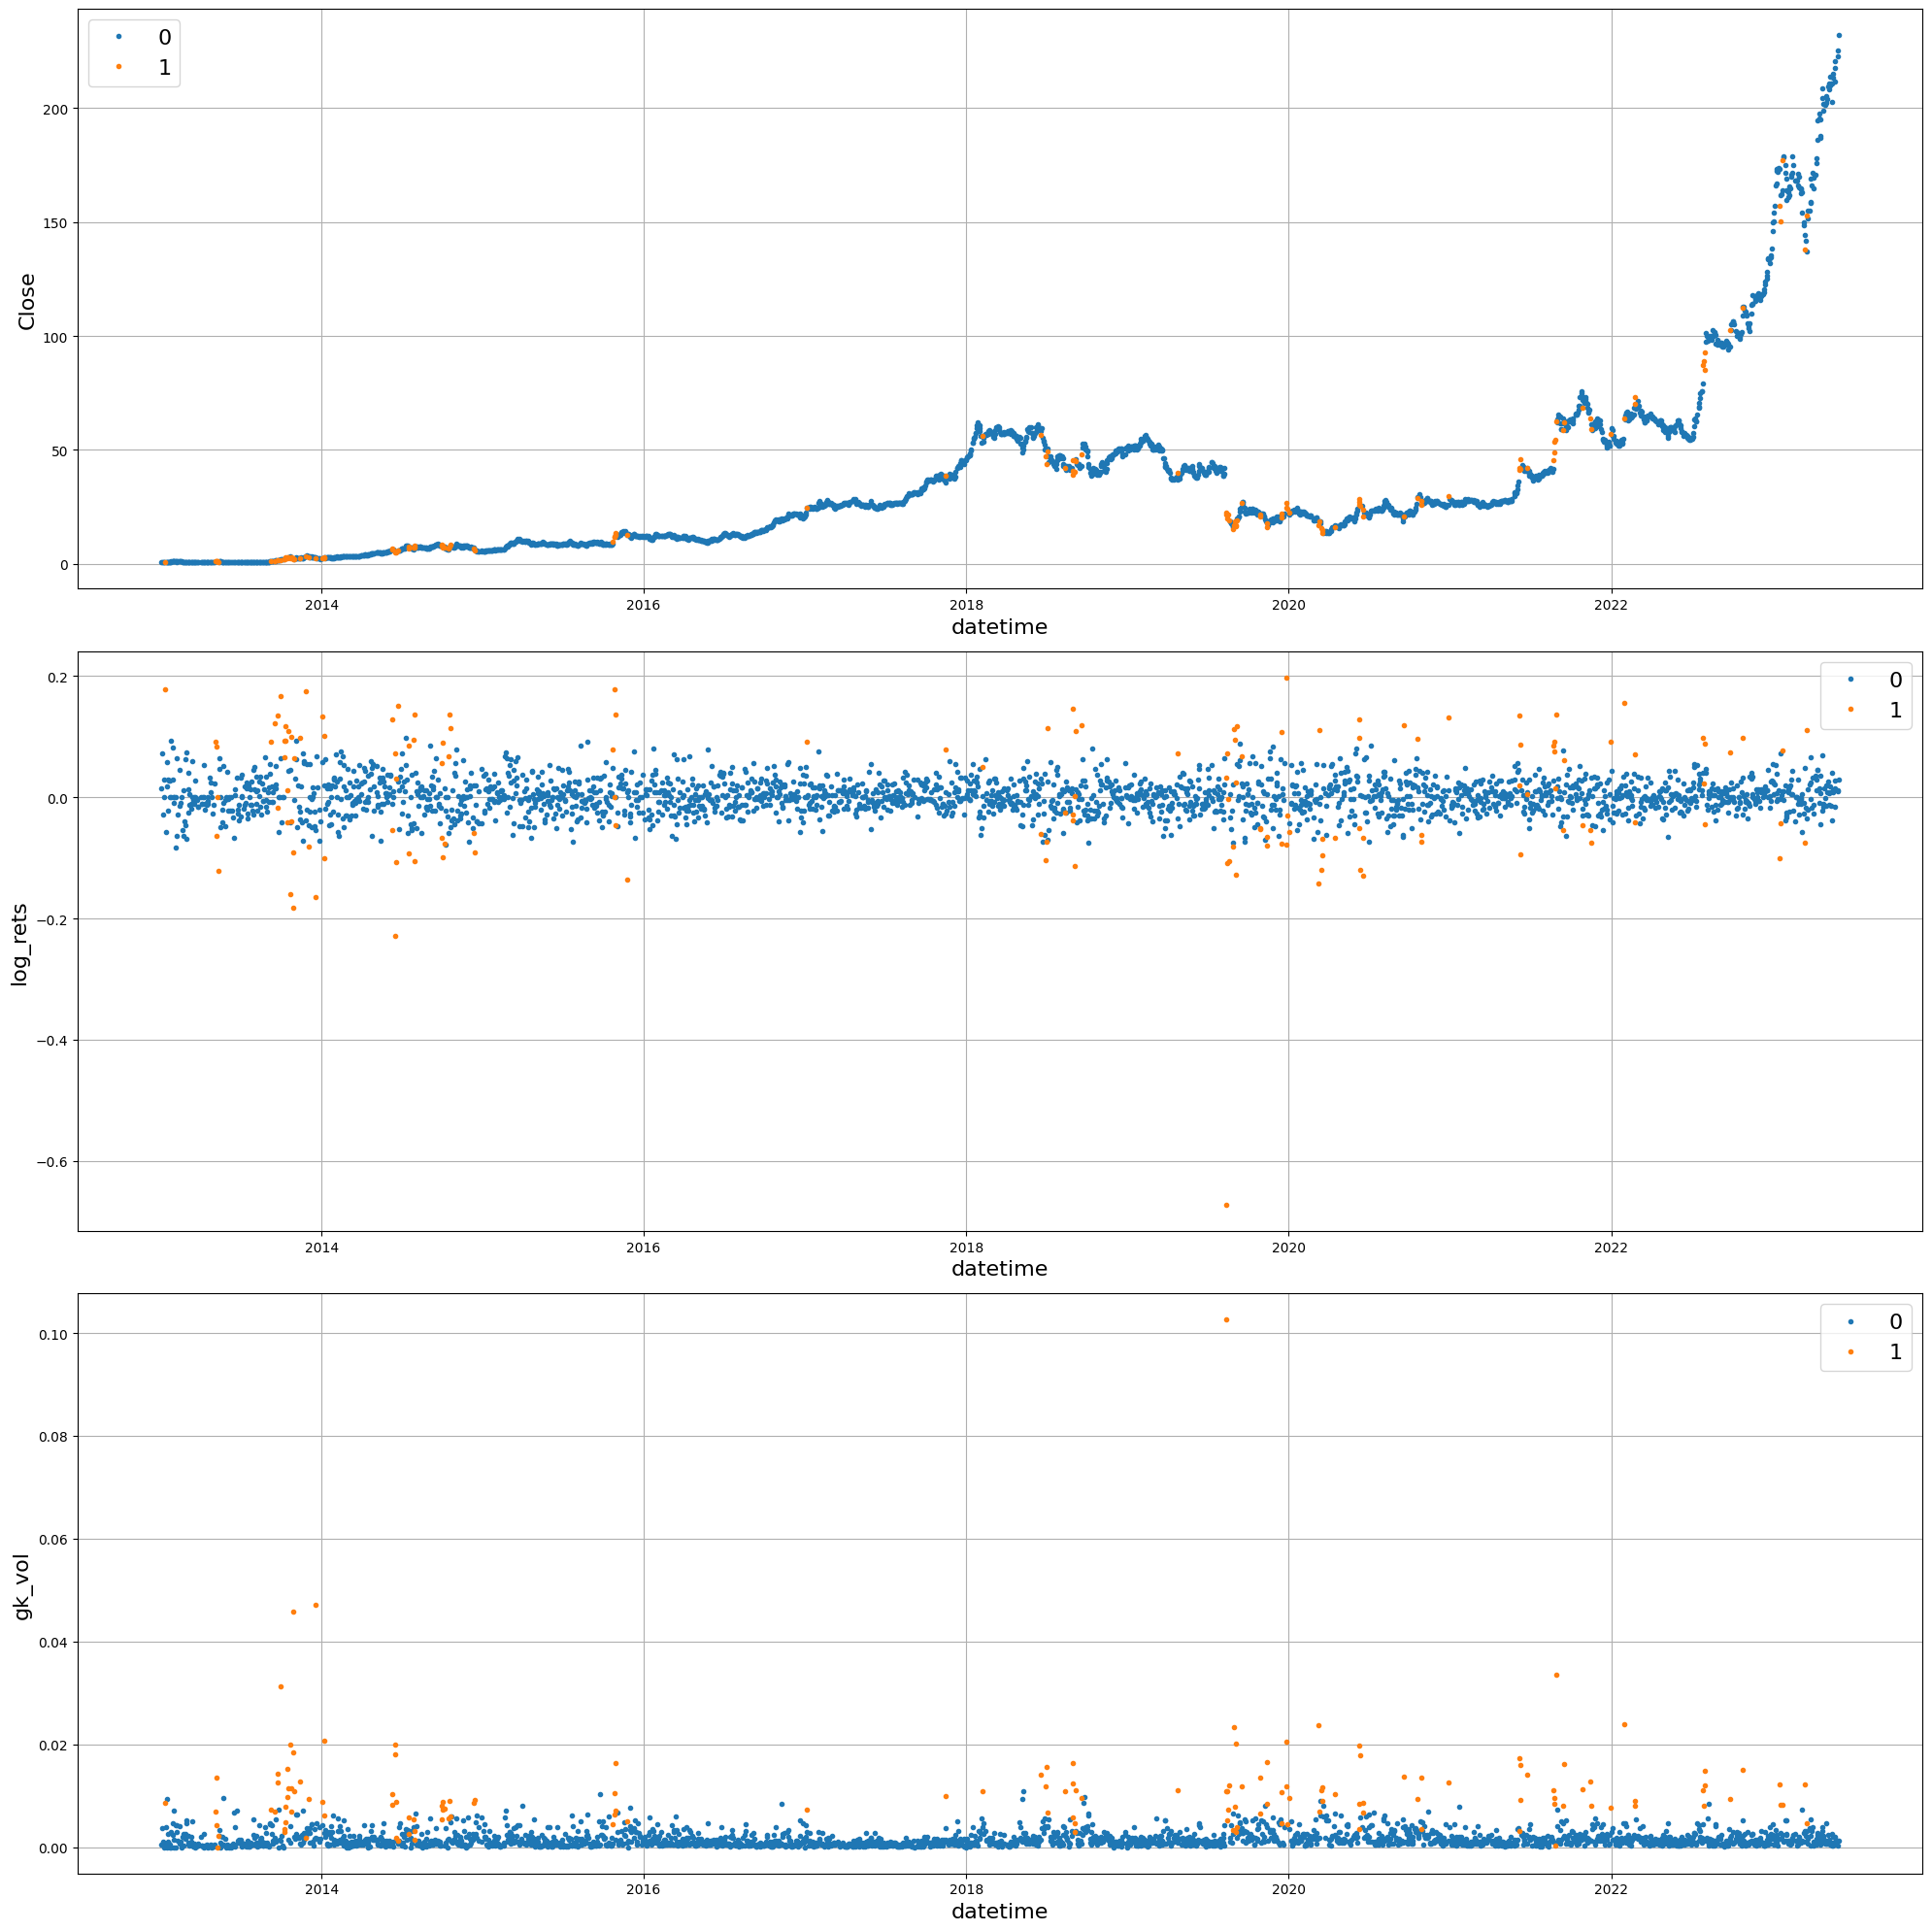

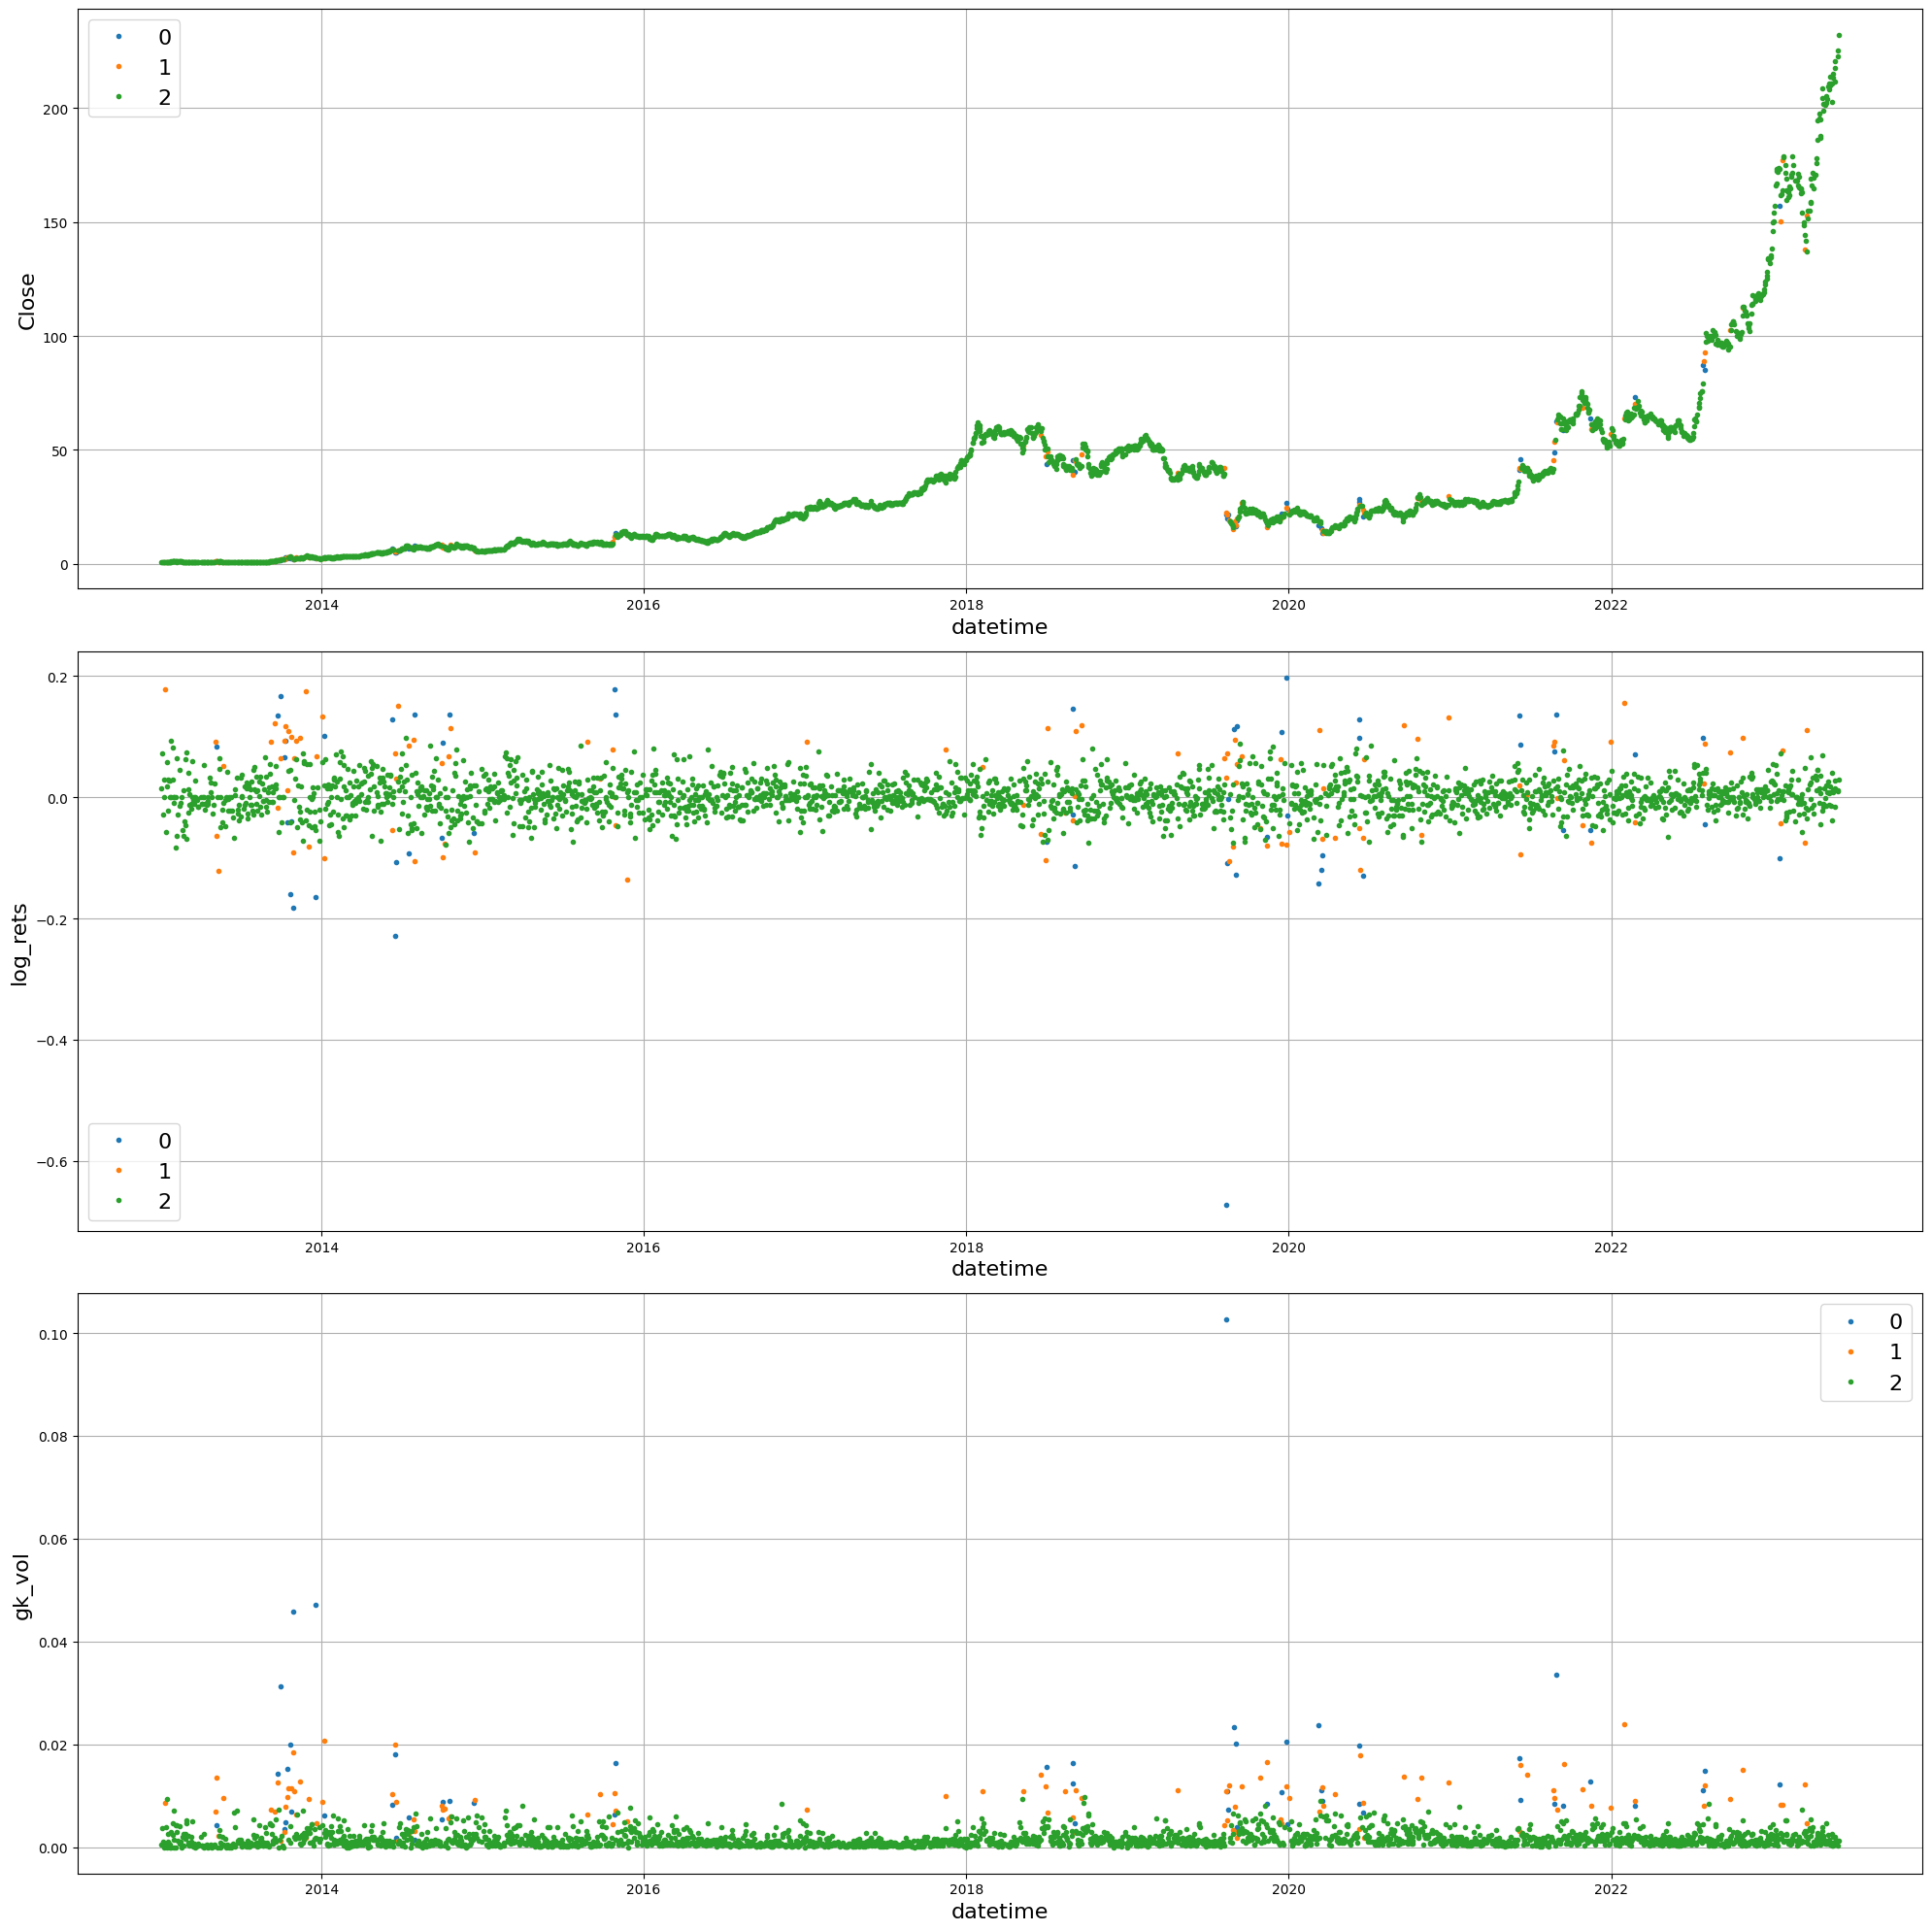

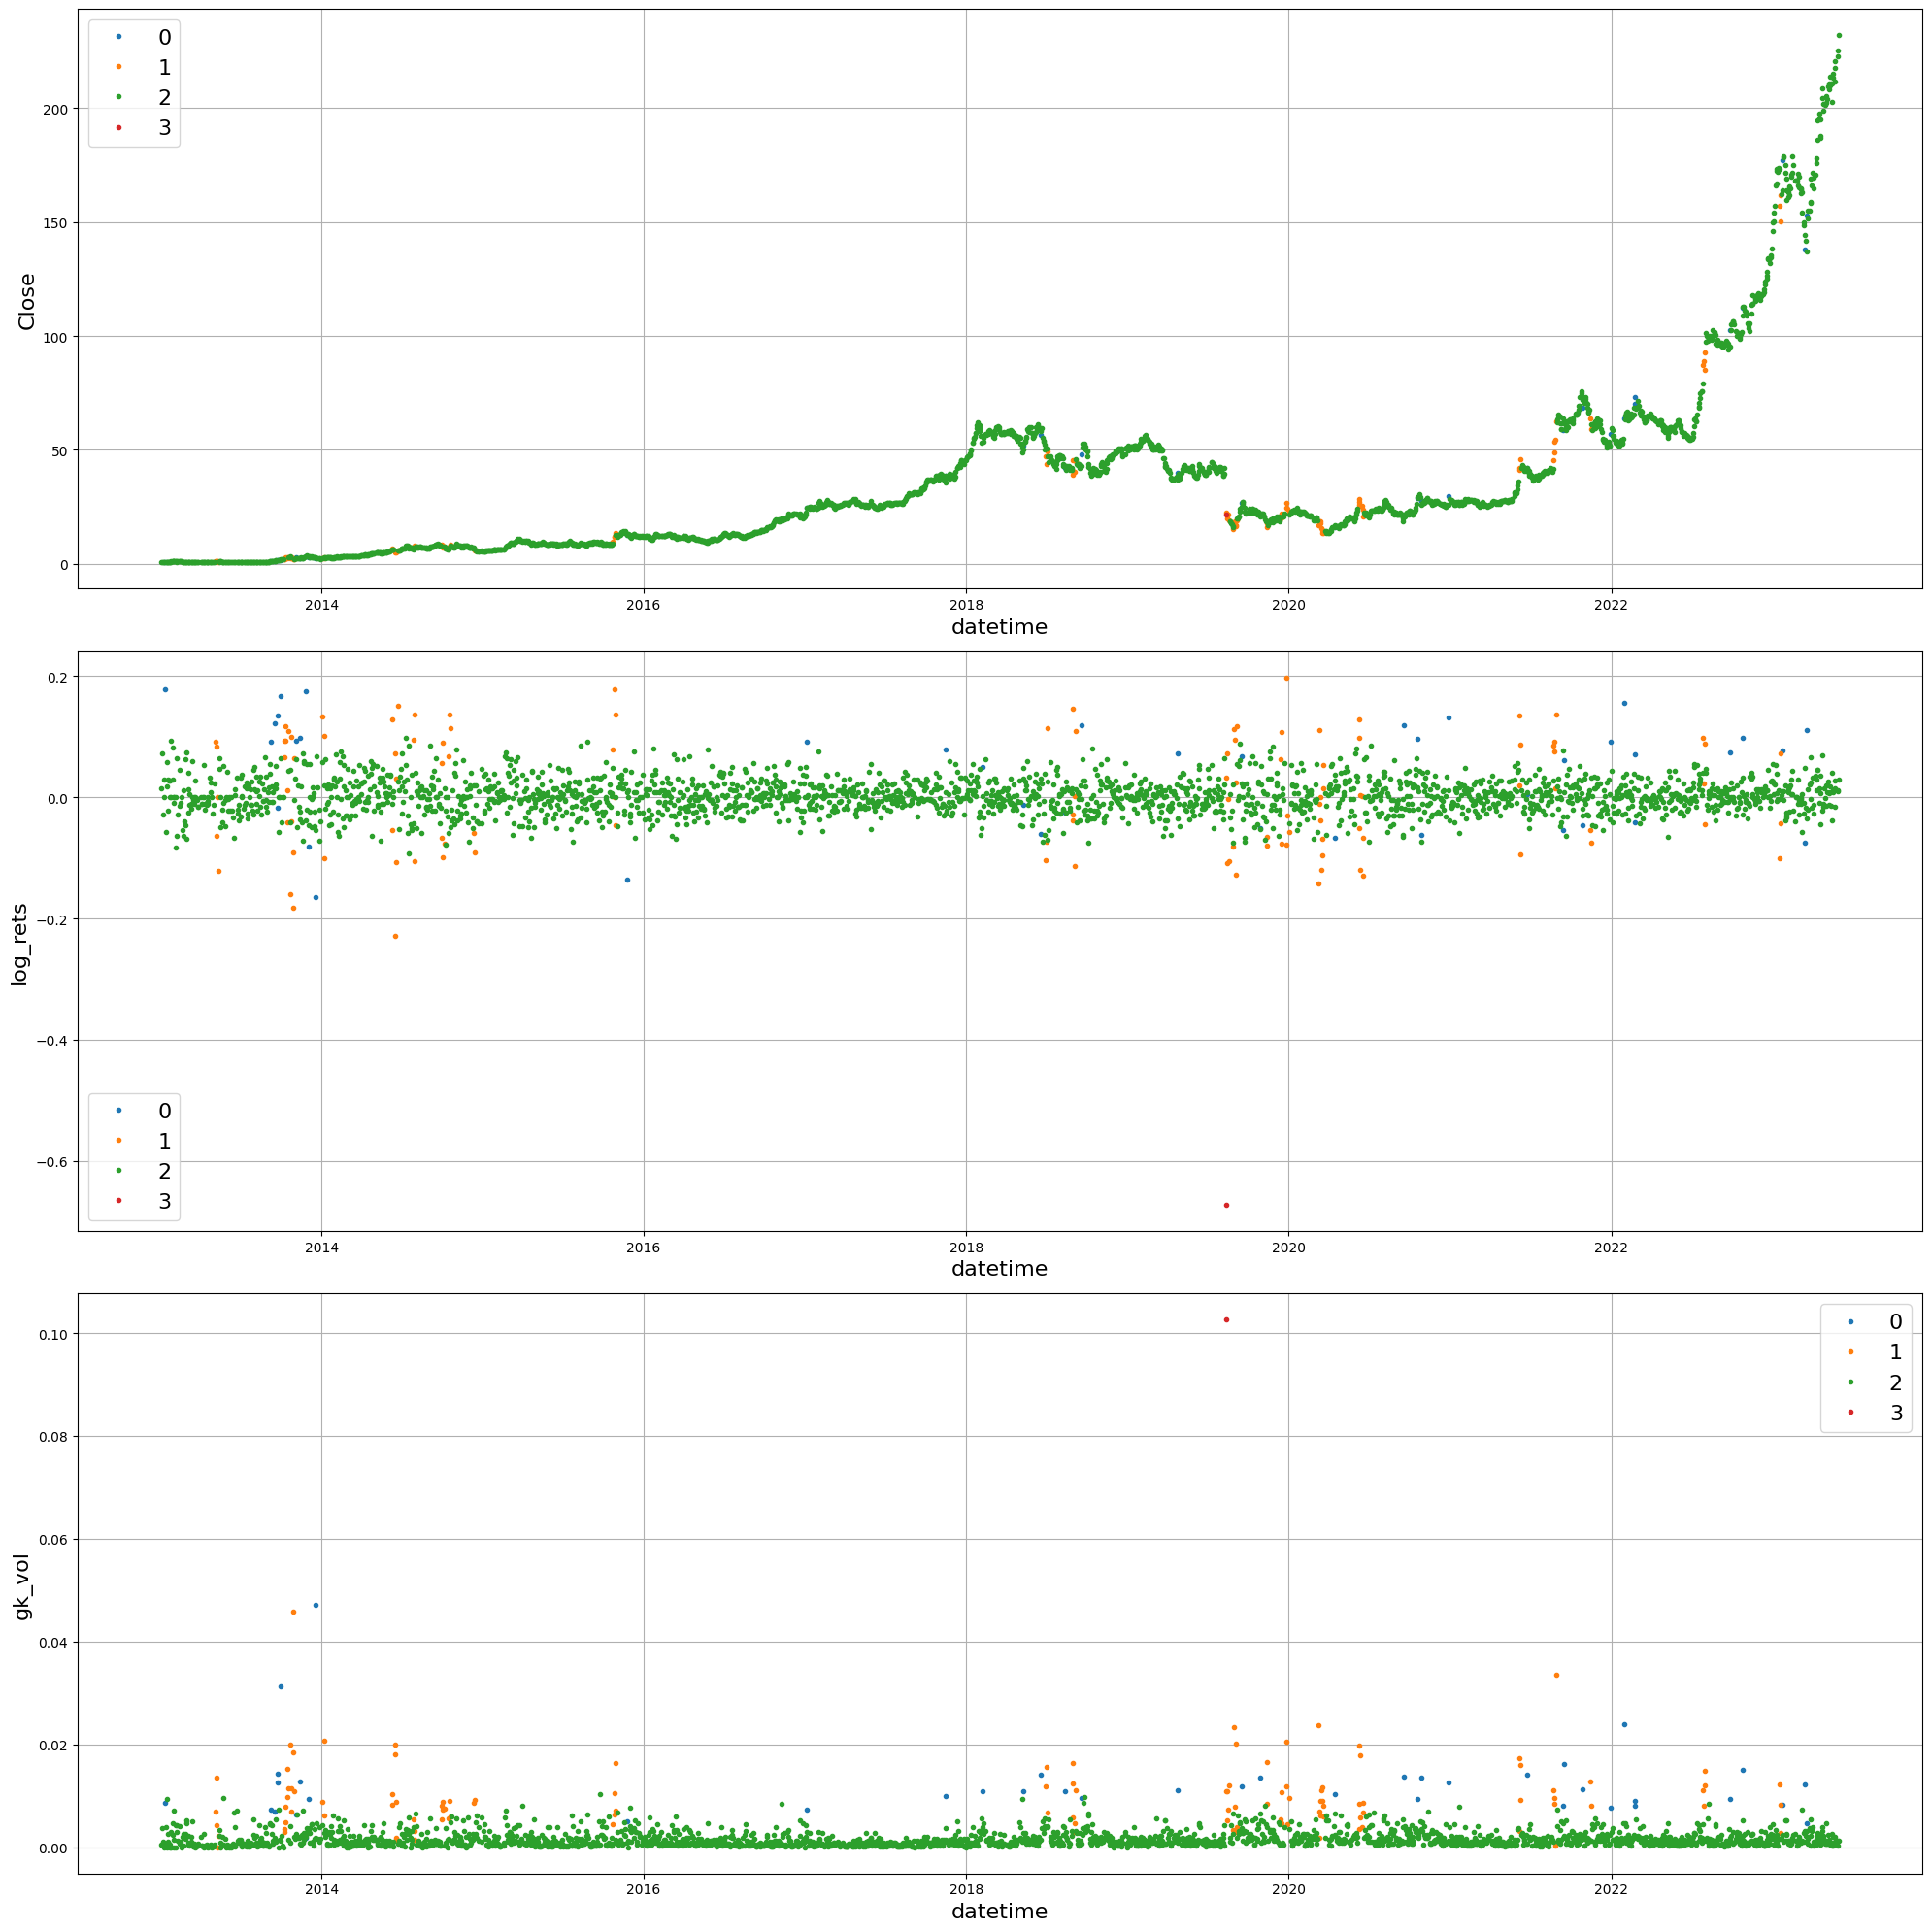

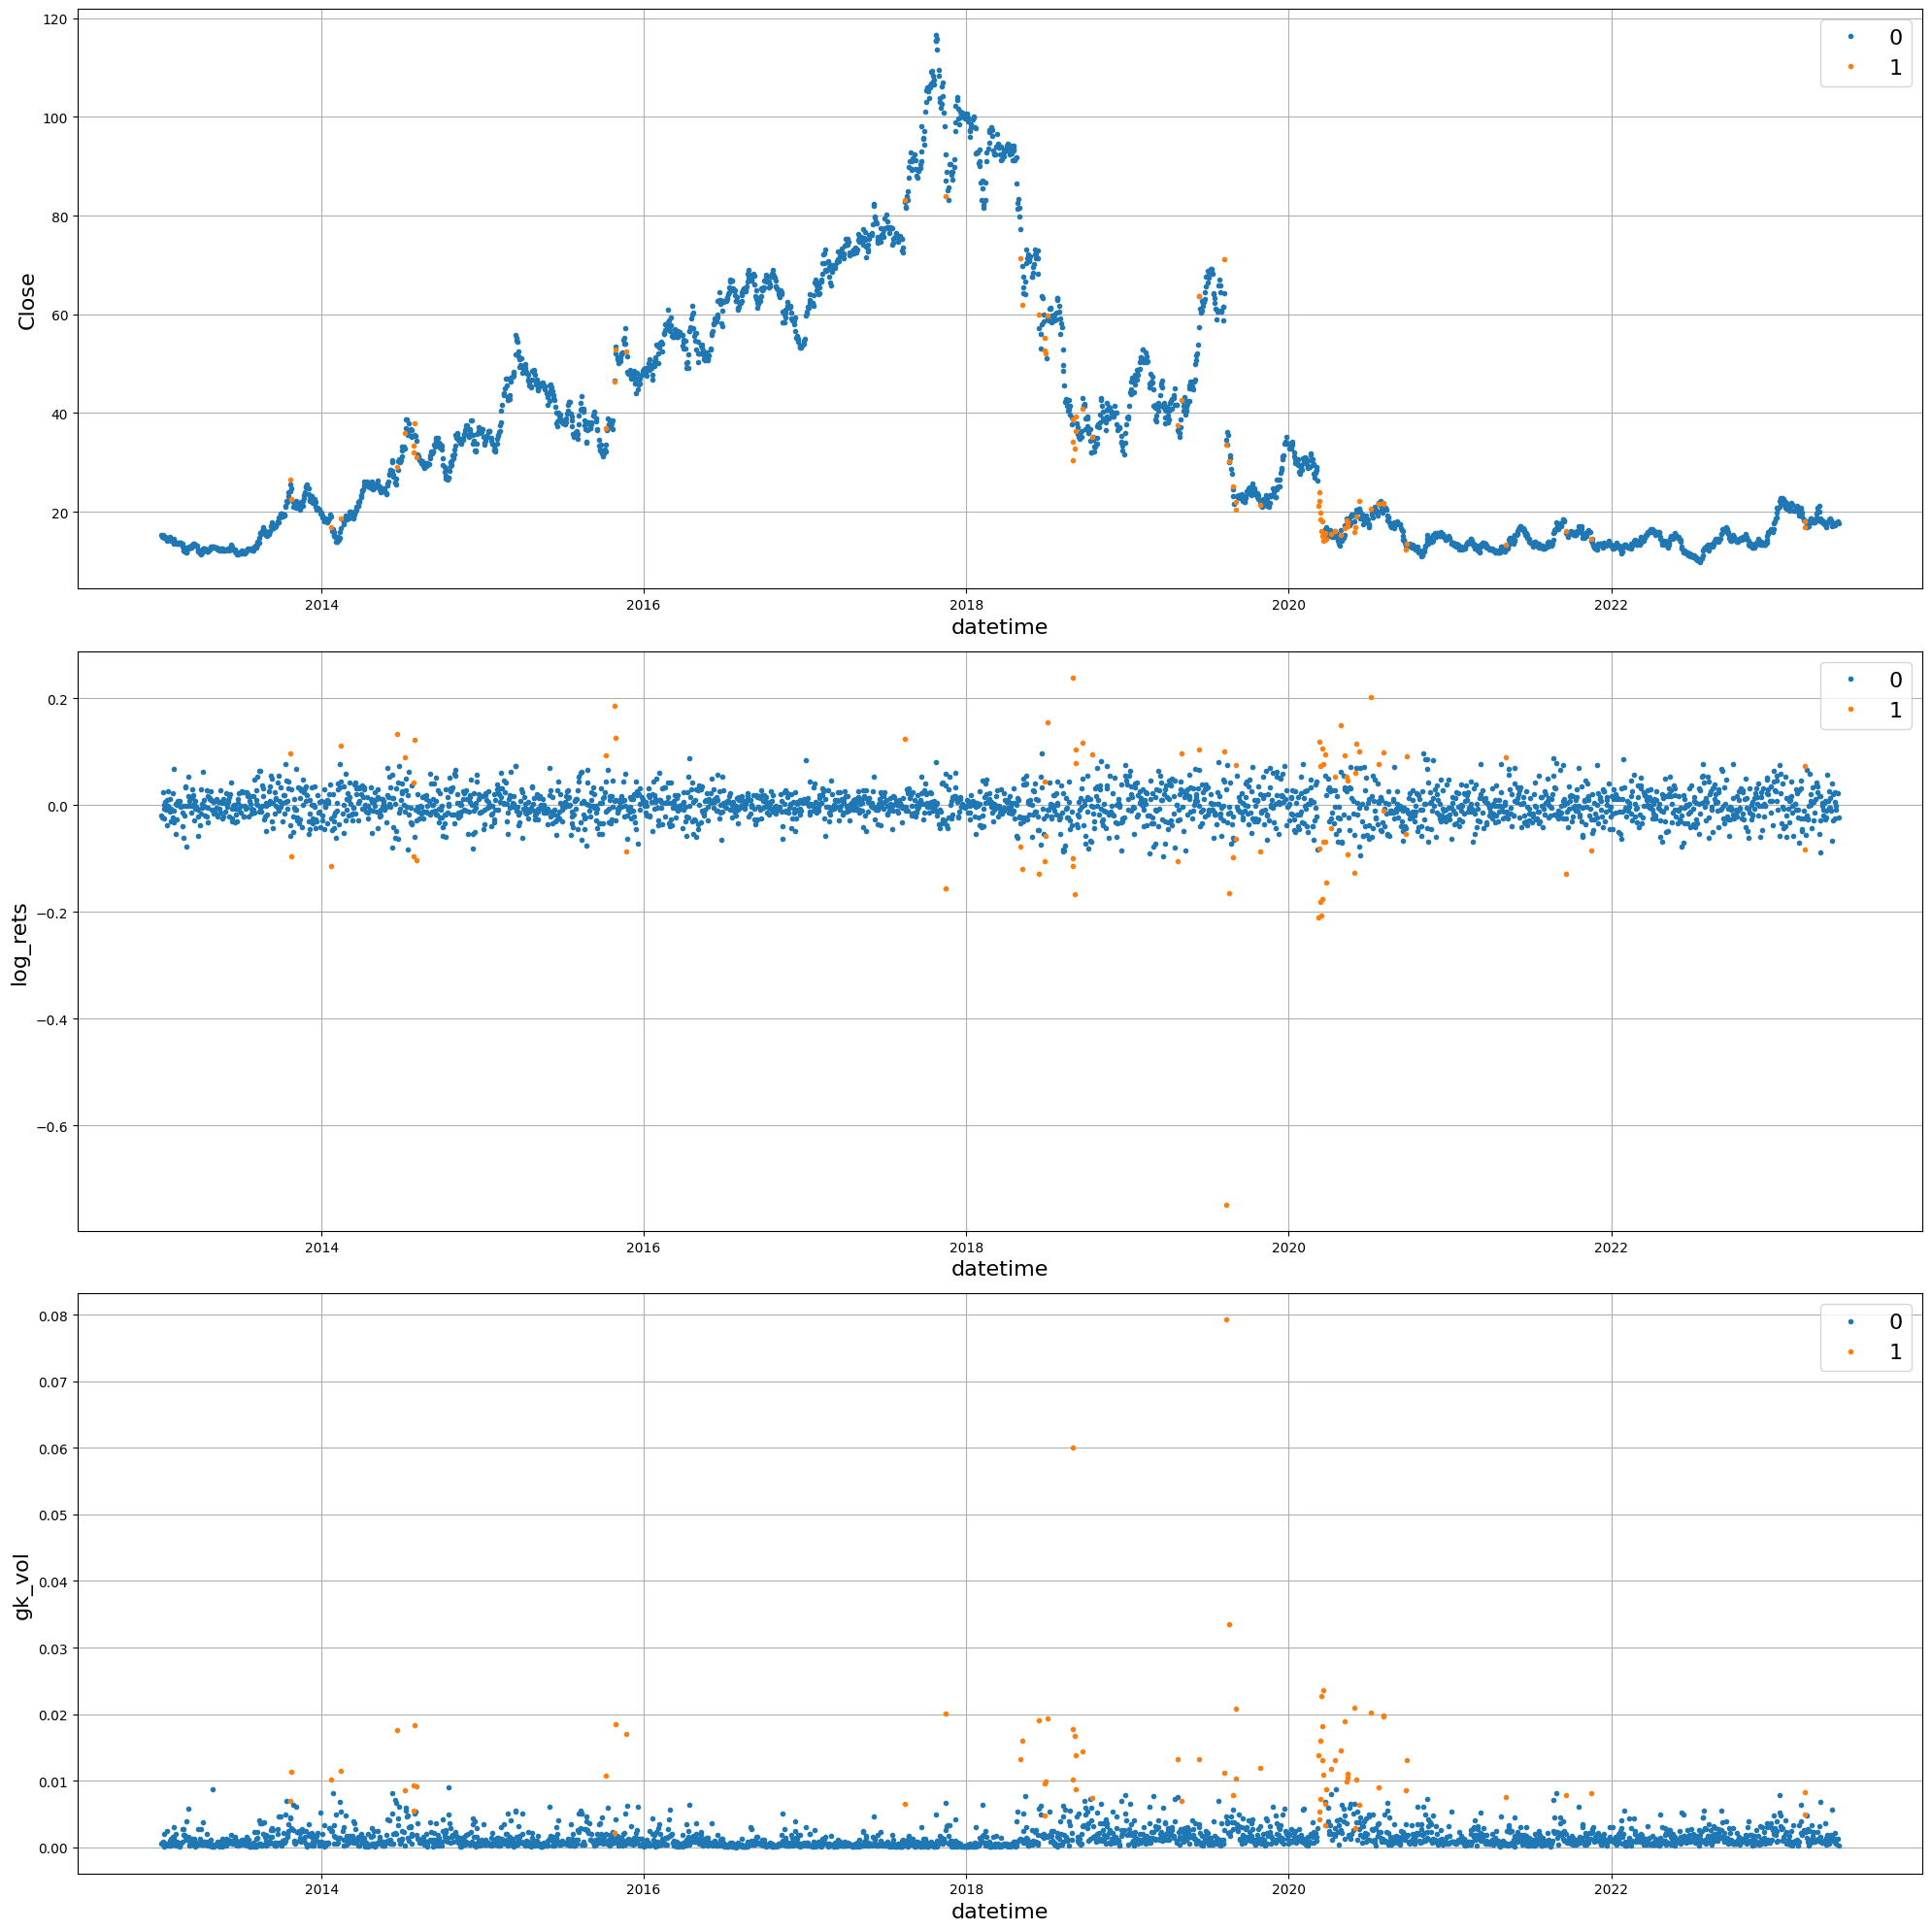

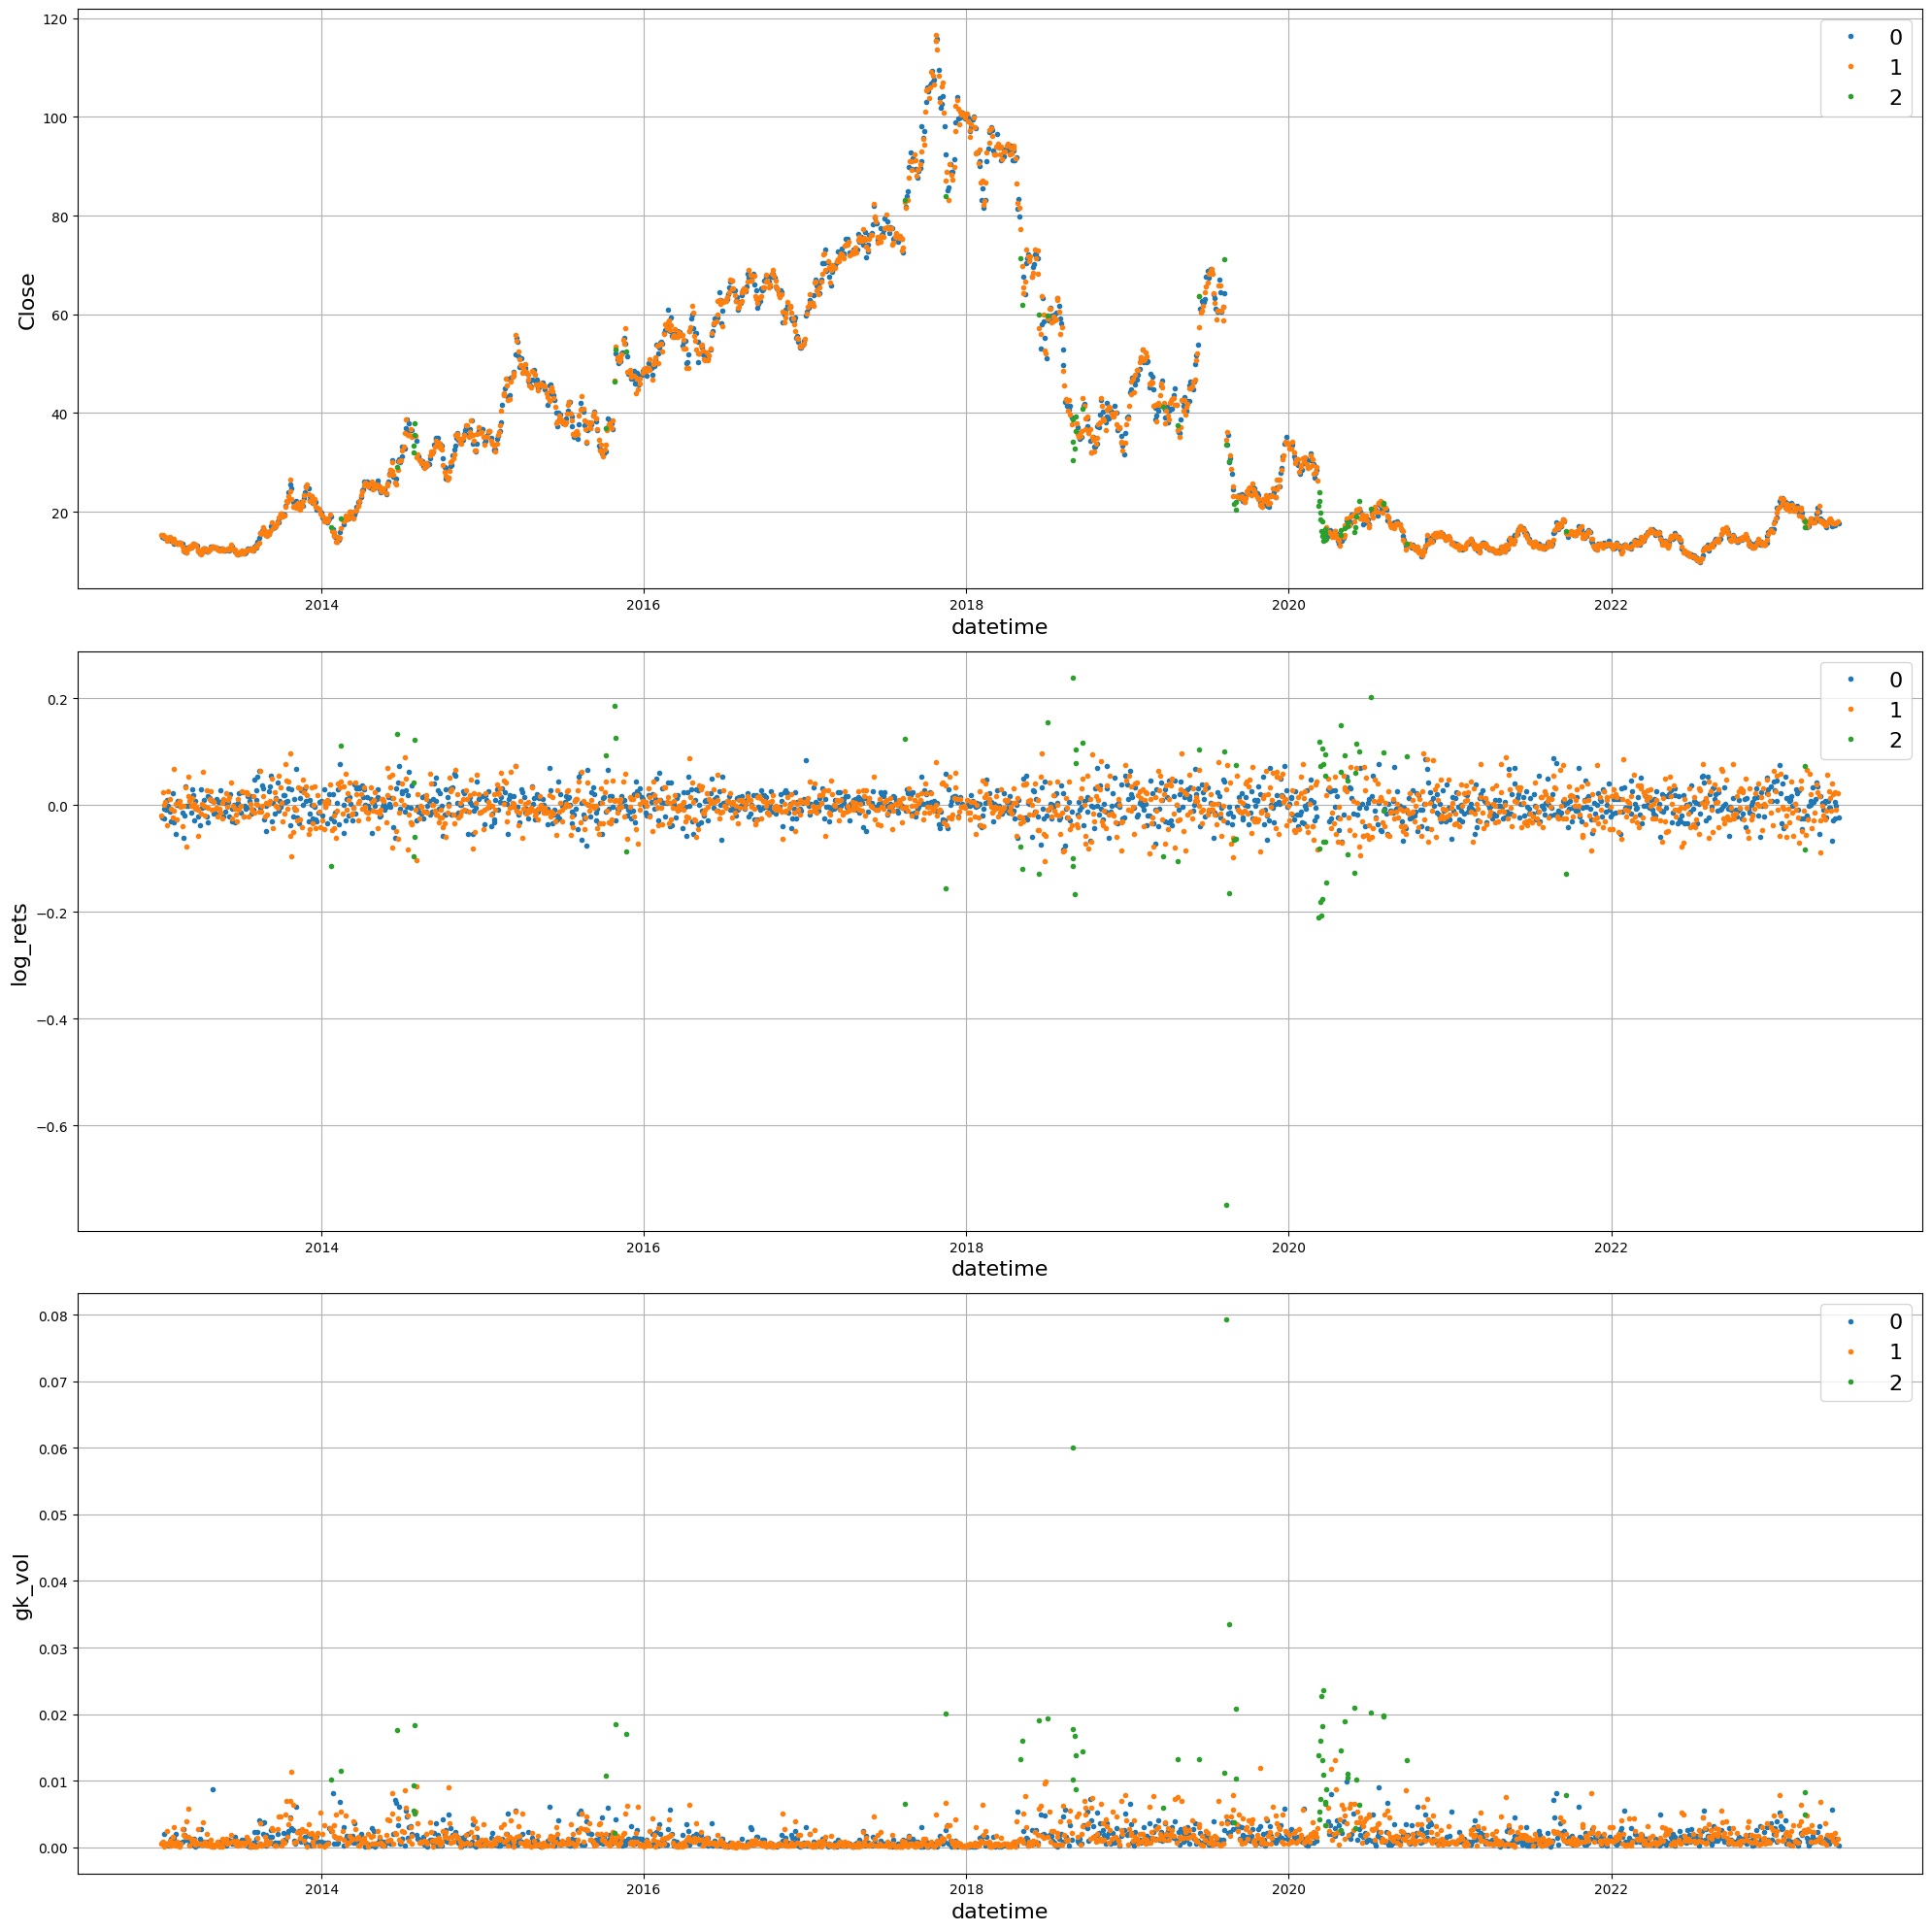

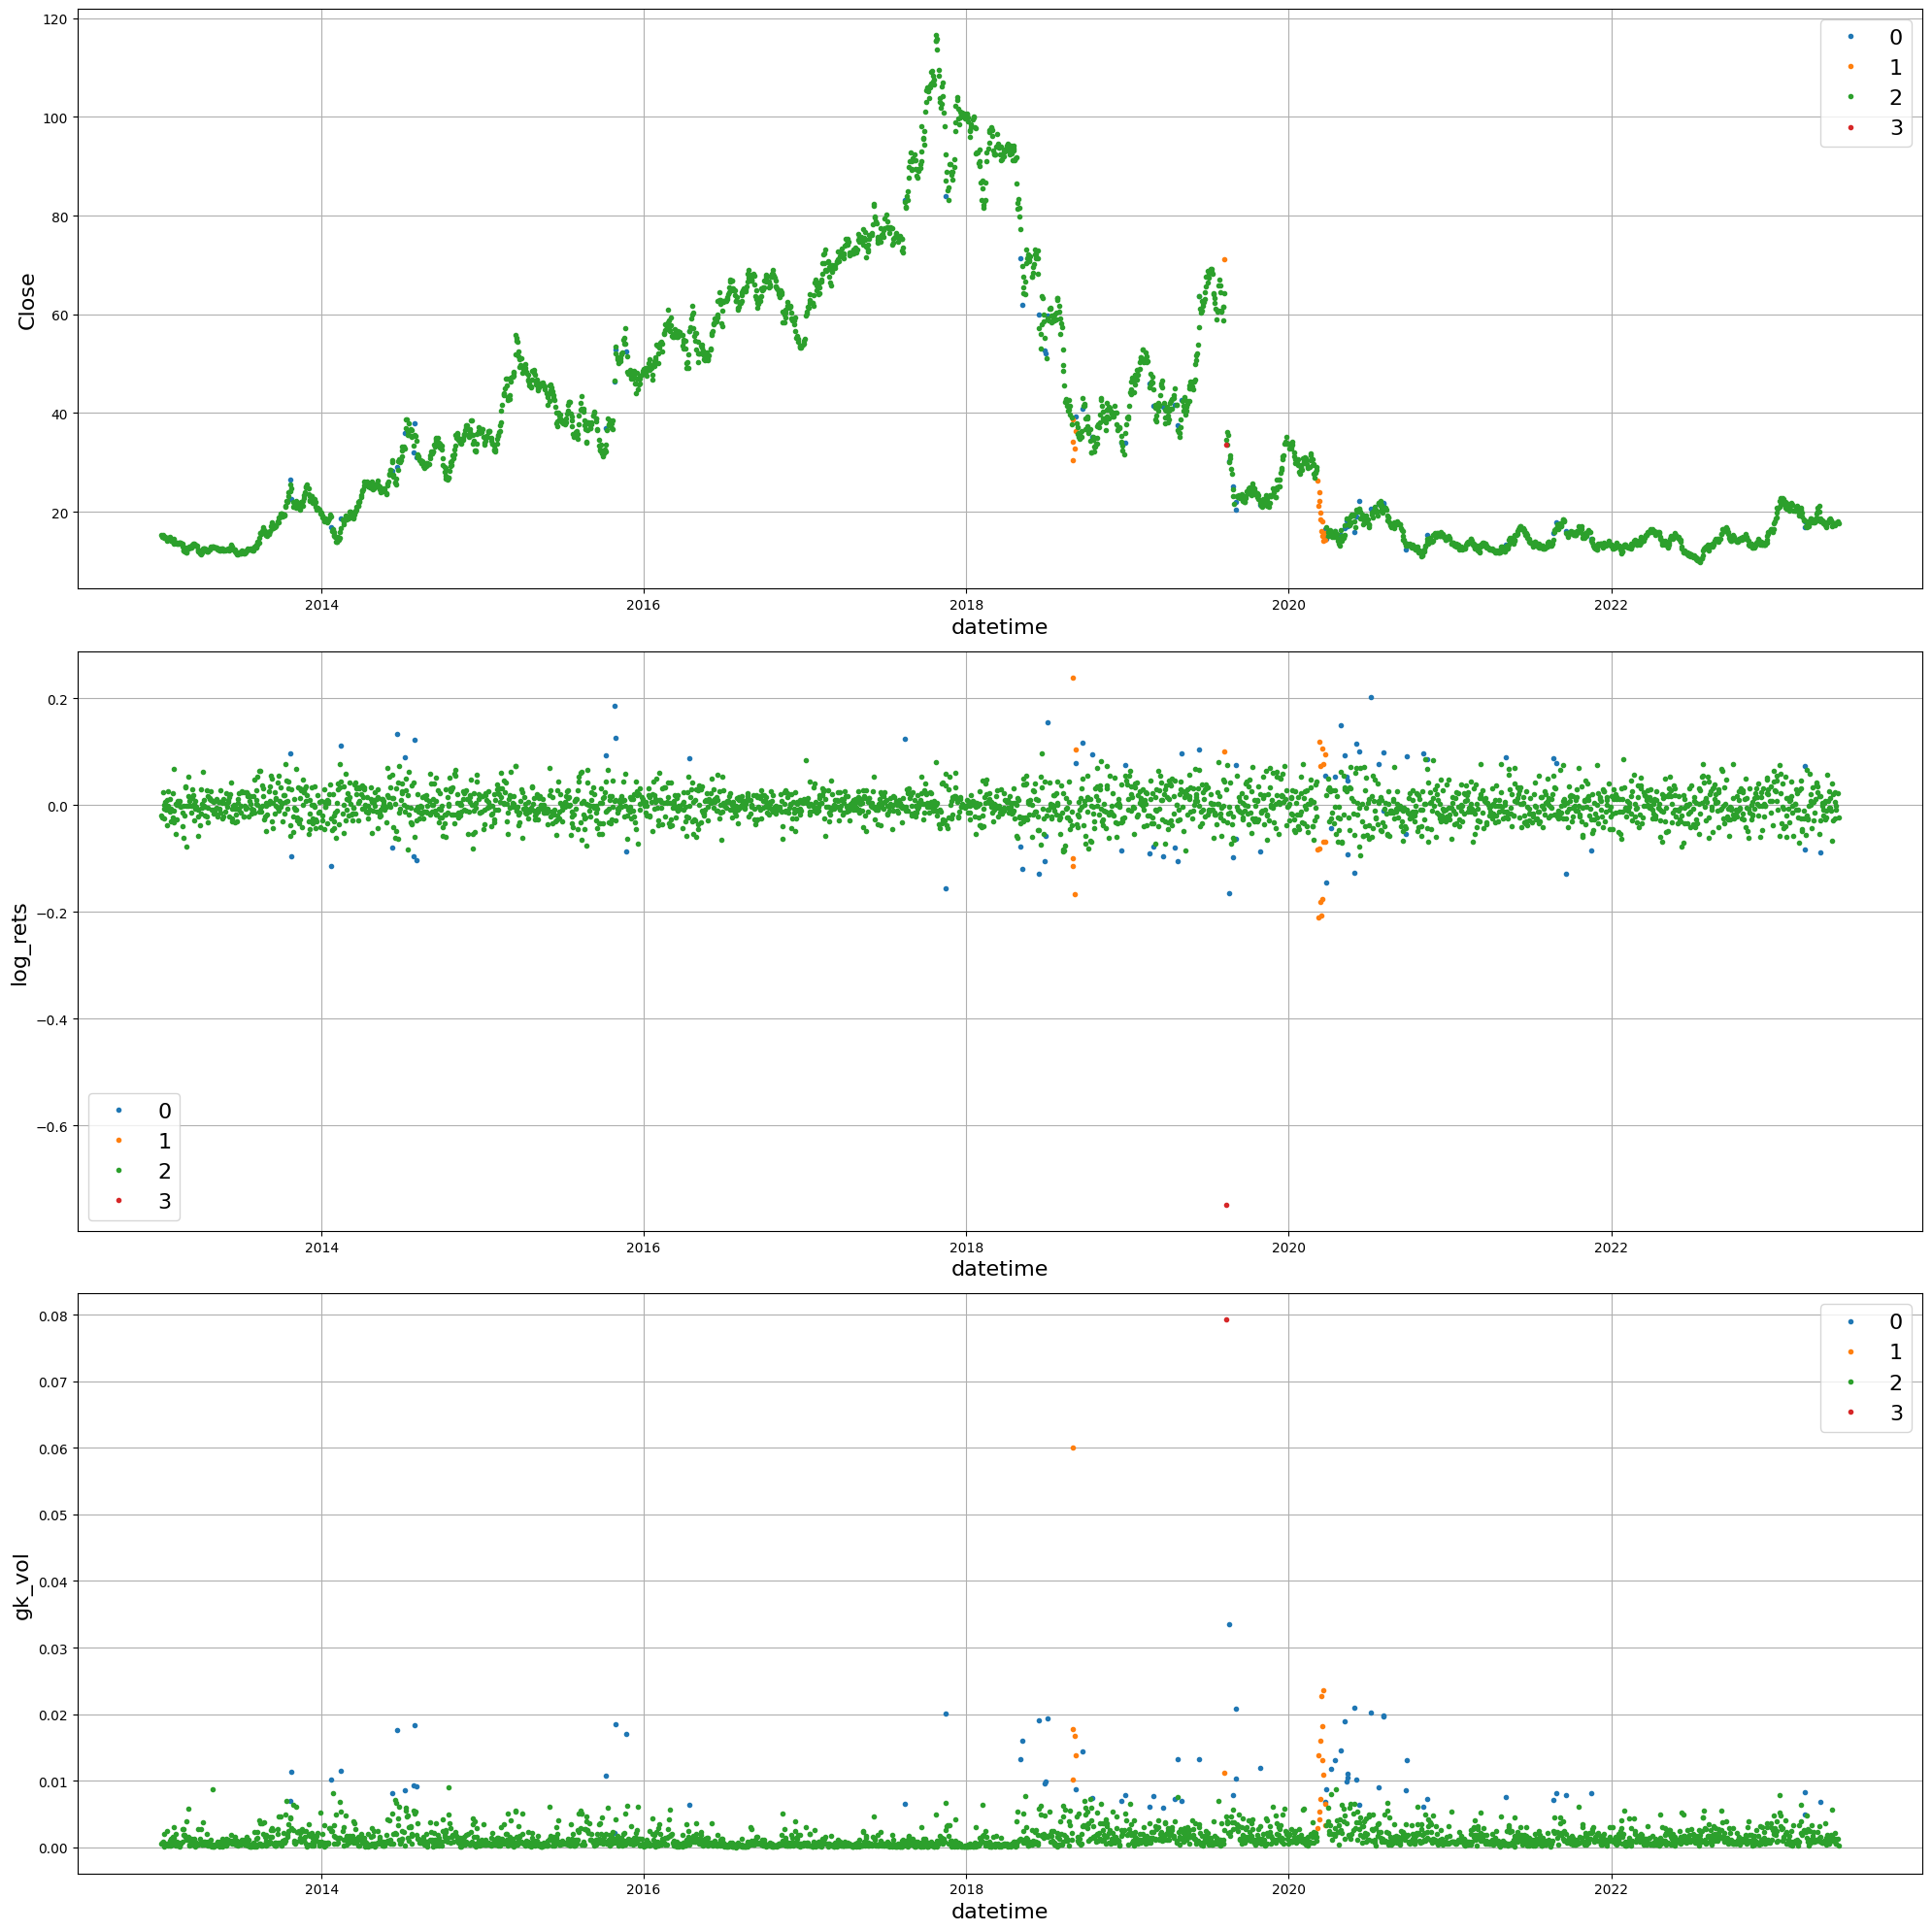

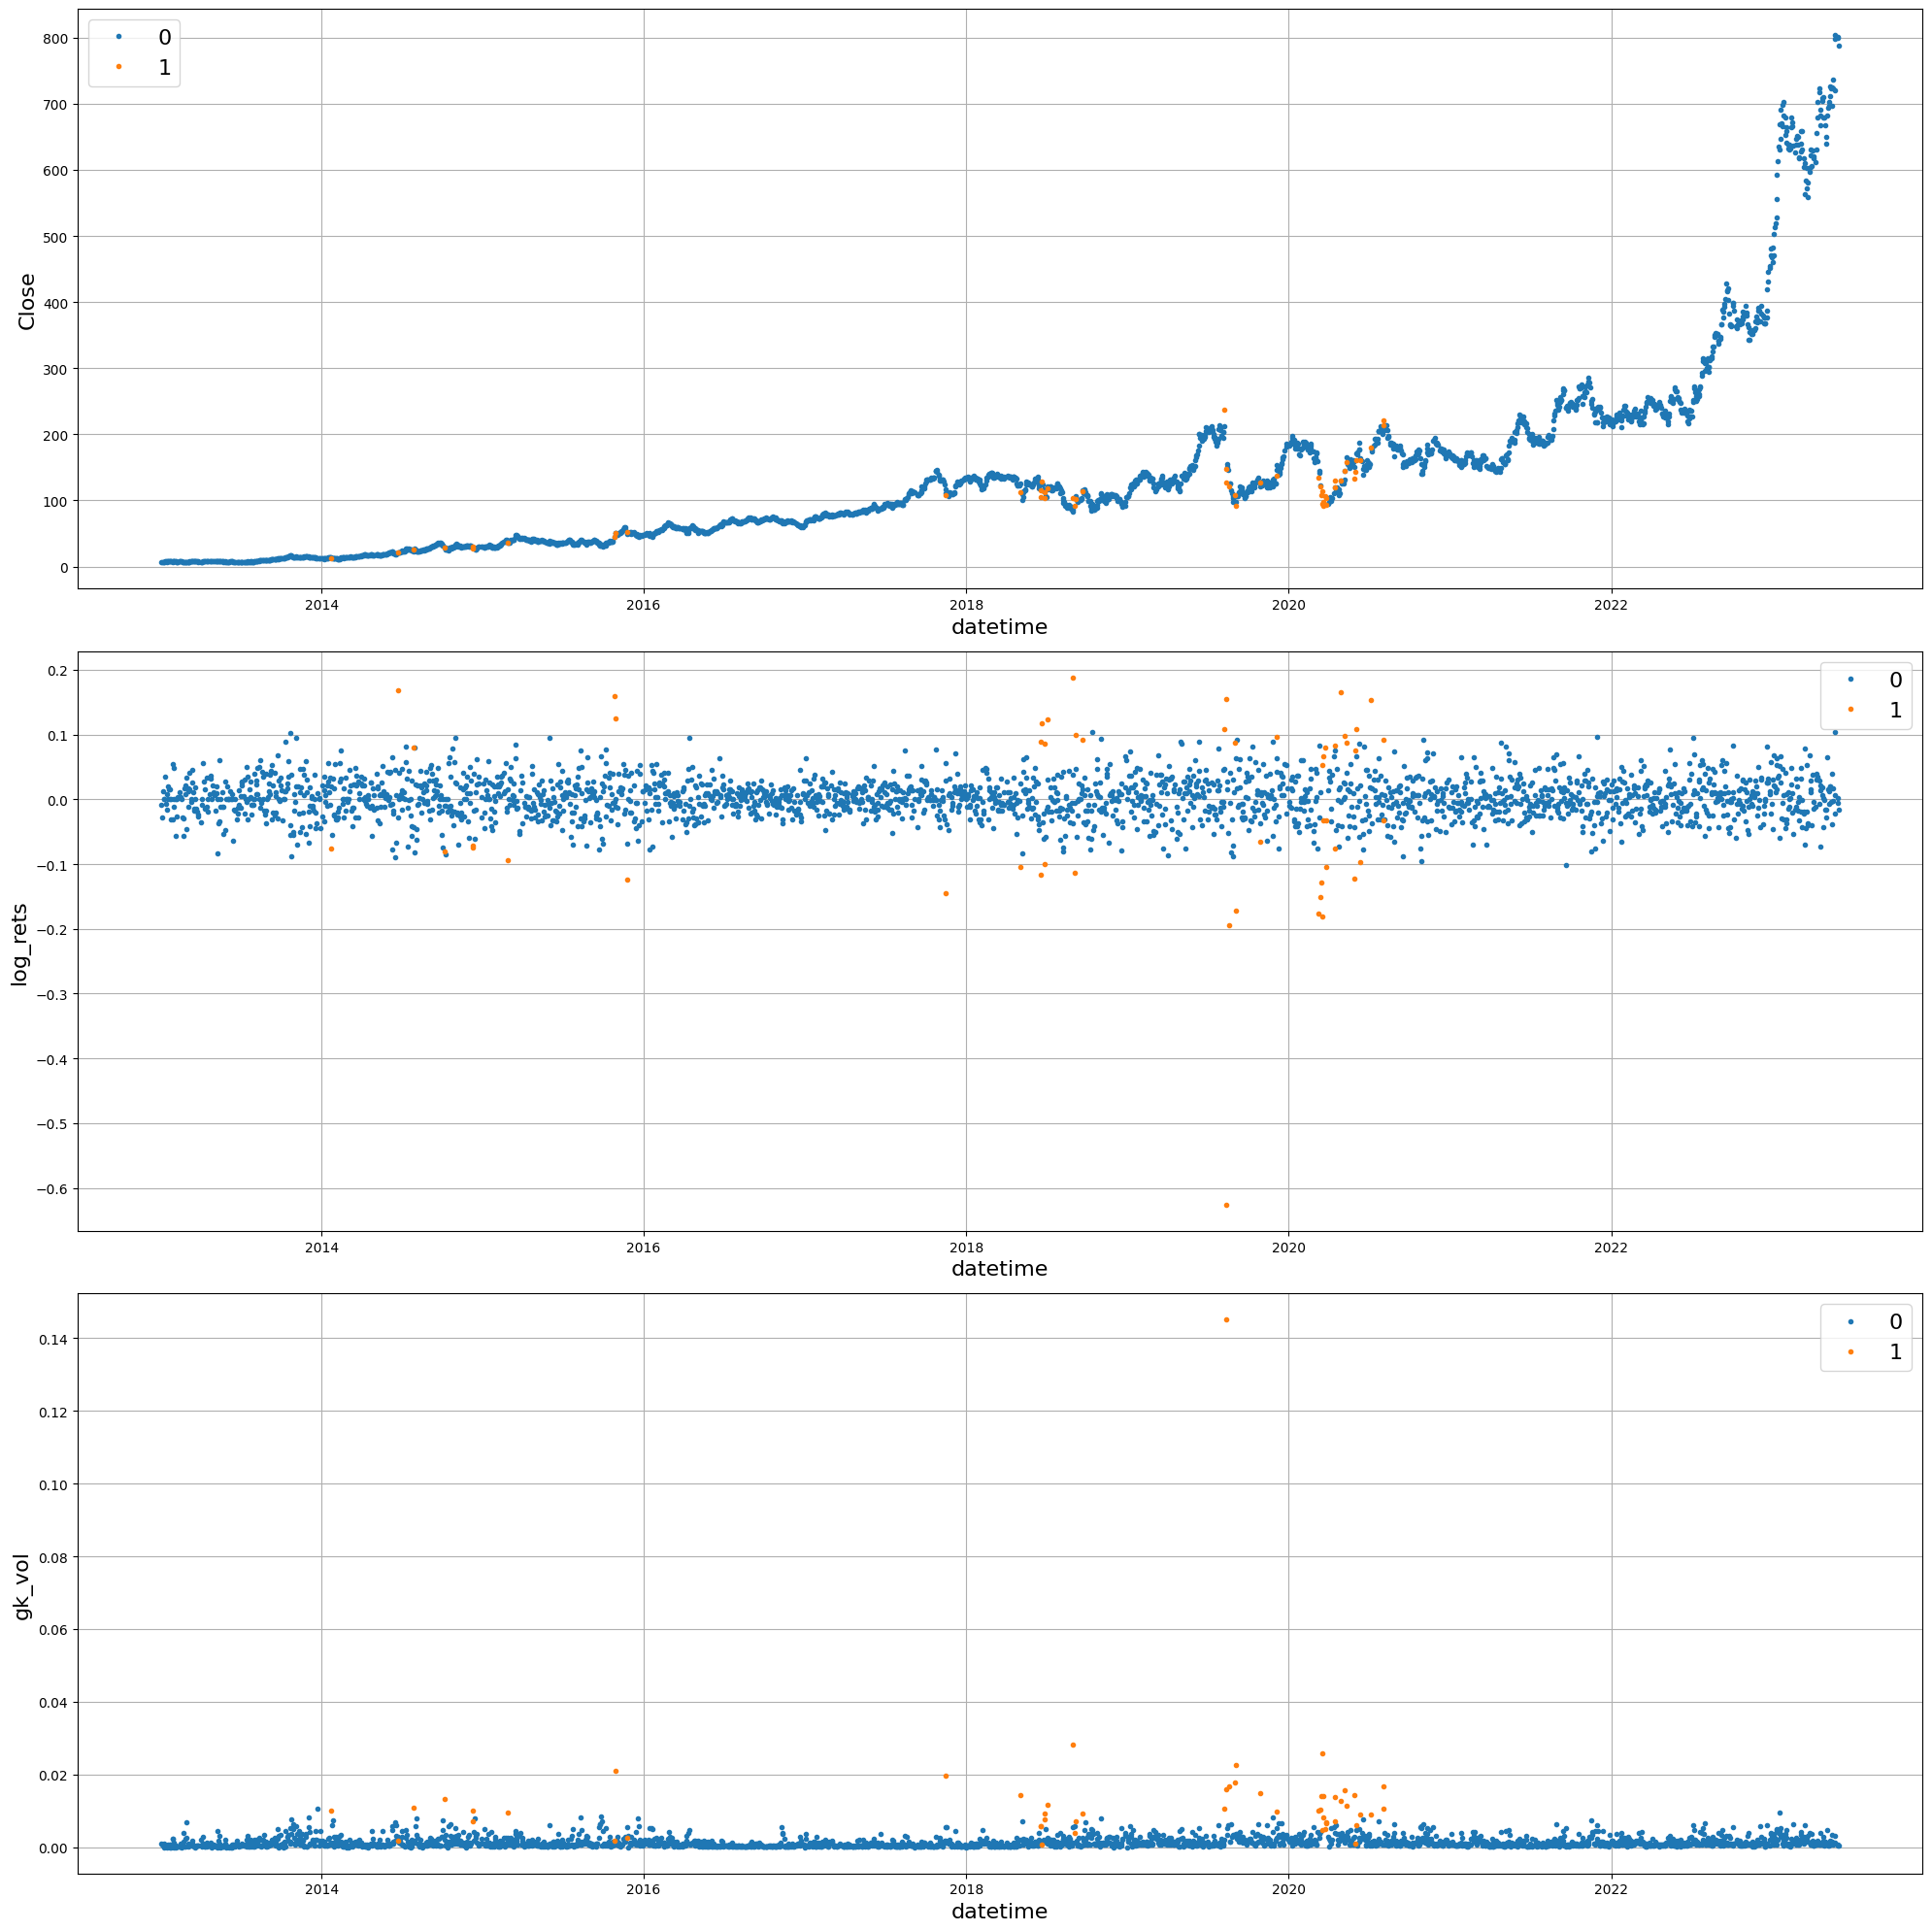

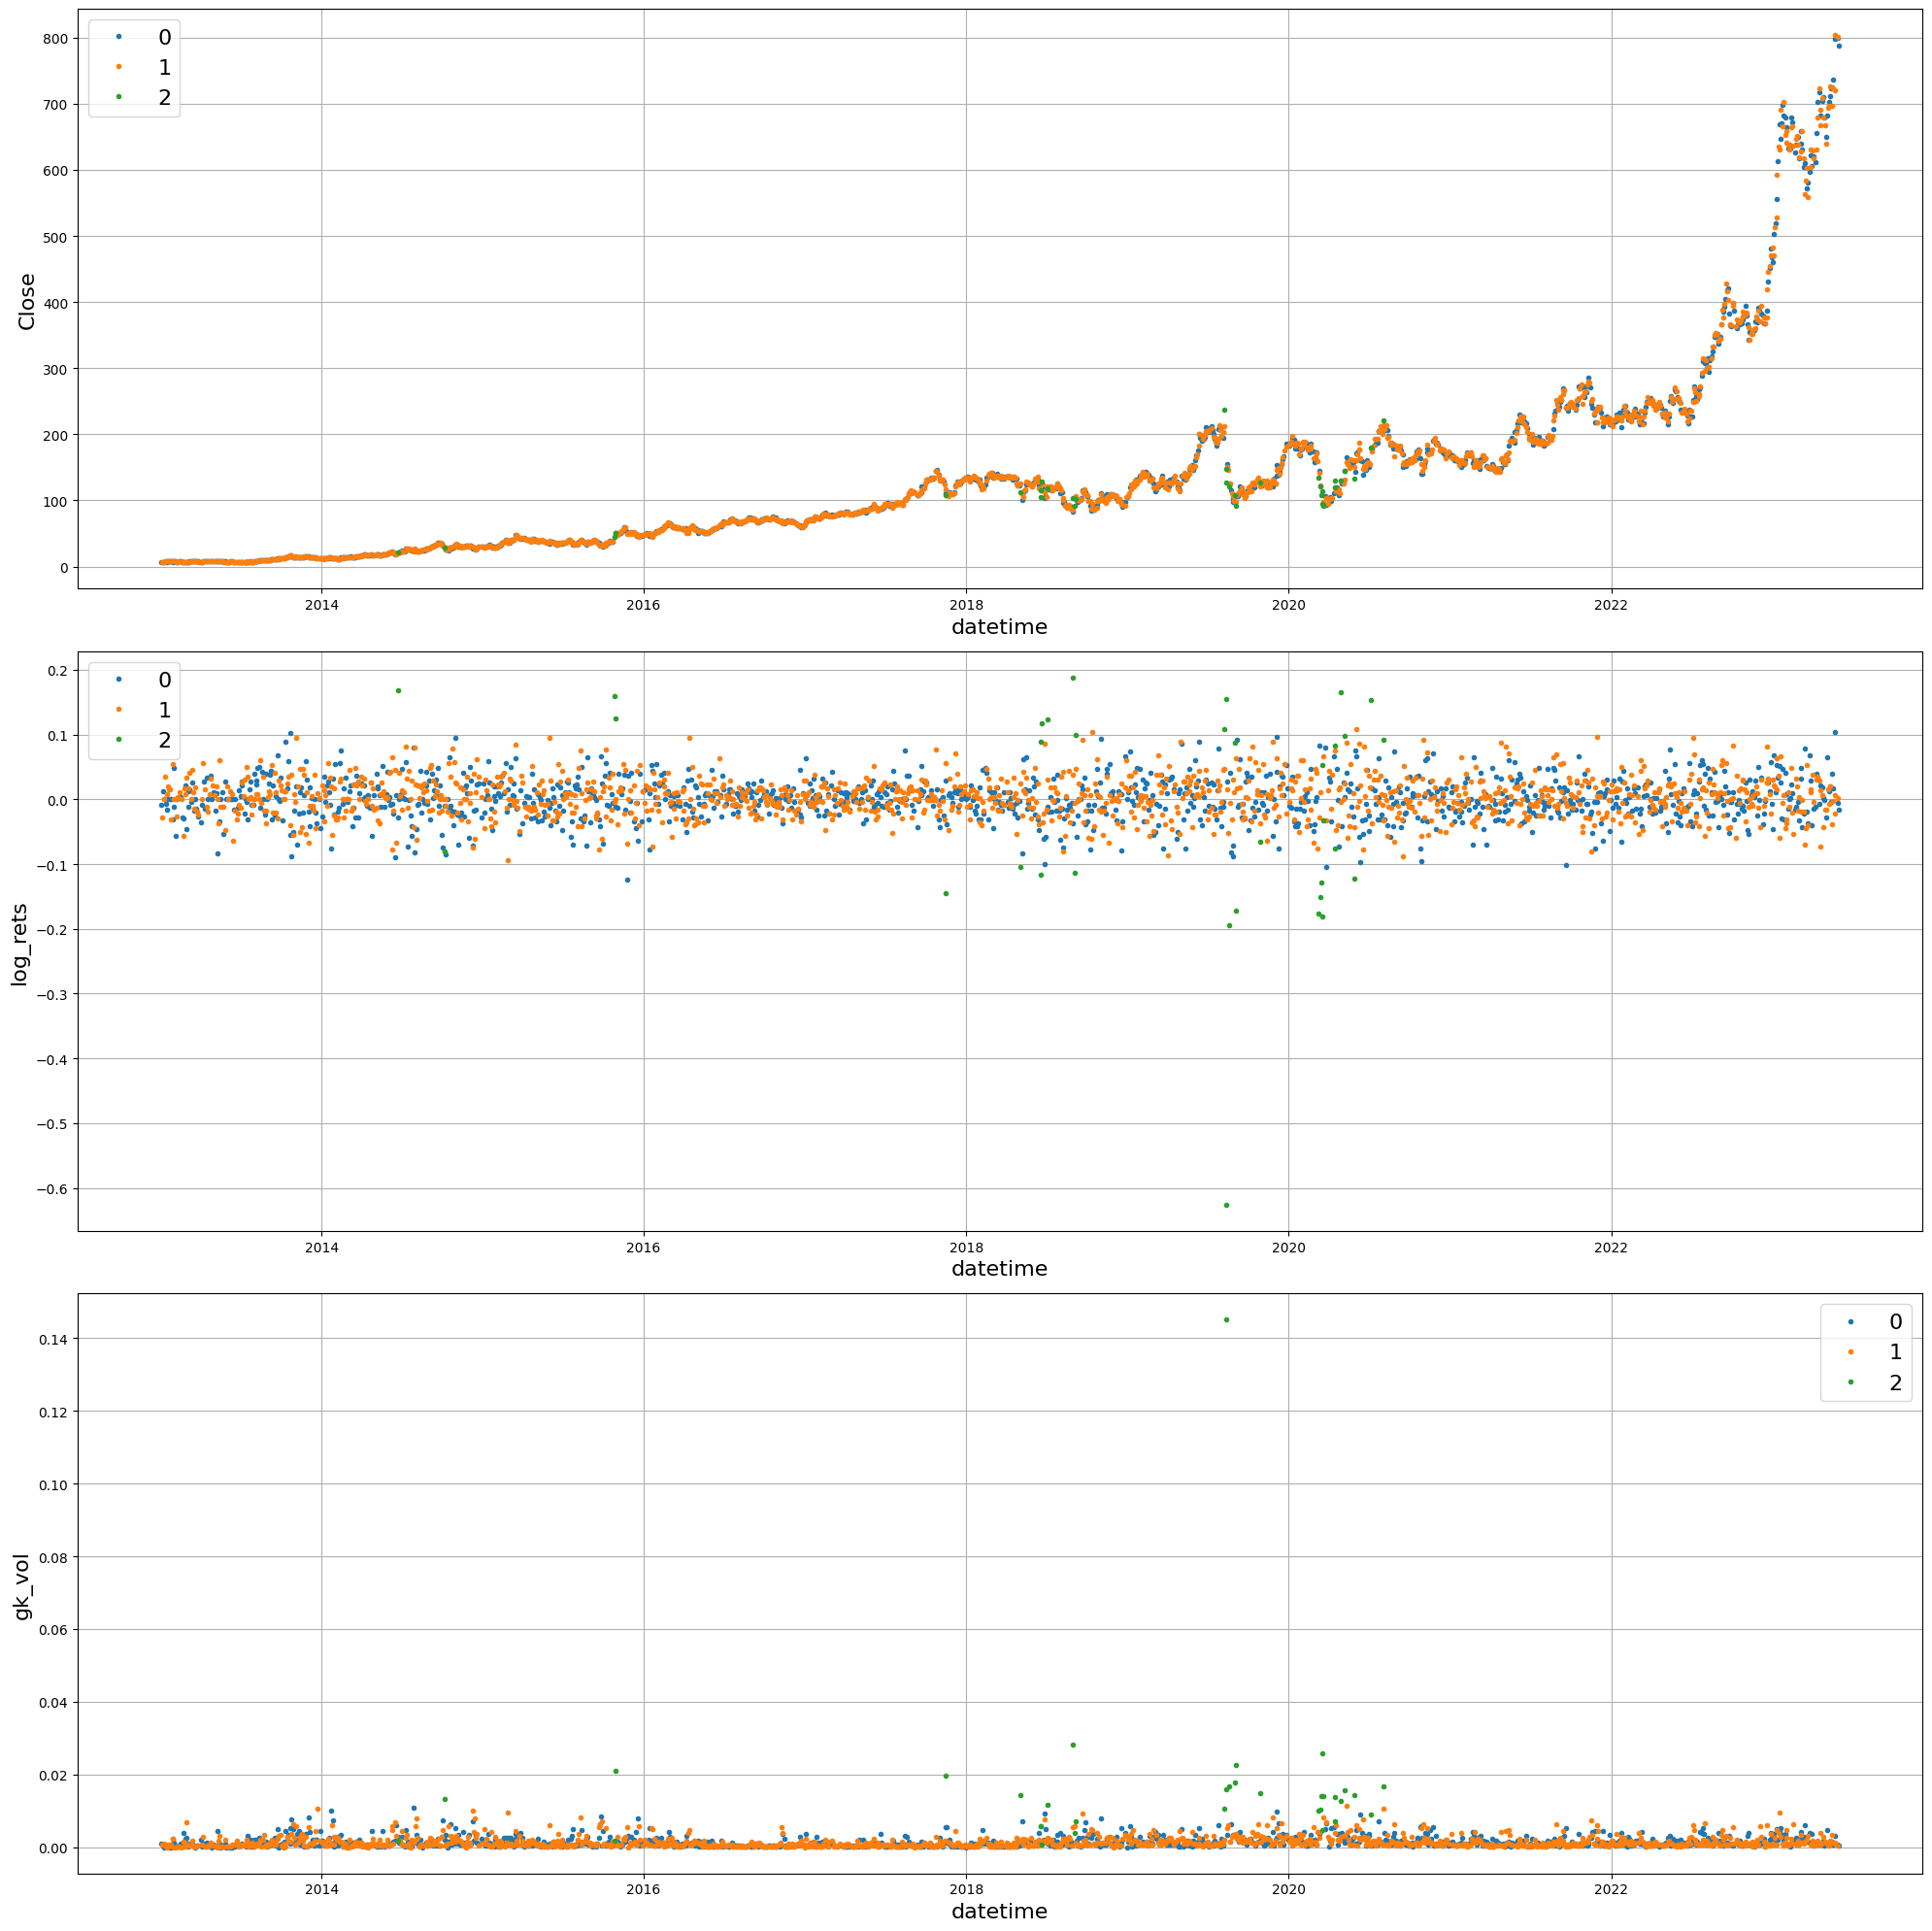

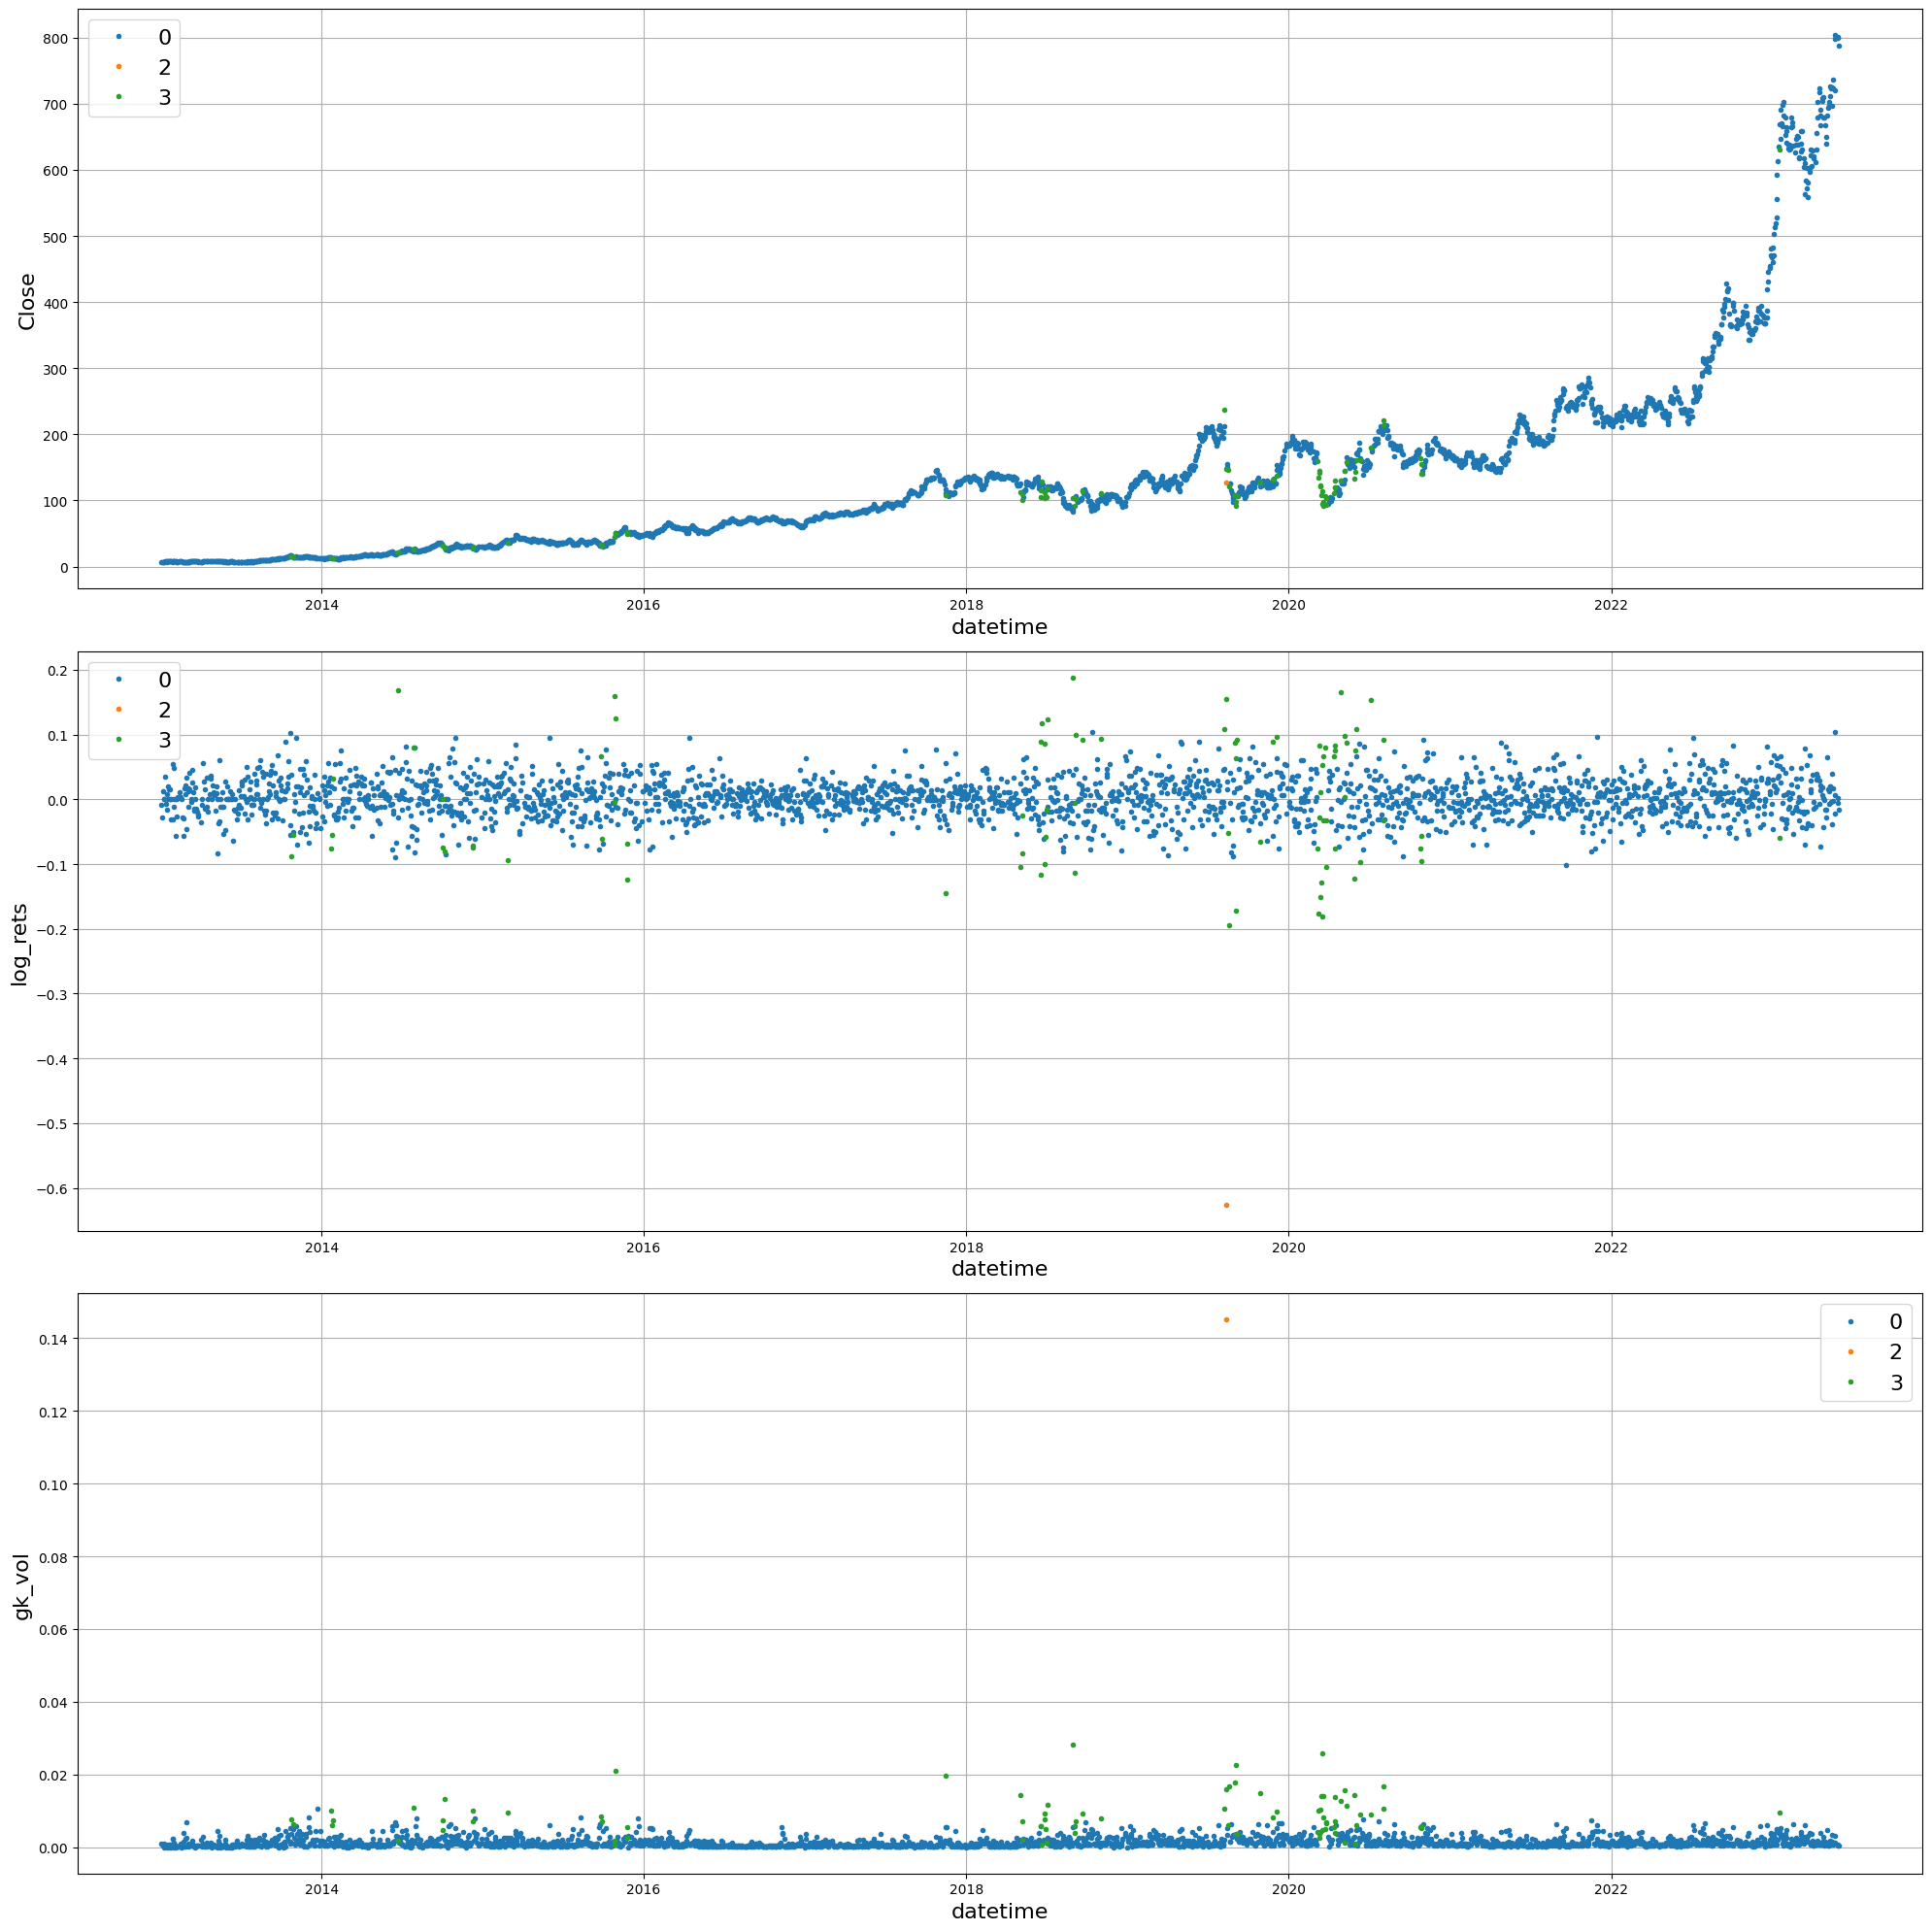

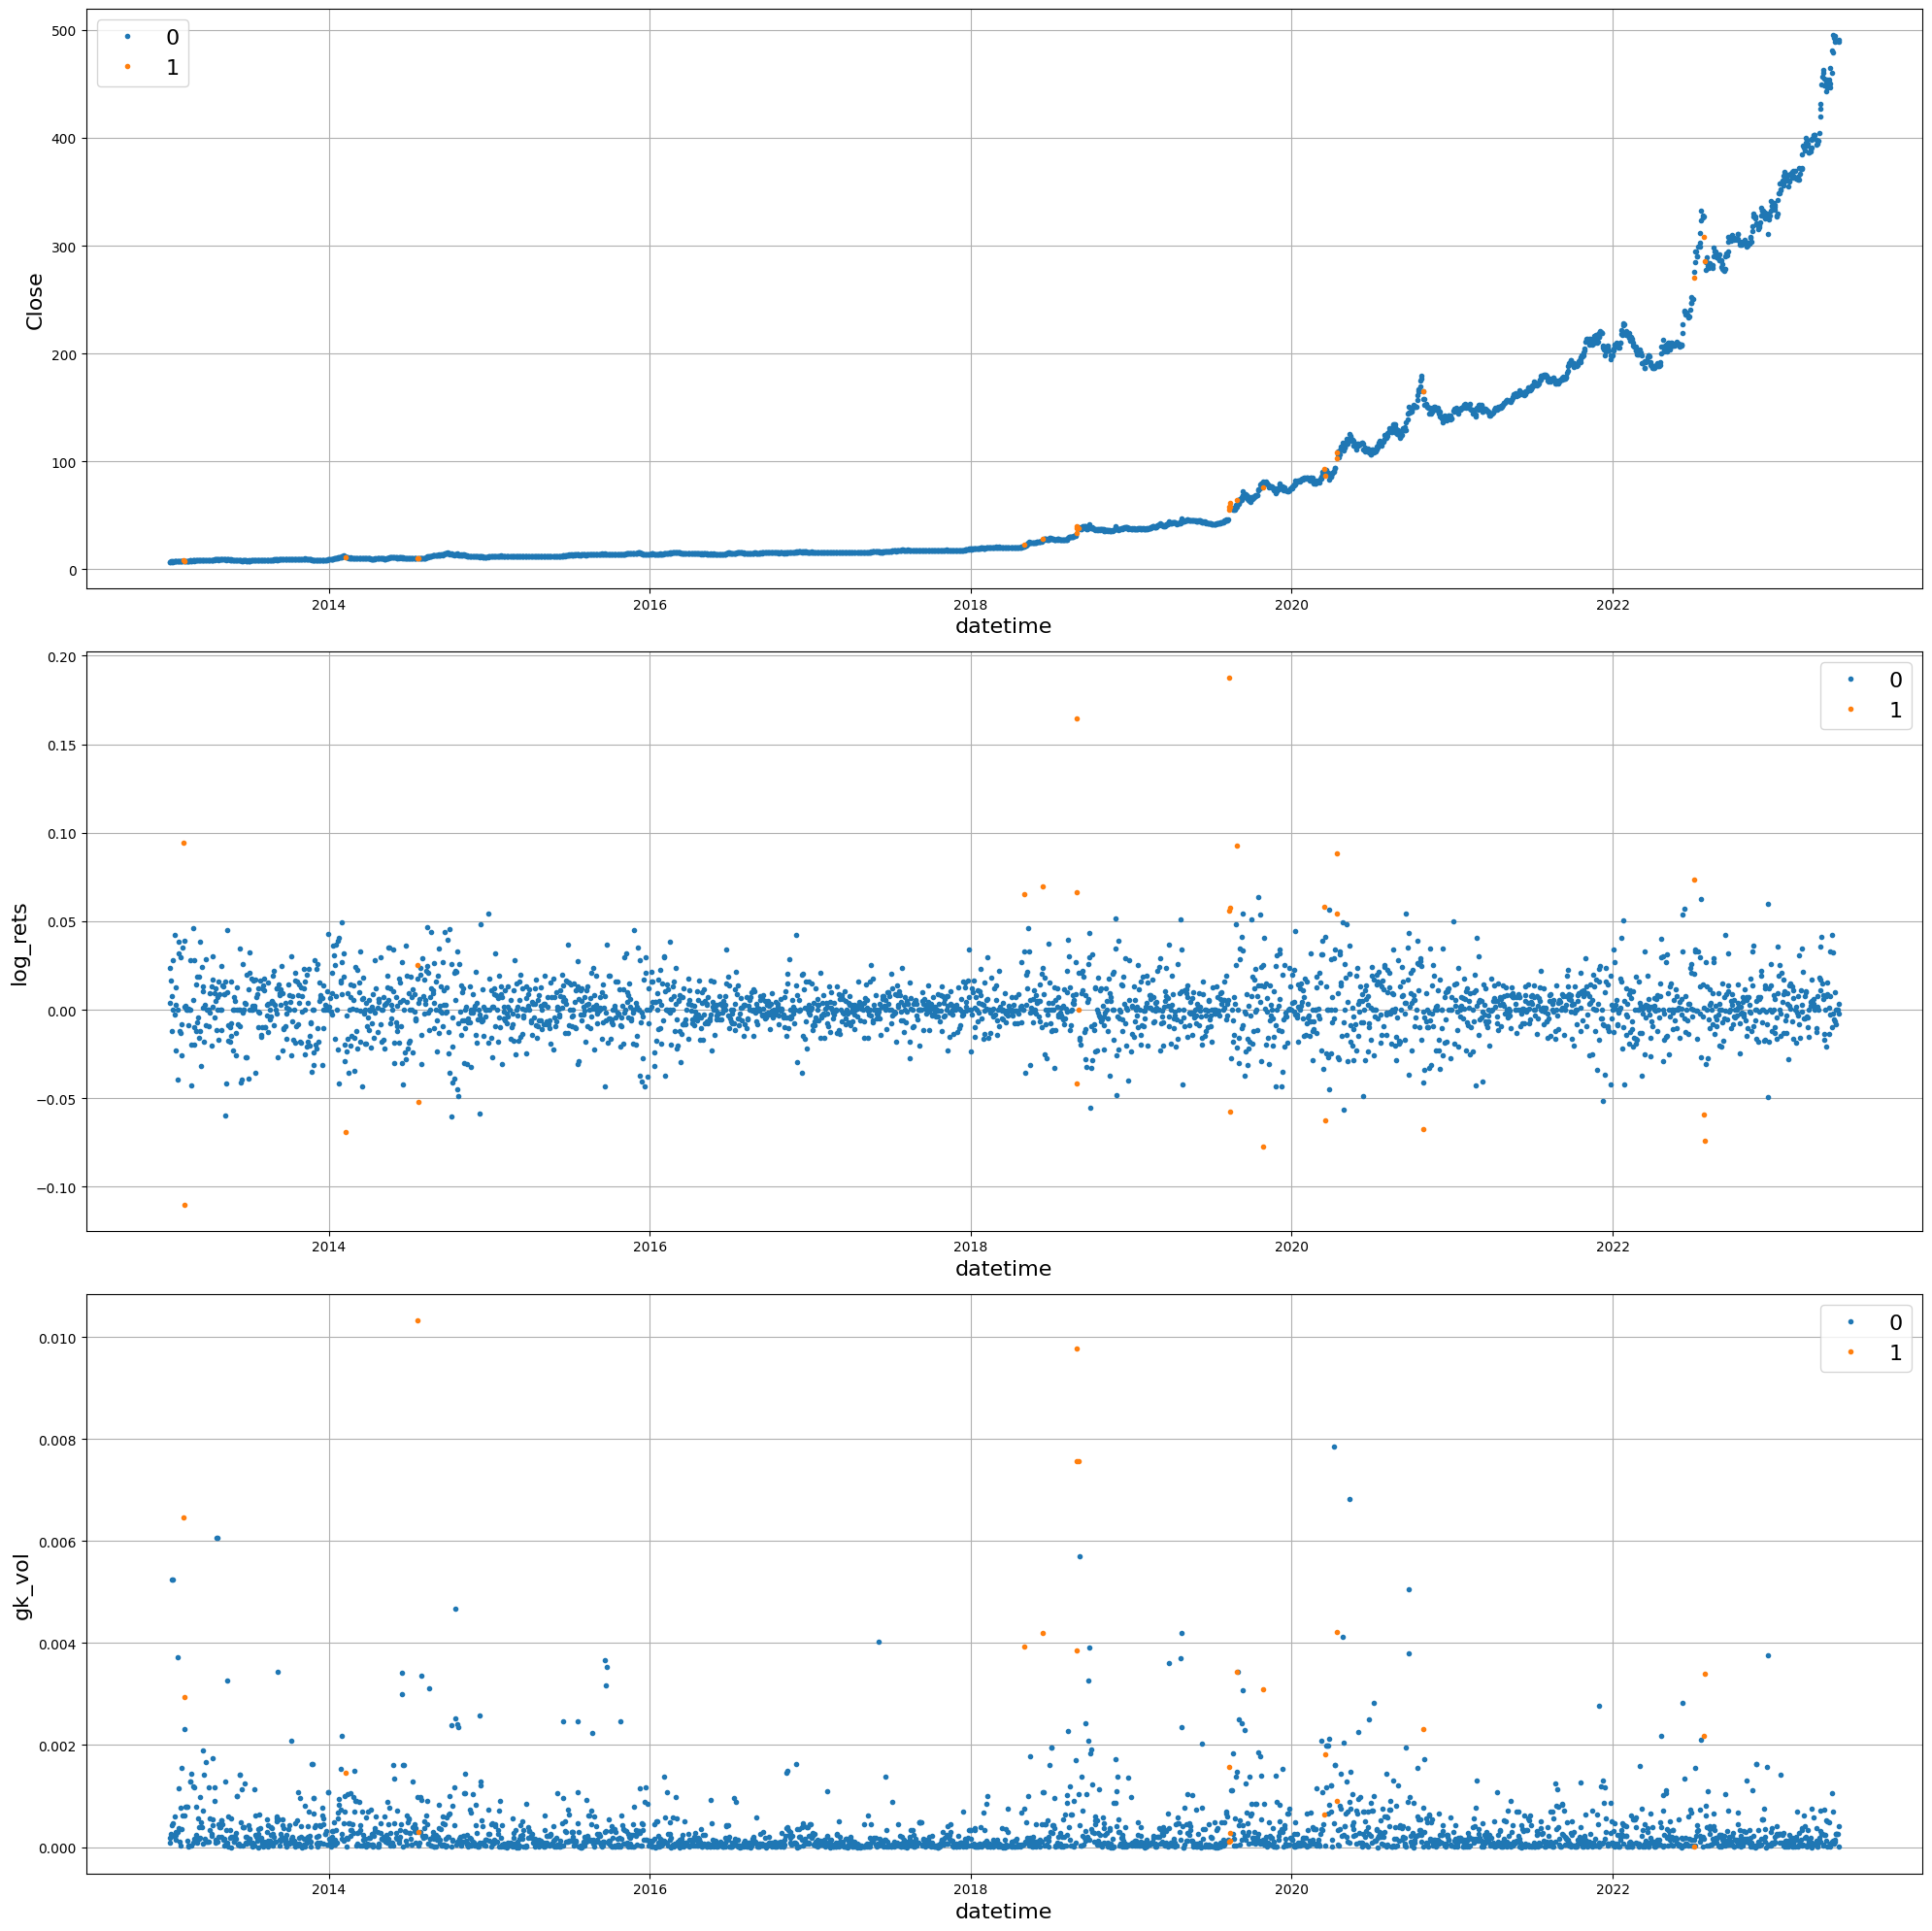

In [ ]:
for key in data.keys():
    for comp in comps:
        plot_close_rets_vol(data, key, comp)
plt.show()

## HMM Selection

Selecting the Number of States in Hidden Markov Models: Pragmatic Solutions Illustrated Using Animal Movement
https://sci-hub.st/10.1007/s13253-017-0283-8

Posiblemente requiera armar una funcion de chequeo que use model.monitor==True para chequear convergencia del modelo.  
Recien ahi rankear por AIC&BIC

https://hmmlearn.readthedocs.io/en/latest/api.html#hmmlearn.base.ConvergenceMonitor